# Load Data

In [7]:
import pickle
import pandas as pd

# load the scenario properties file
with open('../scenario-properties-collision.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)
    

In [6]:
scenario_properties.sma_HMid_km

array([6579.52548889, 6682.30326667, 6785.08104444, 6887.85882222,
       6990.6366    , 7093.41437778, 7196.19215556, 7298.96993333,
       7401.74771111, 7504.52548889, 7607.30326667, 7710.08104444,
       7812.85882222, 7915.6366    , 8018.41437778, 8121.19215556,
       8223.96993333, 8326.74771111])

# Initial Population

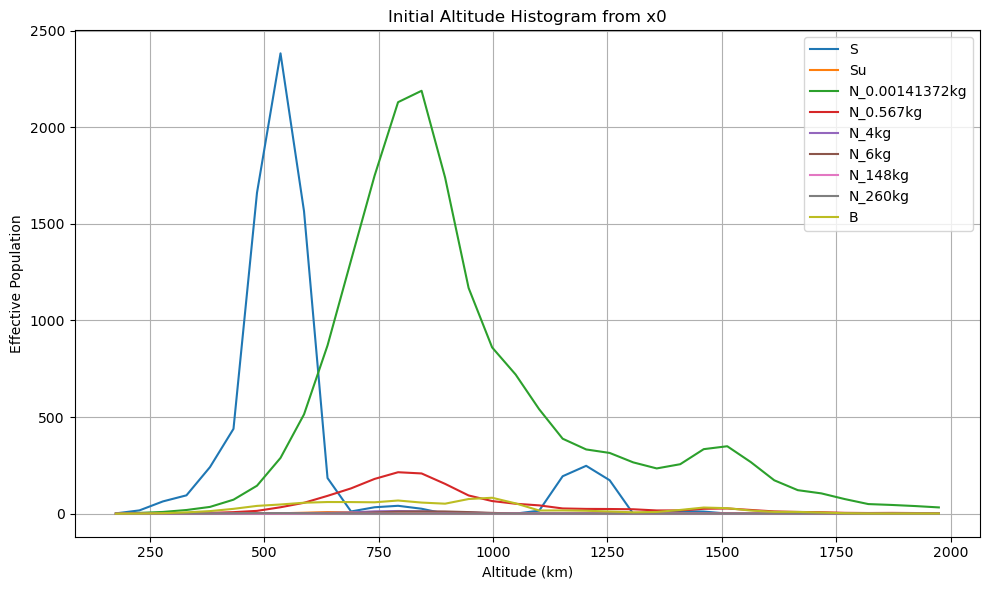

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack inputs
x0 = scenario_properties.x0  # shape: (sma, species, ecc)
TIS = scenario_properties.time_in_shell  # shape: (altitude, ecc, sma)
altitudes = scenario_properties.HMid  # length: n_alt_shells
species_names = scenario_properties.species_names

n_sma_bins, n_species, n_ecc_bins = x0.shape
n_alt_shells = TIS.shape[0]

# --- Calculate effective population in each altitude shell per species ---
effective_altitude_matrix = np.zeros((n_alt_shells, n_species))

for species in range(n_species):
    for alt_shell in range(n_alt_shells):
        total = 0.0
        for sma in range(n_sma_bins):
            for ecc in range(n_ecc_bins):
                n_pop = x0[sma, species, ecc]
                tis = TIS[alt_shell, ecc, sma]
                total += n_pop * tis
        effective_altitude_matrix[alt_shell, species] = total

# --- Plot: One line per species ---
plt.figure(figsize=(10, 6))
for s in range(n_species):
    plt.plot(altitudes, effective_altitude_matrix[:, s], label=species_names[s])

plt.xlabel("Altitude (km)")
plt.ylabel("Effective Population")
plt.title("Initial Altitude Histogram from x0")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # Log scale for better visibility
plt.show()

In [13]:
# %%  
# Single cell: project SMA×ecc into altitude, then export pop_time.csv & pop_time_alt.csv

import os
import numpy as np
import pandas as pd

# — adjust these as needed — 
output_dir = "output_alt"
os.makedirs(output_dir, exist_ok=True)

# shortcut
sp = scenario_properties

# dims
n_sma    = sp.n_shells
n_sp     = sp.species_length
n_ecc    = len(sp.eccentricity_bins) - 1
n_time   = sp.output.y.shape[1]
times    = np.array(sp.output.t)
alts     = np.array(sp.HMid)
names    = sp.species_names

# reshape into (sma, species, ecc, time)
y4d = sp.output.y.reshape(n_sma, n_sp, n_ecc, n_time)

# build altitude‐projected 3D array [alt, species, time]
y_alt = np.zeros((n_sma, n_sp, n_time))
for t in range(n_time):
    # take SMA×ecc slice for each species
    block = y4d[:, :, :, t]              # (sma, species, ecc)
    # project into altitudes via your converter
    proj  = sp.sma_ecc_mat_to_altitude_mat(block)  # returns (alt, species)
    y_alt[:, :, t] = proj

# 1) pop_time.csv  — total pop per species per year
rows = []
for i, code in enumerate(names):
    for t, offset in enumerate(times):
        year = int(sp.start_year + offset)
        pop  = float(y_alt[:, i, t].sum())
        rows.append({"Species": code, "Year": year, "Population": pop})
df_time = pd.DataFrame(rows).groupby(["Species","Year"], as_index=False).sum()
df_time.to_csv(f"{output_dir}/pop_time.csv", index=False)

# 2) pop_time_alt.csv — pop per species×altitude×year
rows = []
for i, code in enumerate(names):
    for a_idx, alt in enumerate(alts):
        for t, offset in enumerate(times):
            year = int(sp.start_year + offset)
            pop  = float(y_alt[a_idx, i, t])
            rows.append({
                "Species":    code,
                "Year":       year,
                "Altitude":   alt,
                "Population": pop
            })
df_alt = pd.DataFrame(rows).groupby(
    ["Species","Year","Altitude"], as_index=False
).sum()
df_alt.to_csv(f"{output_dir}/pop_time_alt.csv", index=False)

print("Wrote:", 
      f"{output_dir}/pop_time.csv  ({len(df_time)} rows),",
      f"{output_dir}/pop_time_alt.csv  ({len(df_alt)} rows)")

AttributeError: 'ScenarioProperties' object has no attribute 'start_year'

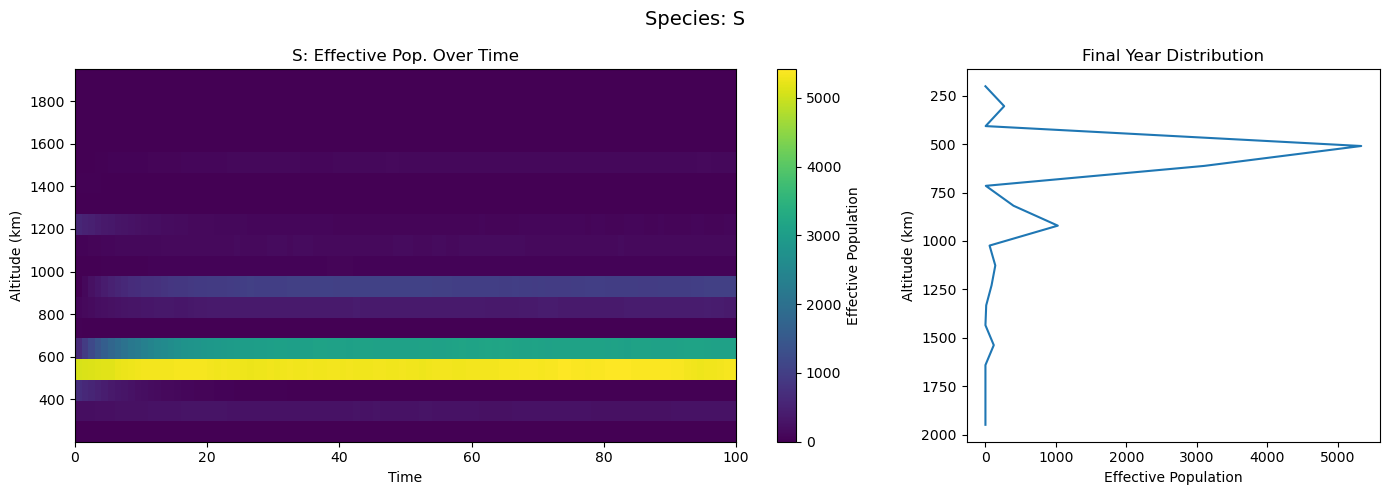

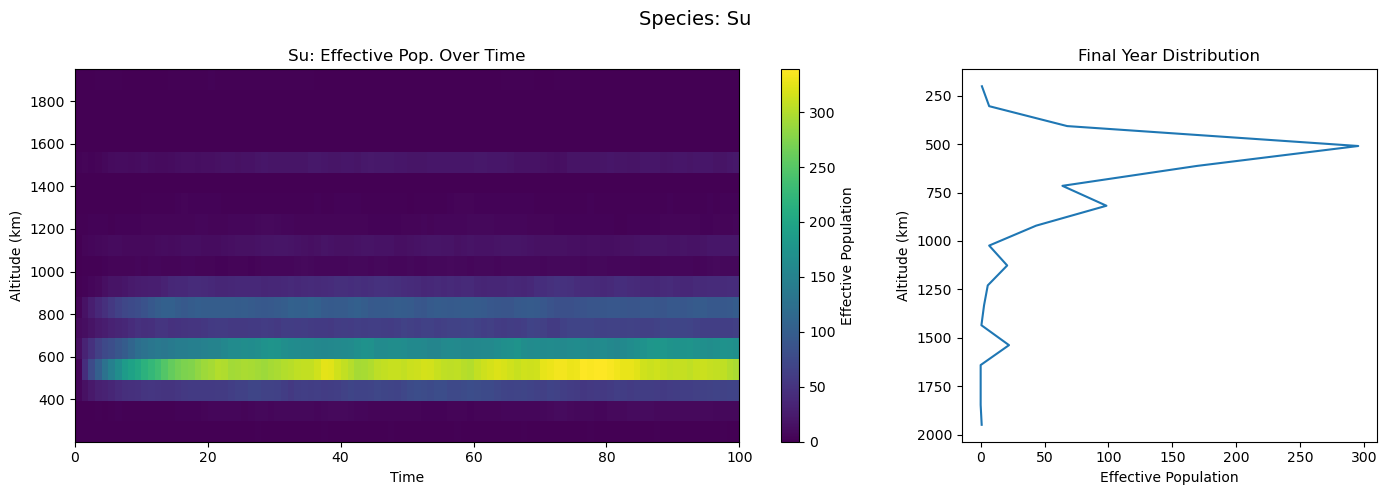

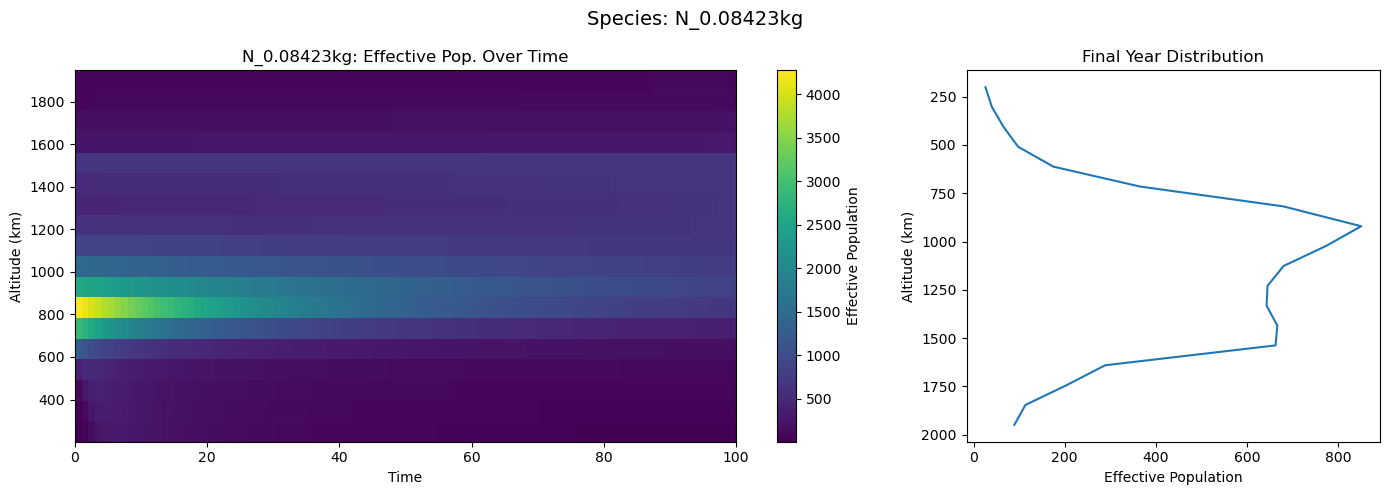

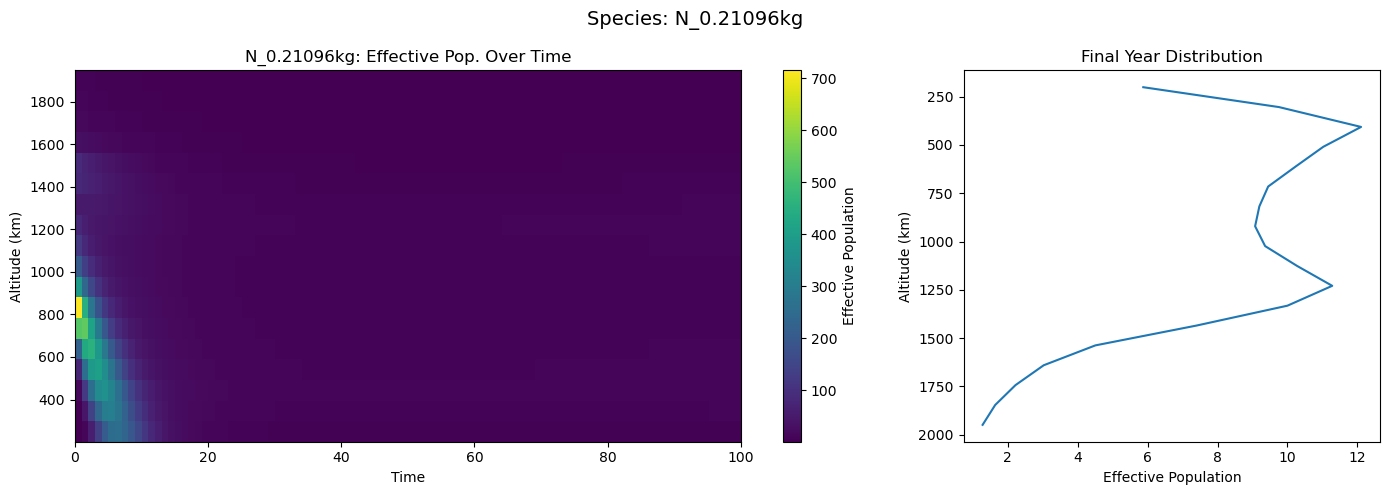

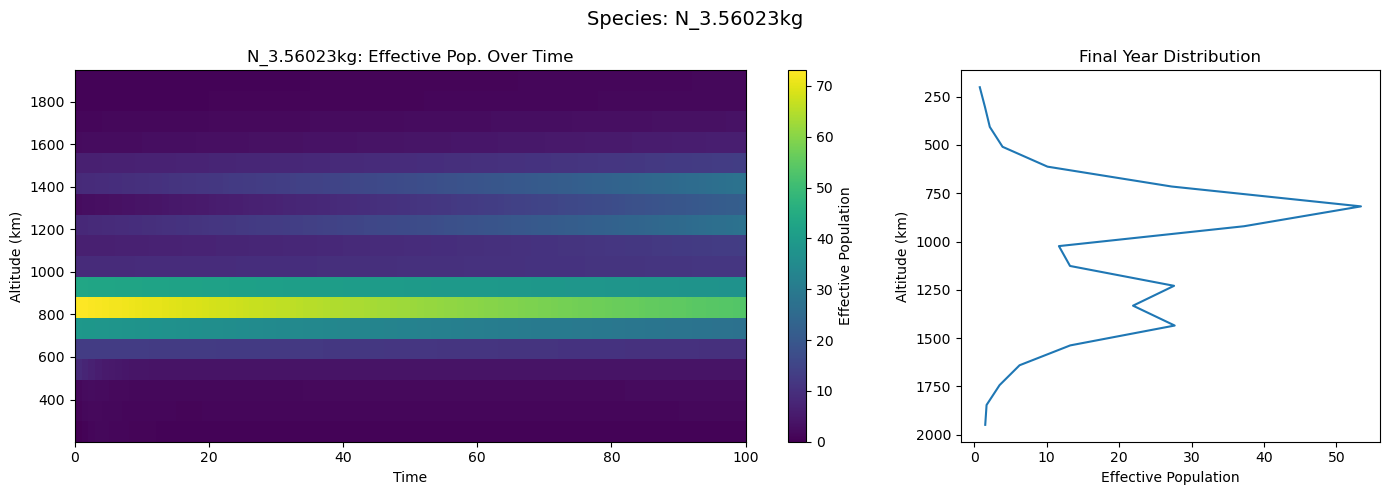

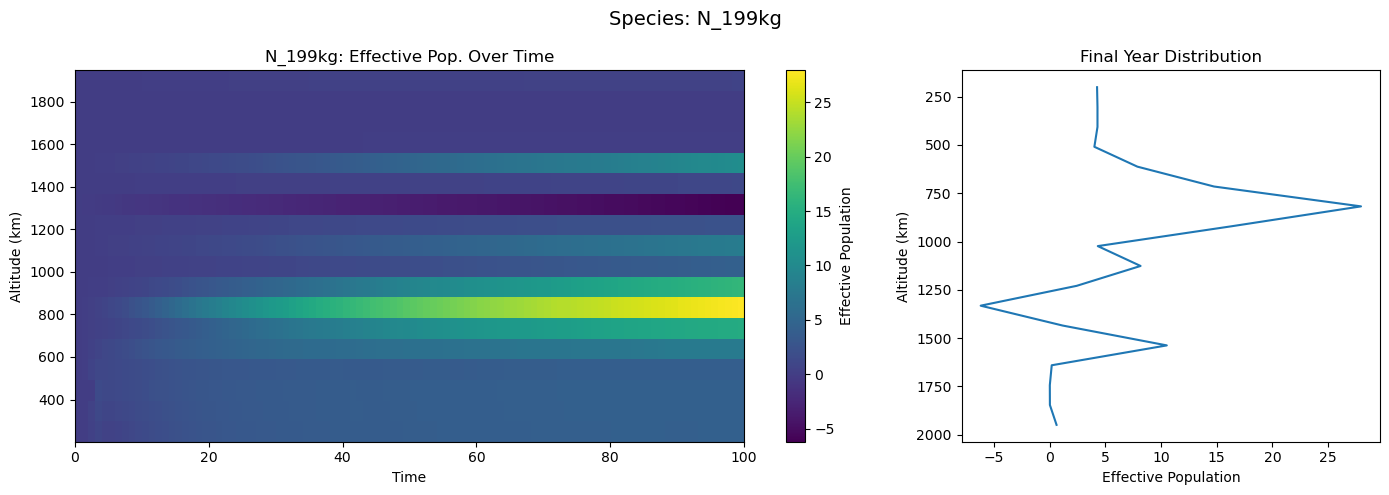

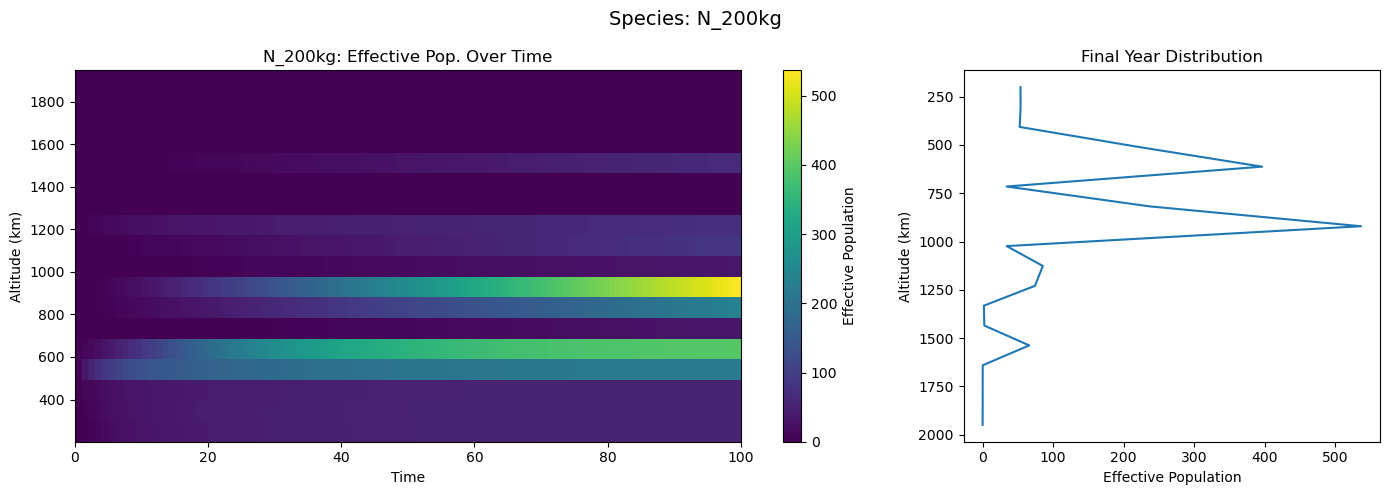

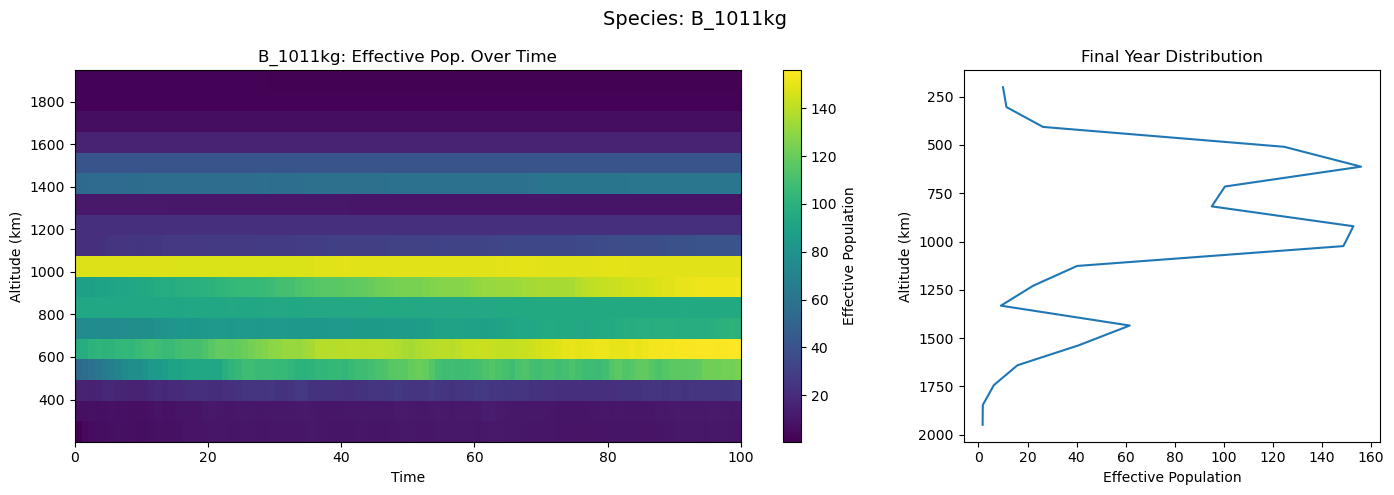

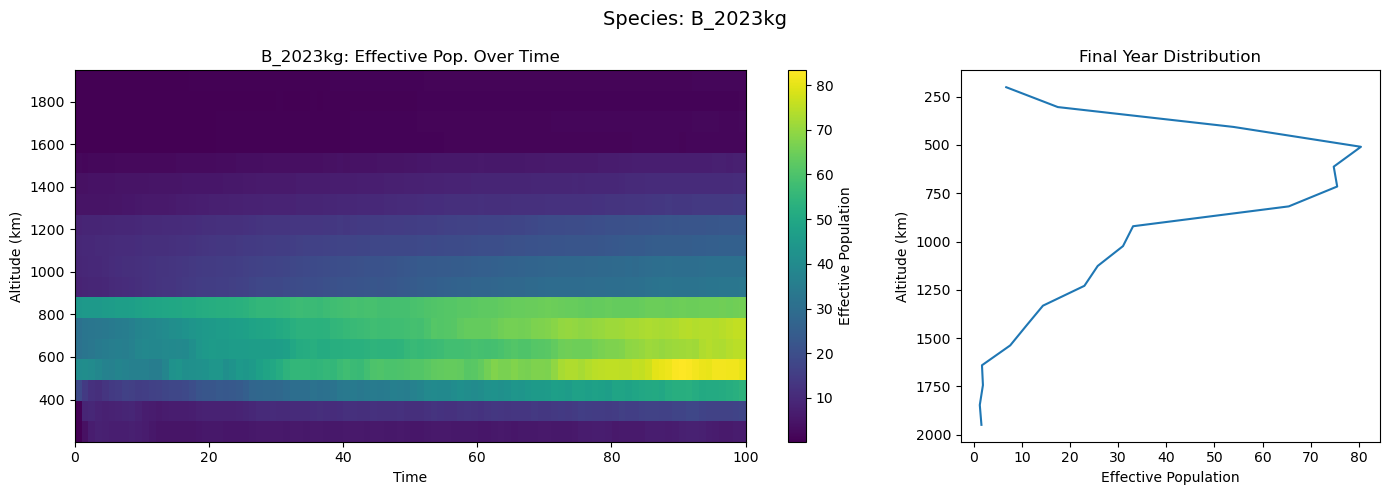

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_alt_shells = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
n_time = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # Altitude midpoints

# --- Unpack population data ---
y = scenario_properties.output.y
x_matrix = y.reshape(n_sma_bins, n_species, n_ecc_bins, n_time)  # shape: (sma, species, ecc, time)

# === Plotting ===
for s in range(n_species):
    n_eff_time = np.zeros((n_alt_shells, n_time))  # Altitude shells × time

    for t in range(n_time):
        pop_snapshot = x_matrix[:, s, :, t]  # shape: (sma, ecc)
        
        # Reconstruct full shape (sma, species, ecc) to use in converter
        pop_full = np.zeros((n_sma_bins, n_species, n_ecc_bins))
        pop_full[:, s, :] = pop_snapshot

        # Convert to altitude matrix using your method
        alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(pop_full)
        n_eff_time[:, t] = alt_proj[:, s]

    # Final year distribution
    final_year_dist = n_eff_time[:, -1]

    # --- Create subplot: Heatmap + Final Distribution ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Heatmap of effective population over time
    im = axes[0].imshow(n_eff_time, aspect='auto', origin='lower',
                        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
                        cmap='viridis')
    axes[0].set_title(f"{species_names[s]}: Effective Pop. Over Time")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Altitude (km)")
    plt.colorbar(im, ax=axes[0], label="Effective Population")

    # Right: Final year distribution
    axes[1].plot(final_year_dist, altitudes)
    axes[1].set_title("Final Year Distribution")
    axes[1].set_xlabel("Effective Population")

    axes[1].set_ylabel("Altitude (km)")
    axes[1].invert_yaxis()

    plt.suptitle(f"Species: {species_names[s]}", fontsize=14)
    plt.tight_layout()
    plt.show()

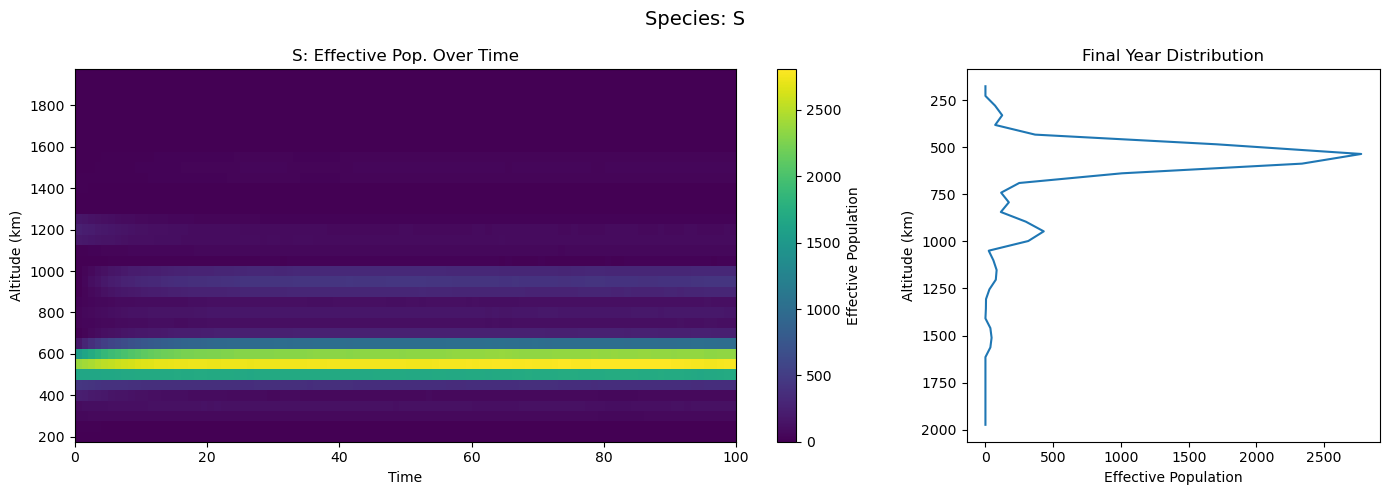

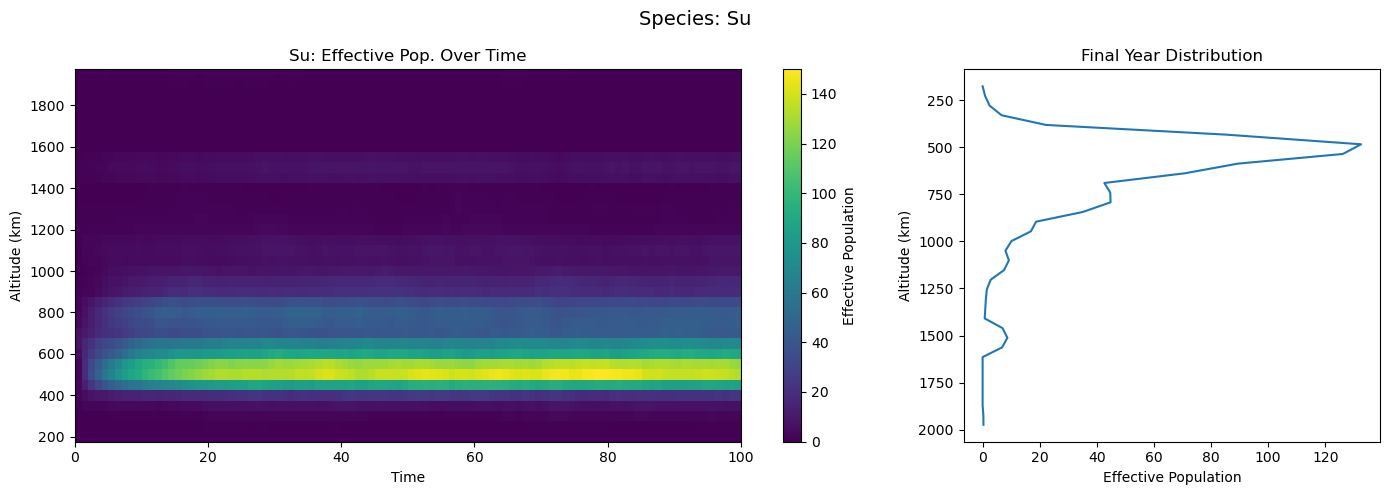

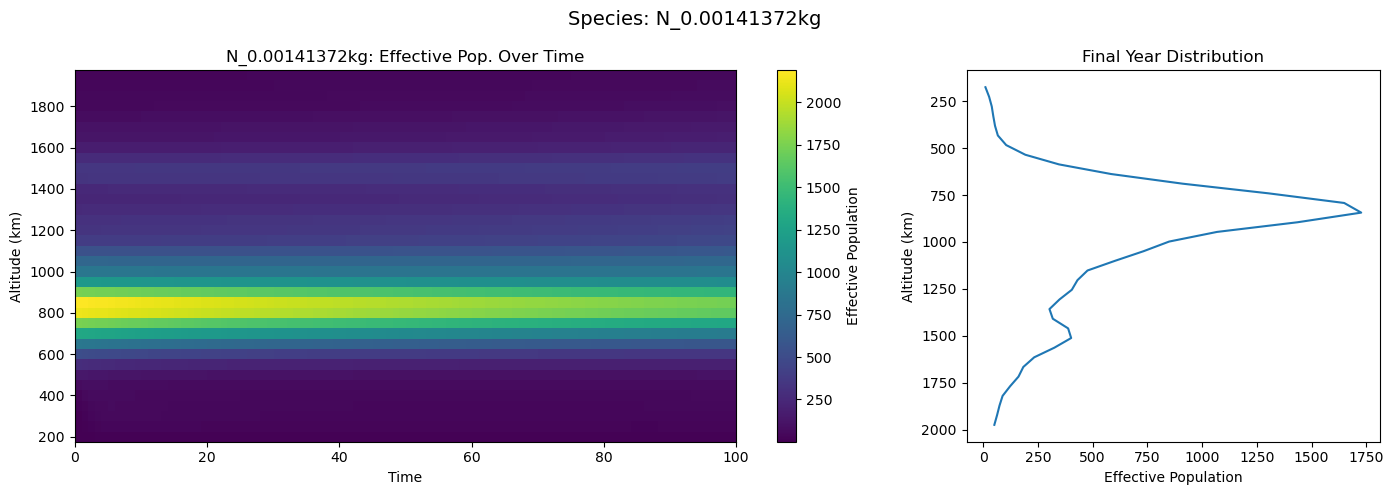

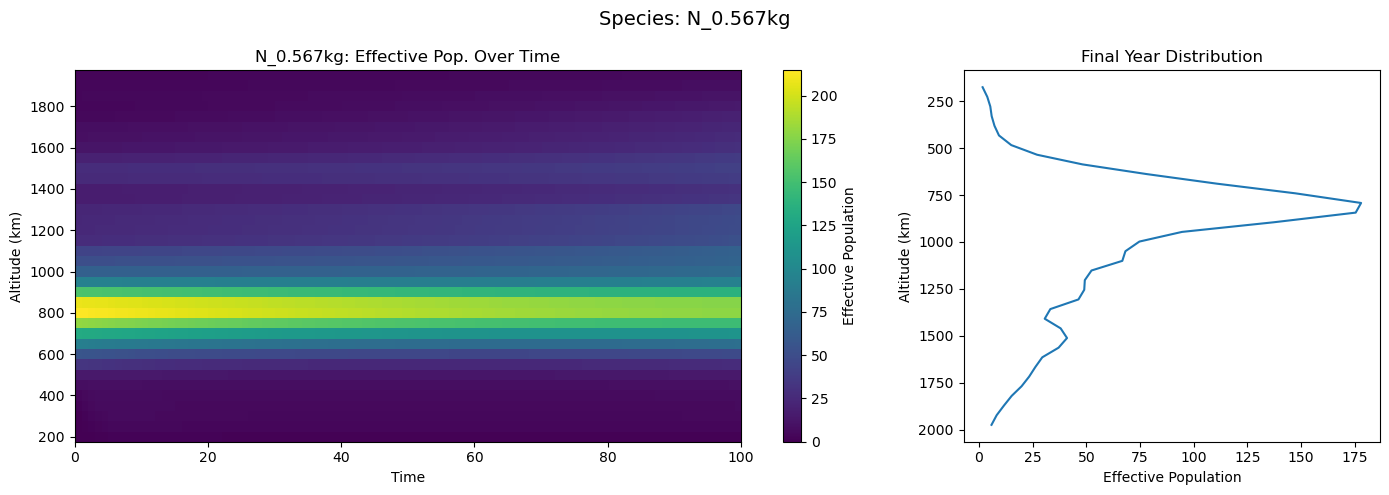

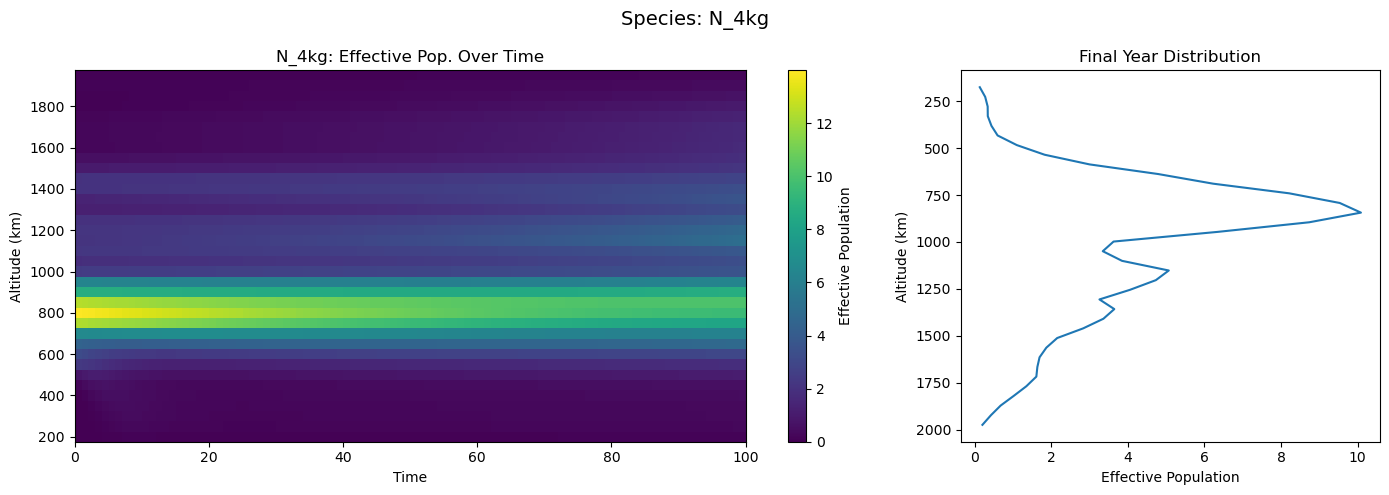

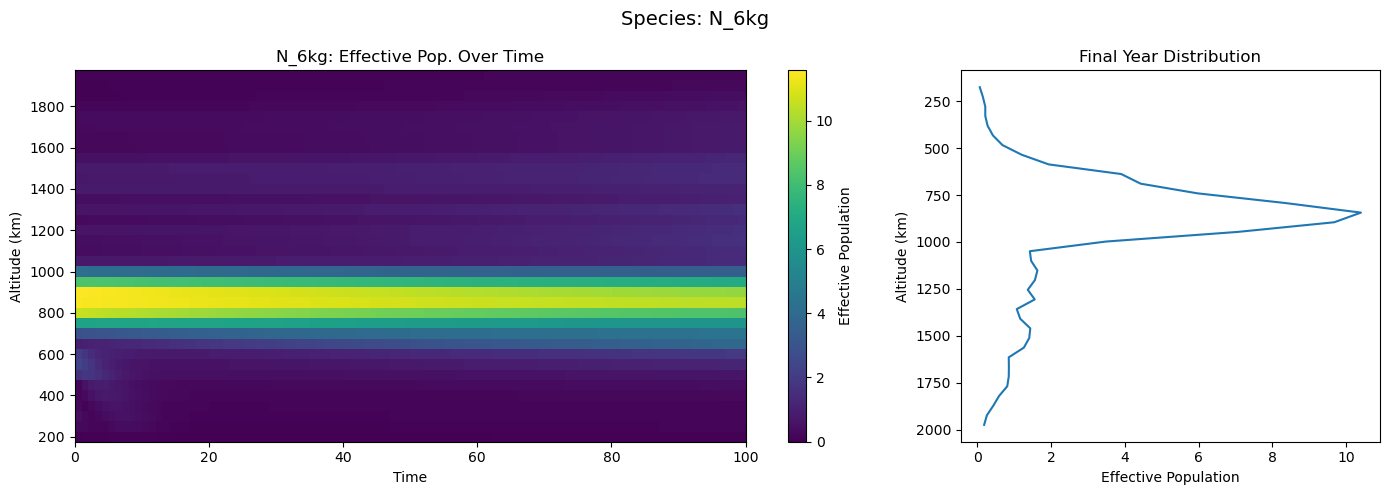

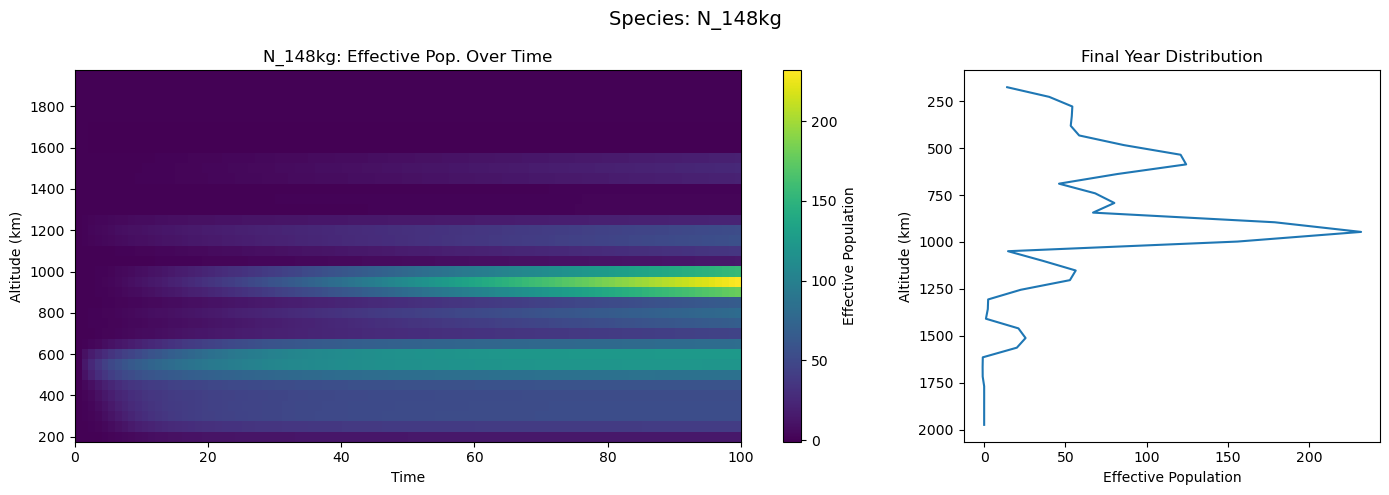

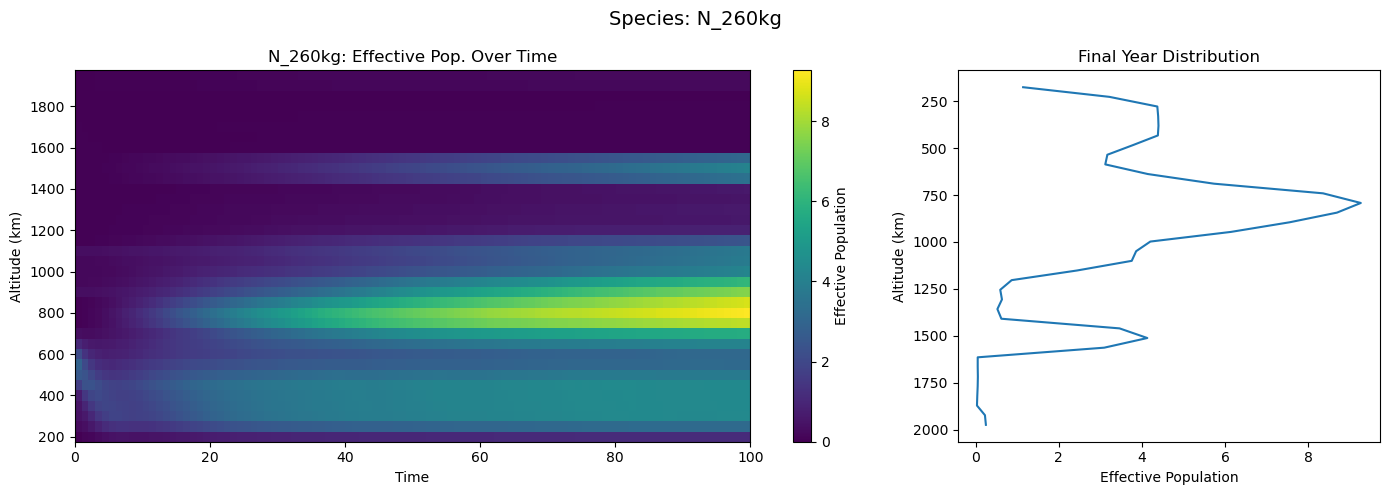

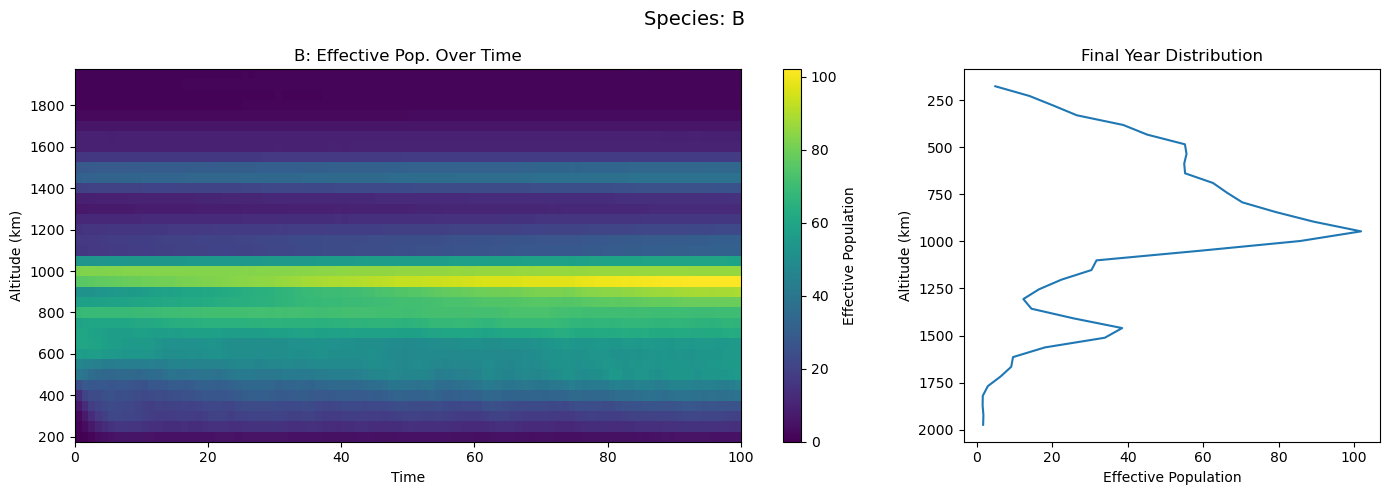

Saved total population over time to output_alt/pop_time.csv
Saved altitude-resolved population data to output_alt/pop_time_alt.csv


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- Scenario properties ---
start_year = 2025
simulation_name = 'test'
base_path = output_dir or f"figures/{simulation_name}"

# --- Dimensions ---
n_sma_bins    = scenario_properties.n_shells
n_alt_shells  = scenario_properties.n_shells
n_species     = scenario_properties.species_length
n_ecc_bins    = len(scenario_properties.eccentricity_bins) - 1
n_time        = scenario_properties.output.y.shape[1]
times         = scenario_properties.output.t
species_names = scenario_properties.species_names
altitudes     = scenario_properties.HMid  # Altitude midpoints

# --- Unpack population data ---
y = scenario_properties.output.y
x_matrix = y.reshape(n_sma_bins, n_species, n_ecc_bins, n_time)

# --- Prepare containers for CSV export ---
pop_time_rows     = []  # total pop per species & year
pop_time_alt_rows = []  # pop per species, year & altitude

# === Compute, plot, and collect data ===
for s in range(n_species):
    # Effective population over time (by altitude)
    n_eff_time = np.zeros((n_alt_shells, n_time))

    for t_idx, offset in enumerate(times):
        # Extract snapshot and project to altitude
        pop_snapshot = x_matrix[:, s, :, t_idx]               # (sma, ecc)
        pop_full     = np.zeros((n_sma_bins, n_species, n_ecc_bins))
        pop_full[:, s, :] = pop_snapshot

        alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(pop_full)
        n_eff_time[:, t_idx] = alt_proj[:, s]

        # Collect altitude-resolved rows
        year = int(start_year + offset)
        for alt_idx, alt in enumerate(altitudes):
            pop_time_alt_rows.append({
                "Species":    species_names[s],
                "Year":       year,
                "Altitude":   alt,
                "Population": alt_proj[alt_idx, s]
            })

    # Collect total-population rows
    for t_idx, offset in enumerate(times):
        year      = int(start_year + offset)
        total_pop = n_eff_time[:, t_idx].sum()
        pop_time_rows.append({
            "Species":    species_names[s],
            "Year":       year,
            "Population": total_pop
        })

    # --- Plotting: Heatmap + Final Distribution ---
    final_year_dist = n_eff_time[:, -1]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Heatmap
    im = axes[0].imshow(
        n_eff_time,
        aspect='auto',
        origin='lower',
        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
        cmap='viridis'
    )
    axes[0].set_title(f"{species_names[s]}: Effective Pop. Over Time")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Altitude (km)")
    plt.colorbar(im, ax=axes[0], label="Effective Population")

    # Right: Final year distribution
    axes[1].plot(final_year_dist, altitudes)
    axes[1].set_title("Final Year Distribution")
    axes[1].set_xlabel("Effective Population")
    axes[1].set_ylabel("Altitude (km)")
    axes[1].invert_yaxis()

    plt.suptitle(f"Species: {species_names[s]}", fontsize=14)
    plt.tight_layout()
    plt.show()

# === Export to CSV ===
# Total population per species over time
df_pop_time = pd.DataFrame(pop_time_rows)
df_pop_time = (
    df_pop_time
    .groupby(["Species", "Year"], as_index=False)
    .sum()
    .sort_values(["Species", "Year"])
    .reset_index(drop=True)
)
pop_time_path = os.path.join(base_path, "pop_time.csv")
df_pop_time.to_csv(pop_time_path, index=False)
print(f"Saved total population over time to {pop_time_path}")

# Altitude-resolved population per species over time
df_pop_time_alt = pd.DataFrame(pop_time_alt_rows)
df_pop_time_alt = (
    df_pop_time_alt
    .groupby(["Species", "Year", "Altitude"], as_index=False)
    .sum()
    .sort_values(["Species", "Year", "Altitude"])
    .reset_index(drop=True)
)
pop_time_alt_path = os.path.join(base_path, "pop_time_alt.csv")
df_pop_time_alt.to_csv(pop_time_alt_path, index=False)
print(f"Saved altitude-resolved population data to {pop_time_alt_path}")

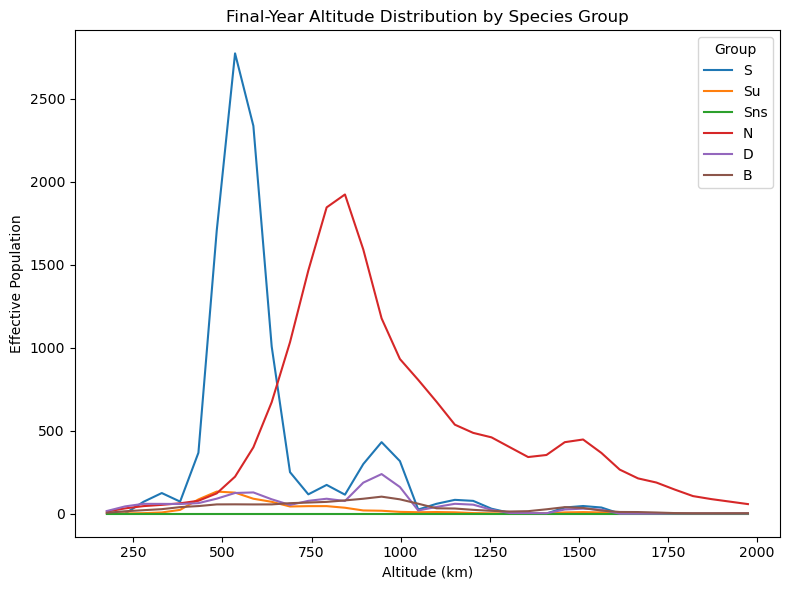

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions & data ---
n_sma_bins    = scenario_properties.n_shells
n_ecc_bins    = len(scenario_properties.eccentricity_bins) - 1
n_species     = scenario_properties.species_length
n_time        = scenario_properties.output.y.shape[1]
altitudes     = scenario_properties.HMid            # Altitude midpoints (km)
species_names = scenario_properties.species_names

# Final snapshot
y_final       = scenario_properties.output.y[:, -1]
x_final       = y_final.reshape((n_sma_bins, n_species, n_ecc_bins))
alt_proj_full = scenario_properties.sma_ecc_mat_to_altitude_mat(x_final)
# shape: (n_alt_shells, n_species)

# --- Group definitions ---
large_fragments = {'N_10kg', 'N_148kg', 'N_260kg', 'N_472kg', 'N_750kg', 'N_1250kg'}
group_indices = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N':   [i for i, sp in enumerate(species_names) 
            if sp.startswith('N') and sp not in large_fragments],
    'D':   [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp == 'B']
}

# --- Sum per group ---
group_alt_dists = {
    grp: alt_proj_full[:, idxs].sum(axis=1)
    for grp, idxs in group_indices.items()
}

# --- Plot with axes swapped ---
plt.figure(figsize=(8, 6))
for grp, dist in group_alt_dists.items():
    plt.plot(altitudes, dist, label=grp)

plt.ylabel("Effective Population")
plt.xlabel("Altitude (km)")
plt.title("Final‐Year Altitude Distribution by Species Group")
plt.legend(title="Group")
plt.tight_layout()
plt.show()

# Effective Altitude

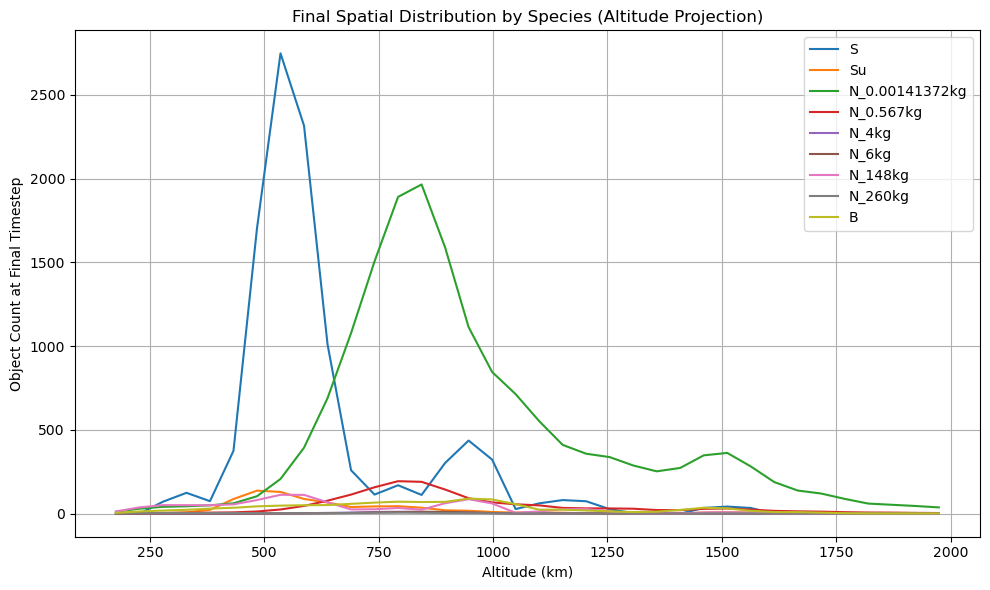

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack dimensions
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # shape: (n_shells,)
final_step_index = 40 # last times÷tep

# Extract final timestep and reshape
y = scenario_properties.output.y
y_final = y[:, final_step_index]  # shape: (n_sma_bins * n_species * n_ecc_bins,)

# Reshape to (sma, species, ecc)
x_matrix = y_final.reshape((n_sma_bins, n_species, n_ecc_bins))

# Project to altitude using provided method
x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)  # shape: (n_shells, n_species)

# === Plot: Total Altitude Distribution per Species ===
plt.figure(figsize=(10, 6))

for i in range(n_species):
    plt.plot(altitudes, x_alt[:, i], label=species_names[i])

plt.xlabel("Altitude (km)")
plt.ylabel("Object Count at Final Timestep")
plt.title("Final Spatial Distribution by Species (Altitude Projection)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

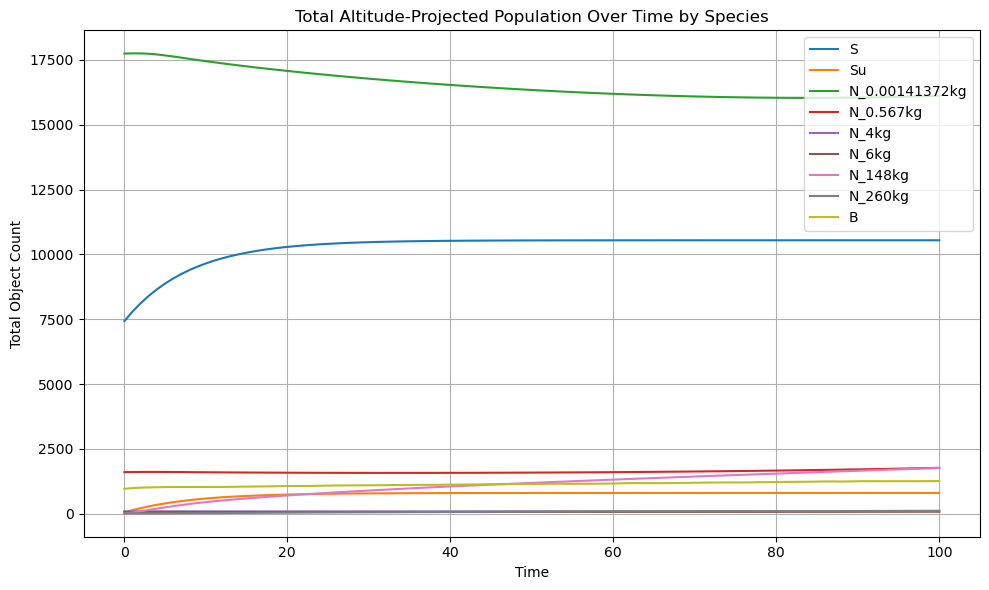

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # (n_shells,)
n_timesteps = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t  # shape: (n_timesteps,)

# --- Initialize storage ---
y = scenario_properties.output.y
species_totals_over_time = np.zeros((n_species, n_timesteps))  # shape: (species, time)

# --- Loop over each time step ---
for t_idx in range(n_timesteps):
    y_t = y[:, t_idx]  # shape: (n_sma_bins * n_species * n_ecc_bins,)
    x_matrix = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))  # reshape to (sma, species, ecc)
    x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)  # shape: (alt_shells, species)

    species_totals_over_time[:, t_idx] = np.sum(x_alt, axis=0)  # total per species

# --- Plot ---
plt.figure(figsize=(10, 6))
for i in range(n_species):
    plt.plot(times, species_totals_over_time[i], label=species_names[i])

plt.xlabel("Time")
plt.ylabel("Total Object Count")
plt.title("Total Altitude-Projected Population Over Time by Species")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# COMPARISON TO MC

## Initial Population

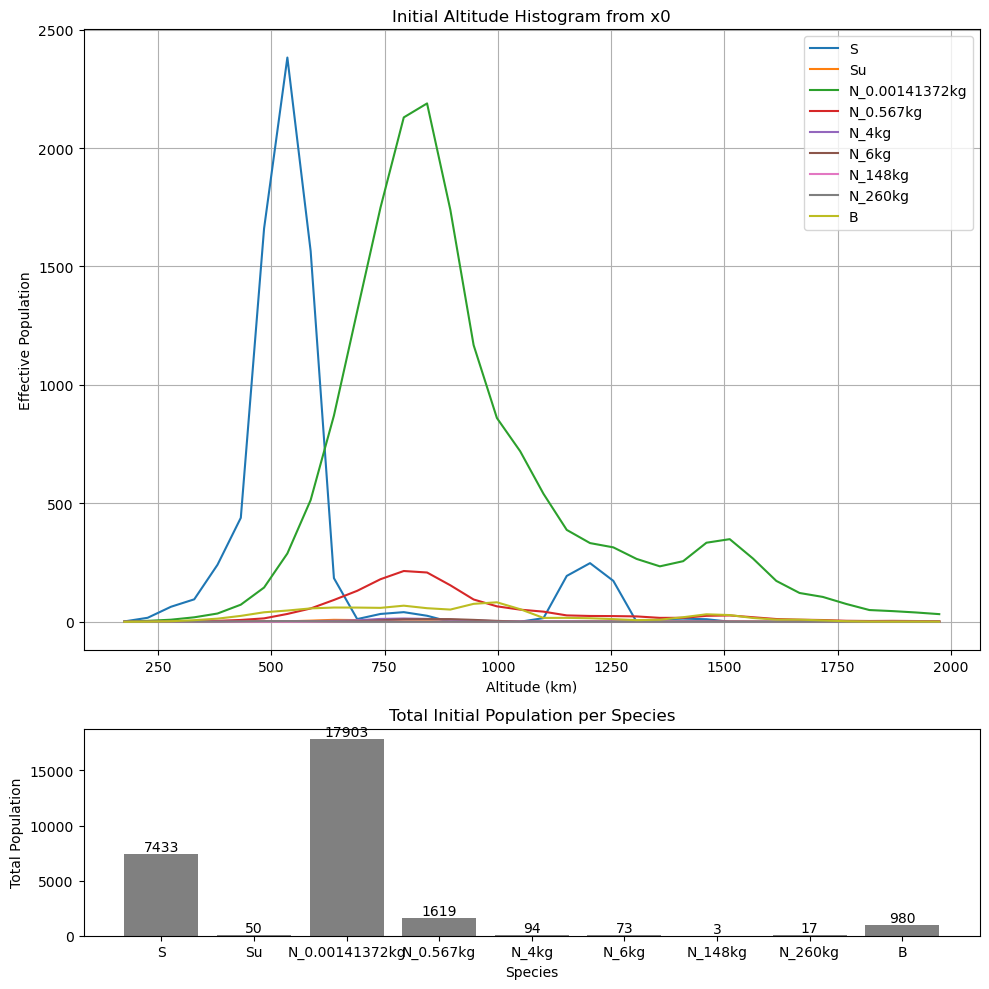

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack inputs
x0 = scenario_properties.x0  # shape: (sma, species, ecc)
TIS = scenario_properties.time_in_shell  # shape: (altitude, ecc, sma)
altitudes = scenario_properties.HMid  # length: n_alt_shells
species_names = scenario_properties.species_names

n_sma_bins, n_species, n_ecc_bins = x0.shape
n_alt_shells = TIS.shape[0]

# --- Calculate effective population in each altitude shell per species ---
effective_altitude_matrix = np.zeros((n_alt_shells, n_species))

for species in range(n_species):
    for alt_shell in range(n_alt_shells):
        total = 0.0
        for sma in range(n_sma_bins):
            for ecc in range(n_ecc_bins):
                n_pop = x0[sma, species, ecc]
                tis = TIS[alt_shell, ecc, sma]
                total += n_pop * tis
        effective_altitude_matrix[alt_shell, species] = total

# --- Calculate total initial population per species ---
total_species_population = x0.sum(axis=(0, 2))

# --- Plot Setup ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

# --- Plot: One line per species (Altitude distribution) ---
for s in range(n_species):
    ax1.plot(altitudes, effective_altitude_matrix[:, s], label=species_names[s])

ax1.set_xlabel("Altitude (km)")
ax1.set_ylabel("Effective Population")
ax1.set_title("Initial Altitude Histogram from x0")
ax1.legend()
ax1.grid(True)

# --- Histogram of total population per species ---
bars = ax2.bar(species_names, total_species_population, color='grey')

ax2.set_xlabel("Species")
ax2.set_ylabel("Total Population")
ax2.set_title("Total Initial Population per Species")

# --- Annotate actual numbers on bars ---
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [20]:
scenario_properties.x0[:, 1, :].sum()

50

## FLM Difference to MC

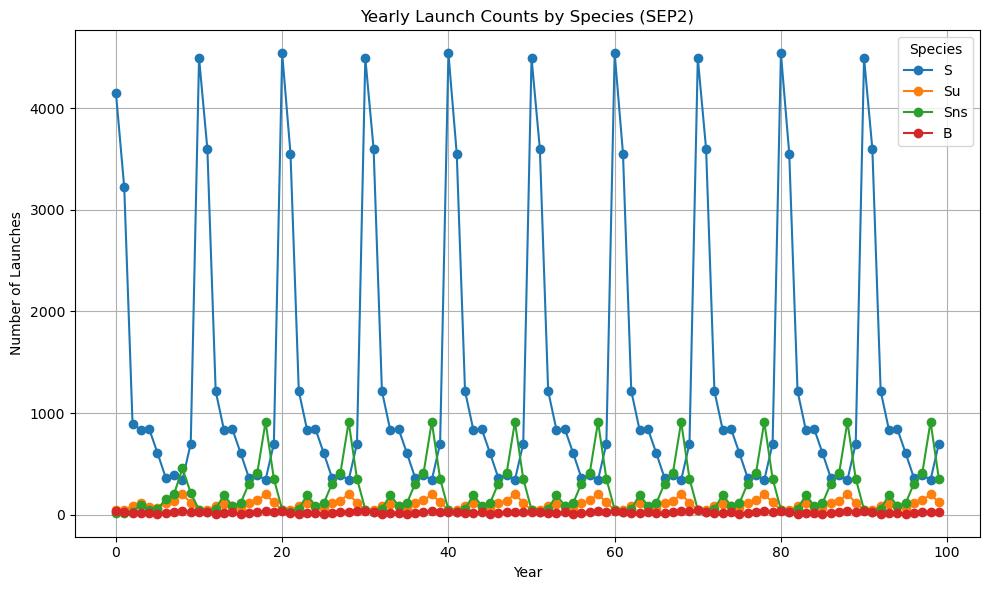

In [21]:
# Load CSV data
df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')

# Filter relevant species
species_of_interest = ['S', 'Su', 'Sns', 'B']
df_filtered = df[df['Species'].isin(species_of_interest)]

# Pivot table to have Years as index and Species as columns
pivot_df = df_filtered.pivot(index='Year', columns='Species', values='Launch_Count')

# Plot comparison
plt.figure(figsize=(10, 6))
for species in species_of_interest:
    if species in pivot_df:
        plt.plot(pivot_df.index, pivot_df[species], marker='o', label=species)

plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Yearly Launch Counts by Species (SEP2)')
plt.legend(title='Species')
plt.grid(True)
plt.tight_layout()
plt.show()

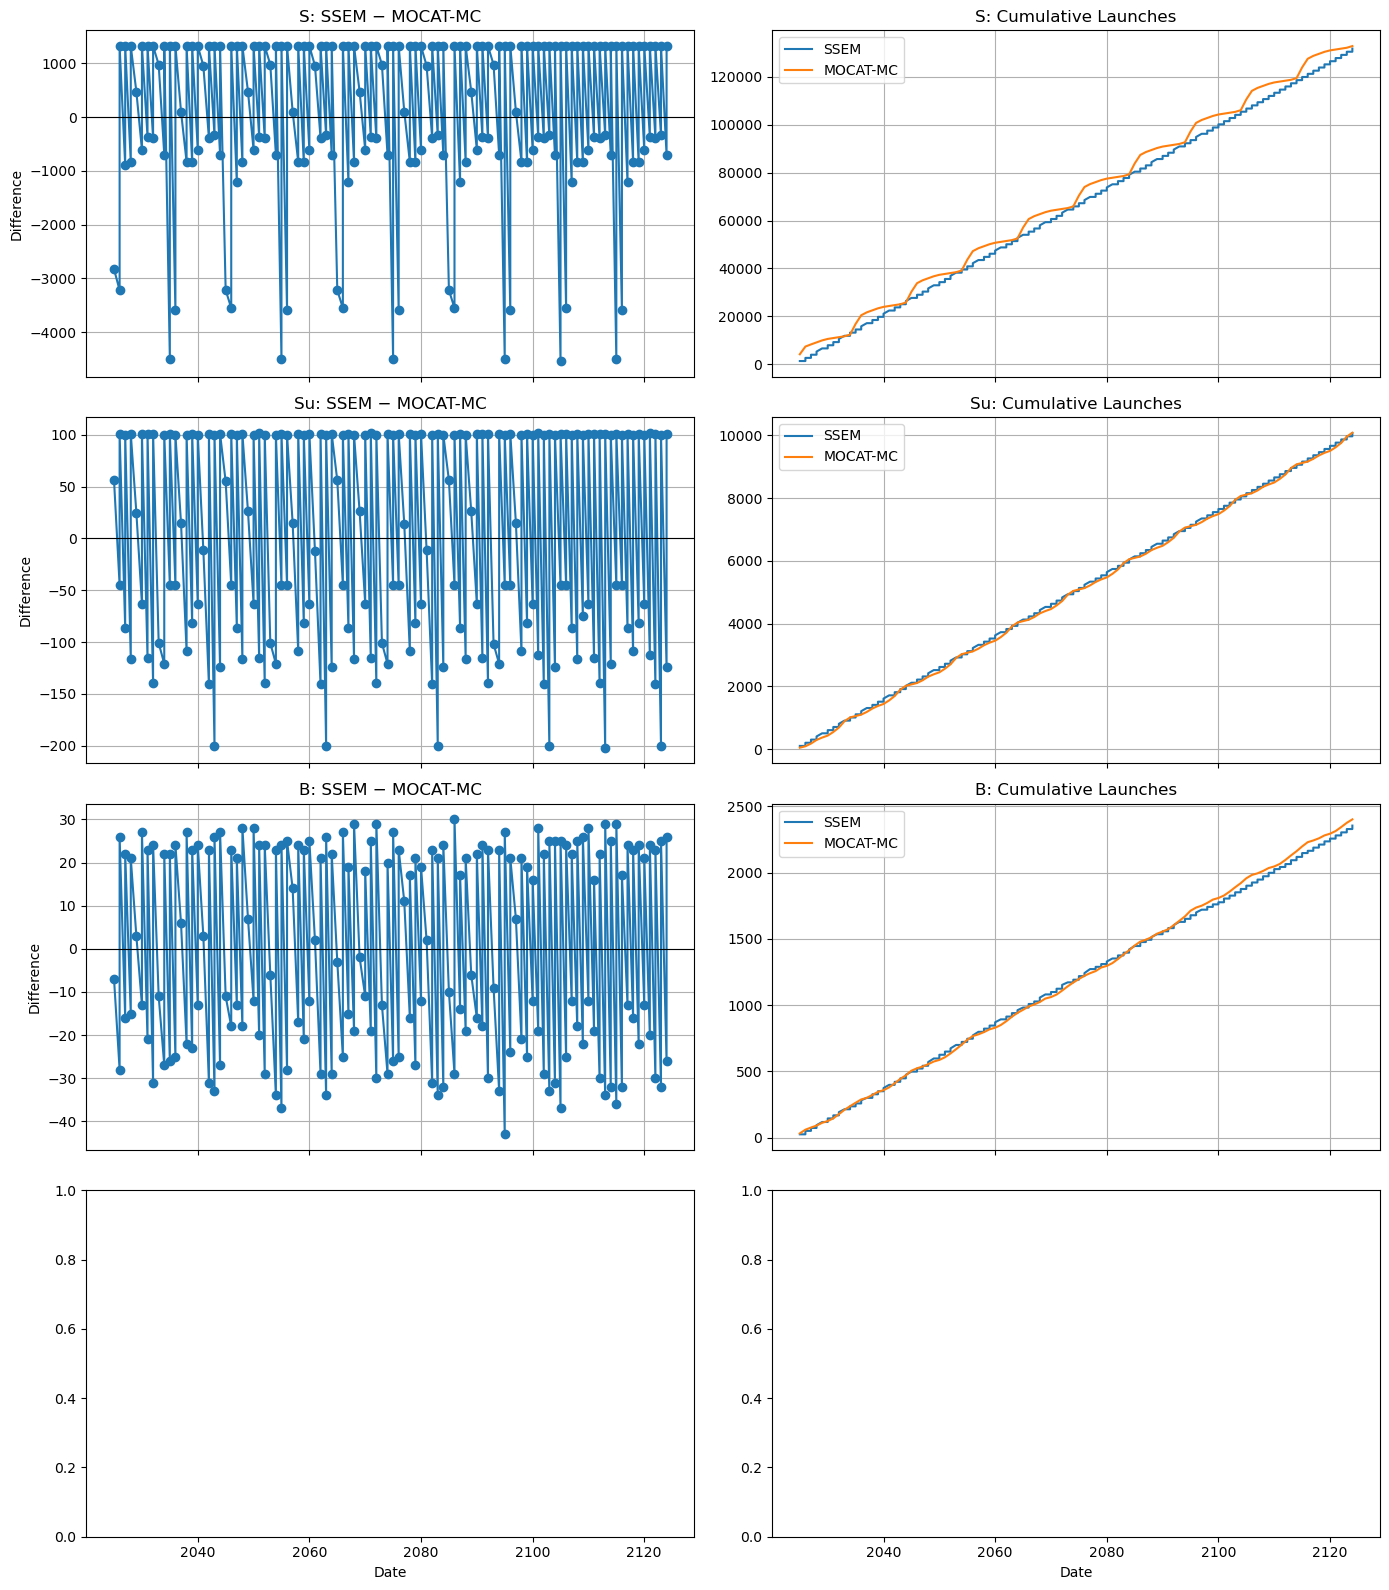

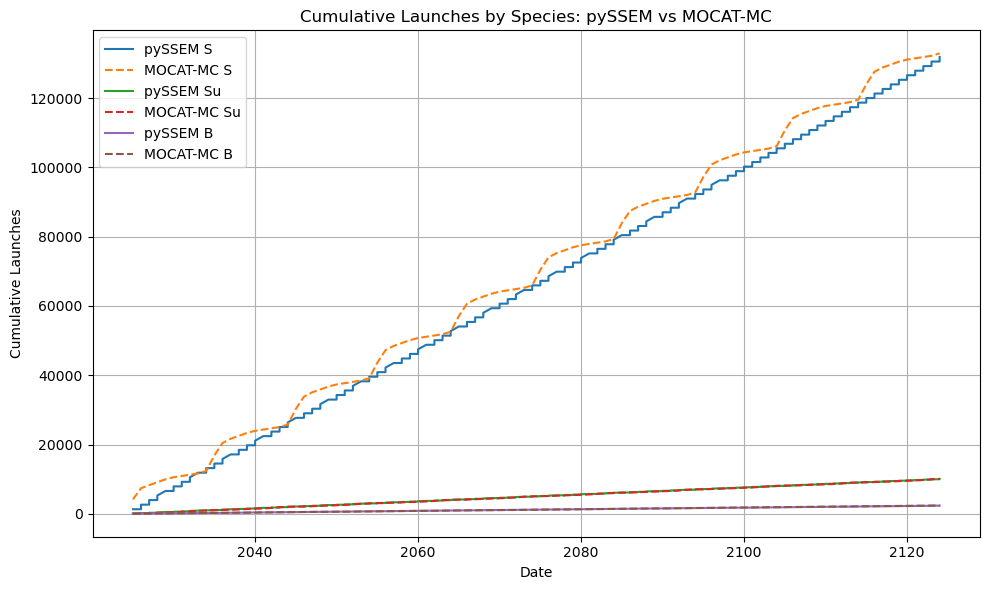

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# List of species
# target_species = ["S", "Sns", "Su", "B"]
target_species = ["S", "Su", "B"]


# --- pySSEM time series ---
pyss_df = (
    scenario_properties.FLM_steps
    .groupby("epoch_start_date")[target_species]
    .sum()
)
pyss_df.index = pd.to_datetime(pyss_df.index)

# --- MOCAT-MC (SEP2) time series ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_df['Date'] = pd.to_datetime(mc_df['Year'] + 2025, format='%Y')
mc_ts = (
    mc_df.pivot(index='Date', columns='Species', values='Launch_Count')
         .reindex(columns=target_species)
         .sort_index()
)

# --- Align both series on a common index ---
common_index = pyss_df.index.union(mc_ts.index)
pyss = pyss_df.reindex(common_index).fillna(0)
mc   = mc_ts.reindex(common_index).fillna(0)

# --- Compute difference and cumulative sums ---
diff = pyss - mc
cum_pyss = pyss.cumsum()
cum_mc   = mc.cumsum()

# --- Create 4x2 subplot grid ---
fig, axes = plt.subplots(4, 2, figsize=(14, 16), sharex=True)
for i, sp in enumerate(target_species):
    ax_diff = axes[i, 0]
    ax_cum  = axes[i, 1]
    
    # Difference plot
    ax_diff.plot(diff.index, diff[sp], marker='o')
    ax_diff.axhline(0, color='black', linewidth=0.8)
    ax_diff.set_title(f"{sp}: SSEM − MOCAT-MC")
    ax_diff.set_ylabel('Difference')
    ax_diff.grid(True)
    
    # Cumulative plot
    ax_cum.plot(cum_pyss.index, cum_pyss[sp],  label='SSEM')
    ax_cum.plot(cum_mc.index,   cum_mc[sp],   label='MOCAT-MC')
    ax_cum.set_title(f"{sp}: Cumulative Launches")
    ax_cum.legend()
    ax_cum.grid(True)

# Common X label
for ax in axes[-1, :]:
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

# --- Combined cumulative plot for all species ---
plt.figure(figsize=(10, 6))
for sp in target_species:
    plt.plot(cum_pyss.index, cum_pyss[sp],label=f"pySSEM {sp}")
    plt.plot(cum_mc.index,   cum_mc[sp],  linestyle='--', label=f"MOCAT-MC {sp}")

plt.xlabel('Date')
plt.ylabel('Cumulative Launches')
plt.title('Cumulative Launches by Species: pySSEM vs MOCAT-MC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


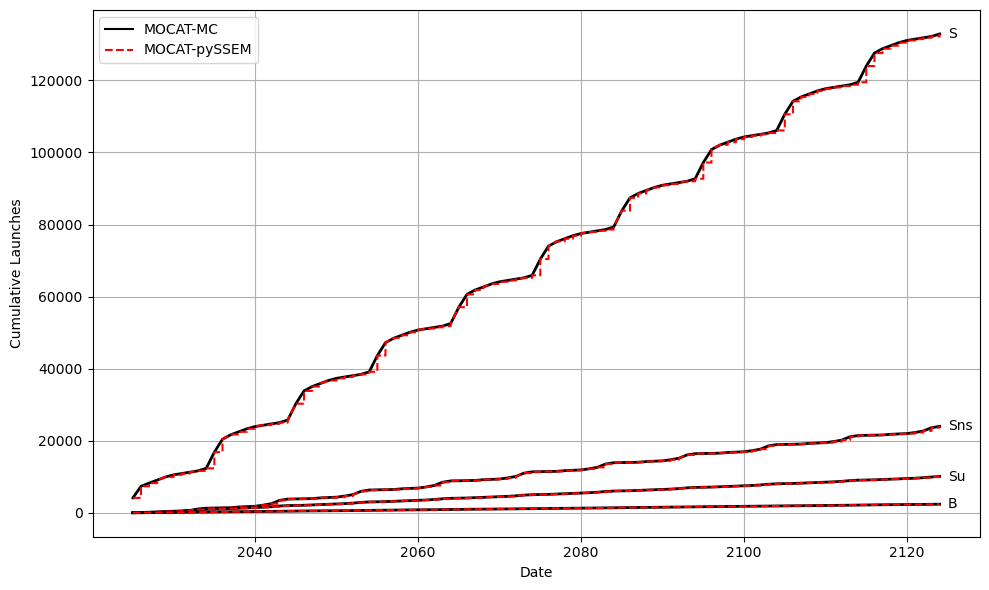

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# List of species
target_species = ["S", "Sns", "Su", "B"]

# --- pySSEM time series ---
pyss_df = (
    scenario_properties.FLM_steps
    .groupby("epoch_start_date")[target_species]
    .sum()
)
pyss_df.index = pd.to_datetime(pyss_df.index)

# --- MOCAT-MC (SEP2) time series ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_df['Date'] = pd.to_datetime(mc_df['Year'] + 2025, format='%Y')
mc_ts = (
    mc_df.pivot(index='Date', columns='Species', values='Launch_Count')
         .reindex(columns=target_species)
         .sort_index()
)

# --- Align both series ---
common_index = pyss_df.index.union(mc_ts.index)
pyss = pyss_df.reindex(common_index).fillna(0)
mc   = mc_ts.reindex(common_index).fillna(0)

# --- Compute cumulative sums ---
cum_pyss = pyss.cumsum()
cum_mc   = mc.cumsum()

# --- Combined cumulative plot ---
plt.figure(figsize=(10, 6))

# Model-level colors
py_color = 'red'
mc_color = 'black'

for sp in target_species:
    # MOCAT-MC solid thick
    plt.plot(cum_mc.index, cum_mc[sp],
             linestyle='-', linewidth = 2, color=mc_color)
        # pySSEM dashed
    plt.plot(cum_pyss.index, cum_pyss[sp],
             linestyle='--', color=py_color)

# Annotate species names at final point (using MOCAT-MC values)
x_last = cum_mc.index[-1] + pd.Timedelta(days=365)  # offset 1 year to the right
for sp in target_species:
    y_last = cum_mc[sp].iloc[-1]
    plt.text(x_last, y_last, sp, va='center')

# Legend with only model names
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color=mc_color, label='MOCAT-MC'),
    Line2D([0], [0], color=py_color, linestyle='--', label='MOCAT-pySSEM')
]
plt.legend(handles=legend_handles, loc='upper left')

plt.xlabel('Date')
plt.ylabel('Cumulative Launches')
# plt.title('Cumulative Launches by Species')
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
plt.show()

## Difference with Np.interp

In [ ]:
import pandas as pd

# List of species
target_species = ["S", "Sns", "Su", "B"]

# --- pySSEM time series ---
pyss_df = (
    scenario_properties.FLM_steps
    .groupby("epoch_start_date")[target_species]
    .sum()
)
pyss_df.index = pd.to_datetime(pyss_df.index)

# --- MOCAT-MC (SEP2) time series ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_df['Date'] = pd.to_datetime(mc_df['Year'] + 2025, format='%Y')
mc_ts = (
    mc_df.pivot(index='Date', columns='Species', values='Launch_Count')
         .reindex(columns=target_species)
         .sort_index()
)

# --- Align both series on a common index ---
common_index = pyss_df.index.union(mc_ts.index)
pyss = pyss_df.reindex(common_index).fillna(0)
mc   = mc_ts.reindex(common_index).fillna(0)

# --- Compute difference and cumulative sums by species ---
diff       = pyss - mc
cum_diff   = diff.cumsum()

# --- Total cumulative difference across species at each time ---
total_cum_diff = cum_diff.sum(axis=1)

# --- Final cumulative difference over entire scenario ---
final_diff = total_cum_diff.iloc[-1]
print(f"Cumulative difference (pySSEM − MOCAT-MC) at end of scenario: {final_diff}")

# Optional: cumulative difference time series
# total_cum_diff.plot(title='Total Cumulative Difference Over Time')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Difference')
# plt.grid(True)
# plt.show()

Cumulative difference (pySSEM − MOCAT-MC) at end of scenario: 27.0


# OVerall Population Difference SSEM/MC

In [18]:
scenario_properties.species_names

['S',
 'Su',
 'N_0.03225kg',
 'N_1.88299kg',
 'N_4kg',
 'N_6kg',
 'N_148kg',
 'N_260kg',
 'B_1011kg',
 'B_2023kg']

In [ ]:
specie

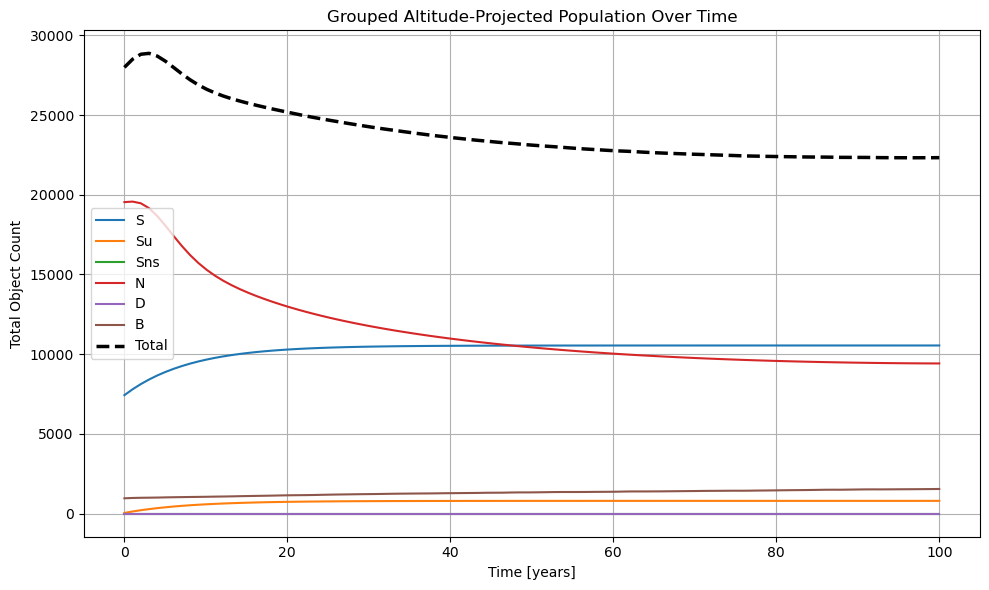

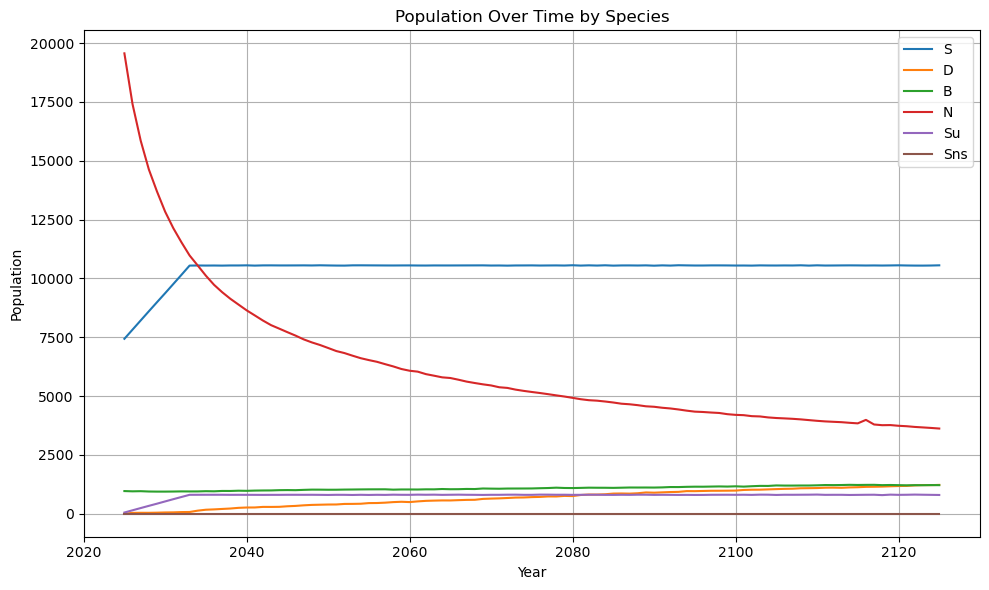

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid
n_timesteps = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t

# --- Initialize storage ---
y = scenario_properties.output.y
species_totals_over_time = np.zeros((n_species, n_timesteps))

# --- Project and sum over altitudes ---
for t_idx in range(n_timesteps):
    y_t = y[:, t_idx]
    x_matrix = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))
    x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)
    species_totals_over_time[:, t_idx] = np.sum(x_alt, axis=0)

# --- Define groupings ---
large_fragments = ['N_10kg', 'N_148kg', 'N_260kg', 'N_472kg', 'N_750kg', 'N_1250kg']
group_indices = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N': [i for i, sp in enumerate(species_names)
        if sp.startswith('N') and sp not in large_fragments],
    'D': [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp.startswith('B')]
}

# --- Compute grouped totals ---
group_totals = {group: np.sum(species_totals_over_time[indices], axis=0)
                for group, indices in group_indices.items()}

# --- Plot ---
plt.figure(figsize=(10, 6))
for group, values in group_totals.items():
    plt.plot(times, values, label=group)
plt.plot(times, np.sum(species_totals_over_time, axis=0), label="Total", linewidth=2.5, linestyle='--', color='black')

plt.xlabel("Time [years]")
plt.ylabel("Total Object Count")
plt.title("Grouped Altitude-Projected Population Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# load the MOCAT-MC data
import pandas as pd

mc_launch = '/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv'
mc_pop_time_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time.csv'
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'

mc_pop_time = pd.read_csv(mc_pop_time_path)

plt.figure(figsize=(10, 6))
for species in mc_pop_time["Species"].unique():
    species_df = mc_pop_time[mc_pop_time["Species"] == species]
    plt.plot(species_df["Year"], species_df["Population"], label=species)

plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Population Over Time by Species")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
plt.show()

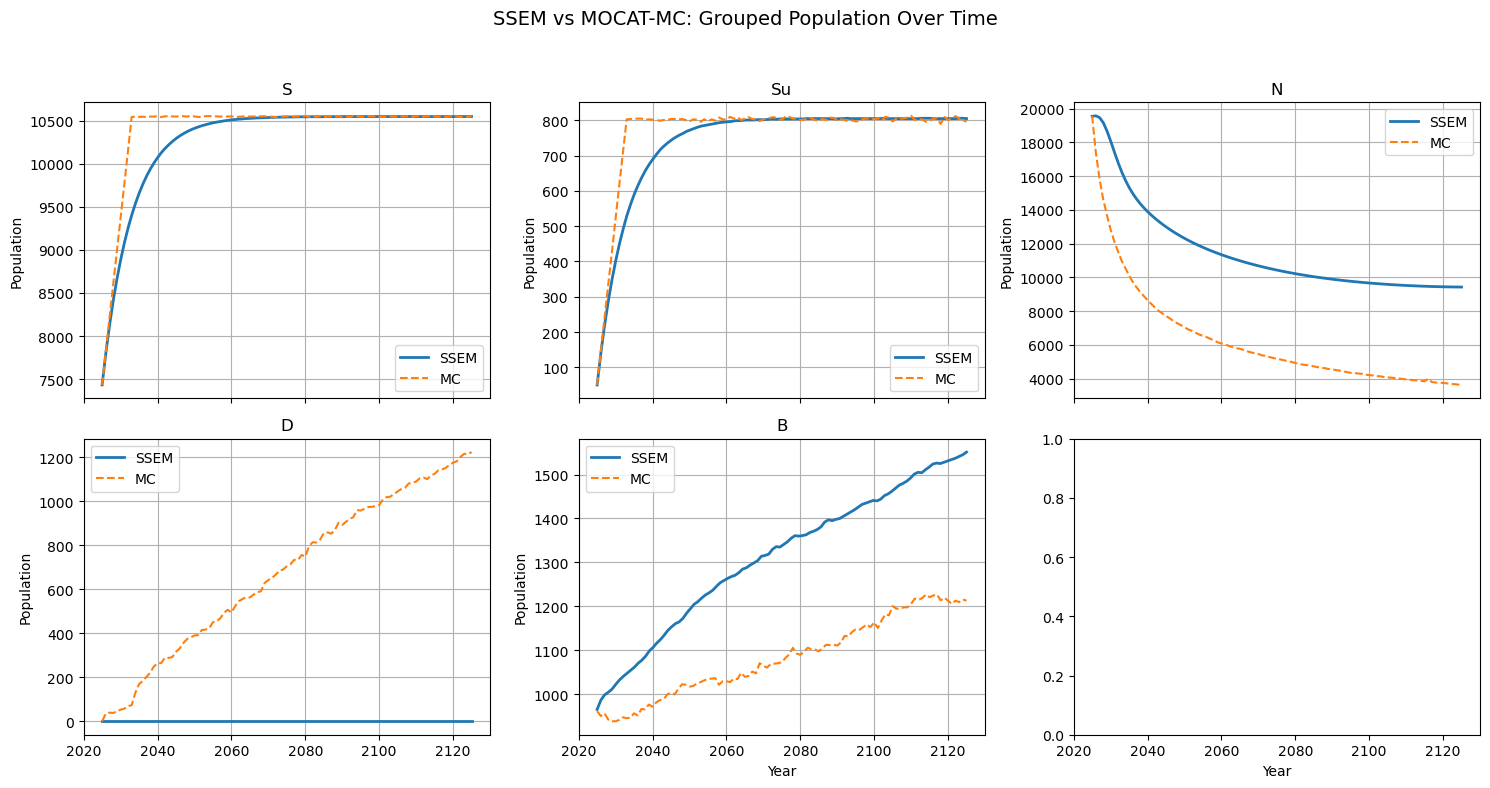

In [10]:
import matplotlib.pyplot as plt

# --- Species groups to compare ---
# species_groups = ['S', 'Su', 'Sns', 'N', 'D_S', 'D_Su', 'D_Sns', 'B', 'D']
species_groups = ['S', 'Su',  'N', 'D', 'B']
n_rows, n_cols = 2, 3

start_year = 2025  # Or derive from scenario_properties.start_date
ssem_years = times + start_year

# --- Create subplot grid ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharex=True)
axes = axes.flatten()

for idx, group in enumerate(species_groups):
    ax = axes[idx]
    
    # Plot SSEM
    if group in group_totals:
        ax.plot(ssem_years, group_totals[group].round(), label='SSEM', linewidth=2)

    # Plot MOCAT-MC
    if group in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == group]
        ax.plot(mc_df["Year"], mc_df["Population"], '--', label='MC', linewidth=1.5)

    ax.set_title(group)
    ax.set_ylabel("Population")
    ax.grid(True)
    ax.legend()

# Add shared X labels
axes[-2].set_xlabel("Year")
axes[-1].set_xlabel("Year")

plt.suptitle("SSEM vs MOCAT-MC: Grouped Population Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.ticklabel_format(useOffset=False, axis='y')
# plt.xlim(2025,2045)
plt.show()

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_906/4092129622.py:31: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = ssem_df.merge(mc_df, on="Year", how="inner")
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_906/4092129622.py:31: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = ssem_df.merge(mc_df, on="Year", how="inner")
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_906/4092129622.py:31: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = ssem_df.merge(mc_df, on="Year", how="inner")


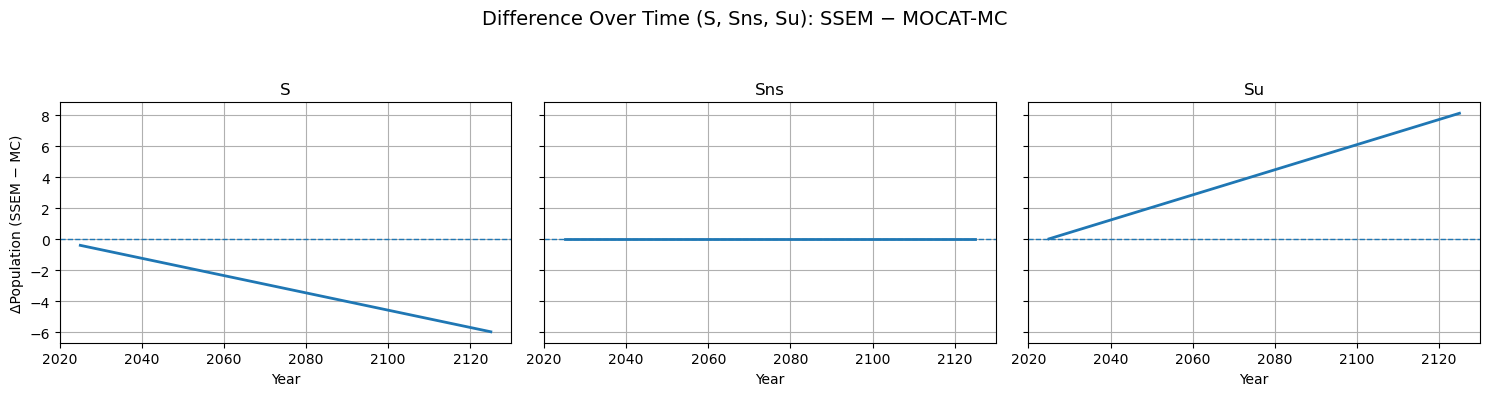

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

diff_groups = ['S', 'Sns', 'Su']
fig_diff, axes_diff = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

for i, grp in enumerate(diff_groups):
    ax = axes_diff[i]

    if (grp in group_totals) and (grp in mc_pop_time["Species"].unique()):
        # Build SSEM dataframe
        ssem_df = pd.DataFrame({
            "Year": ssem_years,
            "SSEM": np.asarray(group_totals[grp], float)
        })

        # Build MC dataframe (dedupe by Year)
        mc_df = (mc_pop_time[mc_pop_time["Species"] == grp][["Year", "Population"]]
                 .rename(columns={"Population": "MC"})
                 .sort_values("Year")
                 .drop_duplicates(subset="Year", keep="last"))

        # If both are effectively integers, align on int years (optional convenience)
        if np.allclose(ssem_df["Year"].values, np.round(ssem_df["Year"].values)):
            ssem_df["Year"] = ssem_df["Year"].round().astype(int)
        if np.issubdtype(mc_df["Year"].dtype, np.floating) and np.allclose(mc_df["Year"], np.round(mc_df["Year"])):
            mc_df["Year"] = mc_df["Year"].round().astype(int)

        # Strict overlap only
        merged = ssem_df.merge(mc_df, on="Year", how="inner")

        if merged.empty:
            ax.set_title(f"{grp} (no overlapping years)")
            ax.grid(True)
            continue

        diff = merged["SSEM"] - merged["MC"]
        ax.plot(merged["Year"], diff, linewidth=2)
        ax.axhline(0, linestyle='--', linewidth=1)
        ax.set_title(grp)
        ax.grid(True)
    else:
        ax.set_title(f"{grp} (no data)")
        ax.grid(True)

axes_diff[0].set_ylabel("ΔPopulation (SSEM − MC)")
for ax in axes_diff:
    ax.set_xlabel("Year")

fig_diff.suptitle("Difference Over Time (S, Sns, Su): SSEM − MOCAT-MC", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

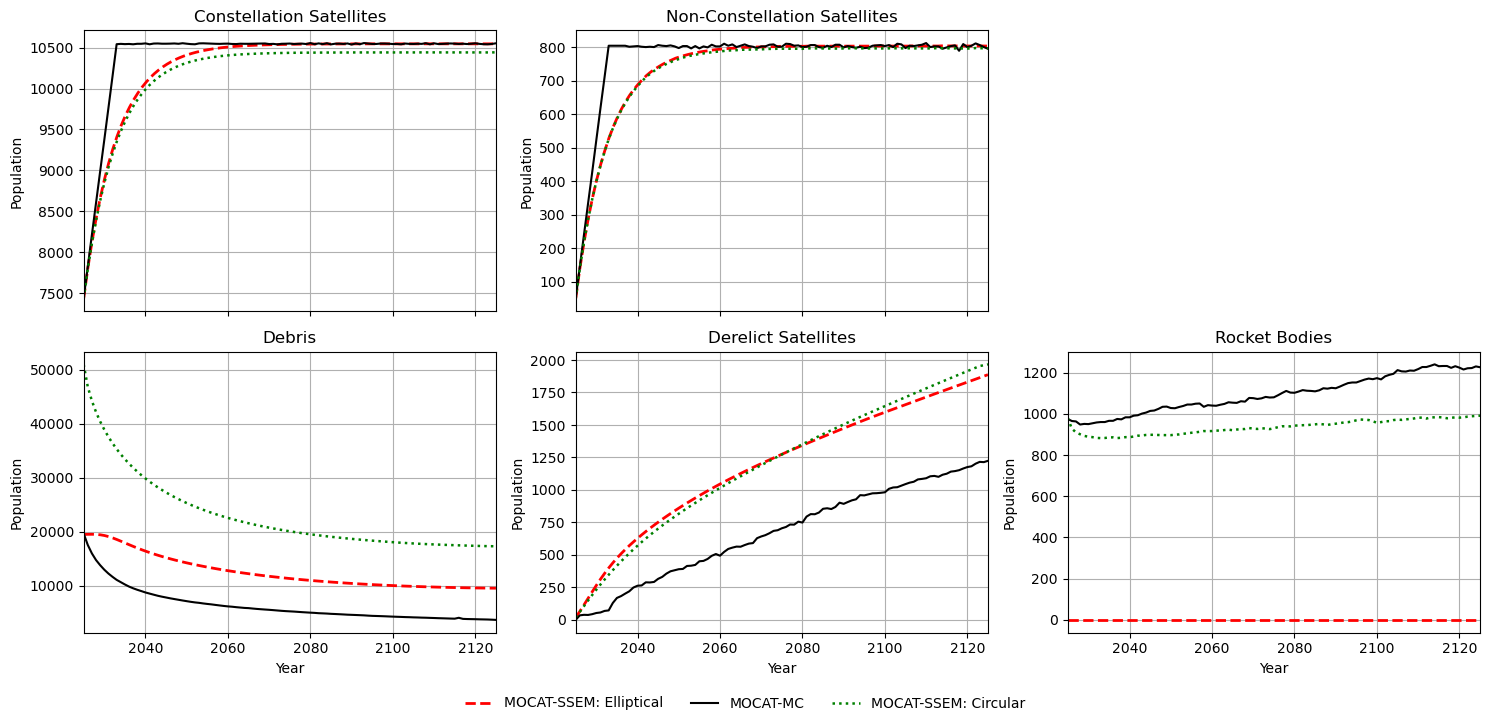

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load third dataset: SSEM-Old ---
ssem_old_path = "/Users/indigobrownhall/Code/pyssem/figures/Elliptical-circular-test/pop_time.csv"
df_ssem_old = pd.read_csv(ssem_old_path)
df_ssem_old = df_ssem_old[df_ssem_old["Year"] <= 2125]

species_groups = ['S', 'Su', 'N', 'D', 'B']

# --- Time adjustment for SSEM (assumes you have `times` and `group_totals` defined) ---
start_year = 2025
times = scenario_properties.output.t
ssem_years = times + start_year

# Layout:
# Row 1: S | Su | (blank)
# Row 2: N | D  | B
layout = [
    ['S', 'Su', '.'],
    ['N', 'D',  'B'],
]

fig, axd = plt.subplot_mosaic(layout, figsize=(15, 8), sharex=True)

title_map = {
    'S':  'Constellation Satellites',
    'Su': 'Non-Constellation Satellites',
    'D':  'Derelict Satellites',
    'N':  'Debris',
    'B':  'Rocket Bodies',
}

# --- Plot each group in its designated axis ---
for key in ['S', 'Su', 'N', 'D', 'B']:
    ax = axd[key]

    # SSEM (new)
    if key in group_totals:
        ax.plot(ssem_years, group_totals[key],
                '--', label='MOCAT-SSEM: Elliptical', linewidth=2, color='red')

    # MC
    if key in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == key]
        ax.plot(mc_df["Year"], mc_df["Population"],
                '-', label='MOCAT-MC', linewidth=1.5, color='black')

    # SSEM-Old
    if key in df_ssem_old["Species"].unique():
        old_df = df_ssem_old[df_ssem_old["Species"] == key]
        ax.plot(old_df["Year"], old_df["Population"],
                ':', label='MOCAT-SSEM: Circular', color='green', linewidth=1.8)

    ax.set_title(title_map.get(key, key))
    ax.set_ylabel("Population")
    ax.grid(True)

# Shared X labels on bottom row axes only
for key in ['N', 'D', 'B']:
    axd[key].set_xlabel("Year")

# Tight layout with space for legend
plt.tight_layout(rect=[0, 0.08, 1, 0.95])

# Collect legend entries from all visible axes
handles, labels = [], []
for ax in axd.values():
    h, l = ax.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in labels:
            handles.append(hh)
            labels.append(ll)

# Single legend at the bottom
if labels:
    fig.legend(handles, labels,
               loc='lower center',
               ncol=len(labels),
               frameon=False,
               bbox_to_anchor=(0.5, 0.04))

# Set x-limits on all visible axes
for ax in axd.values():
    ax.set_xlim(2025, 2125)

plt.show()

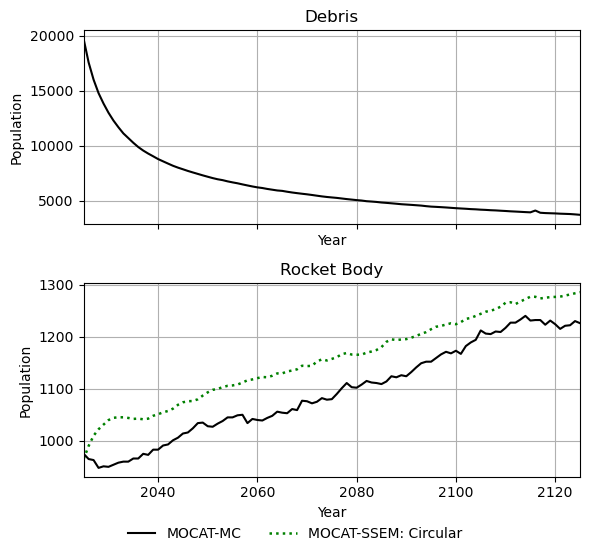

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load third dataset: SSEM-Old ---
ssem_old_path = "/Users/indigobrownhall/Code/pyssem/figures/Elliptical-SEP1-Circular/pop_time.csv"
df_ssem_old = pd.read_csv(ssem_old_path)
df_ssem_old = df_ssem_old[df_ssem_old["Year"] <= 2125]

# species_groups = ['S', 'Su', 'Sns', 'N', 'D', 'B']
species_groups = ['N', 'B']
n_rows, n_cols = 2, 1

# --- Time adjustment for SSEM (assumes you have `times` and `group_totals` defined) ---
start_year = 2025
ssem_years = times + start_year

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6), sharex=True)
axes = axes.flatten()

for idx, group in enumerate(species_groups):
    ax = axes[idx]
    
    # # Plot SSEM (new)
    # if group in group_totals:
    #     ax.plot(ssem_years, group_totals[group],
    #             '--',
    #             label='MOCAT-SSEM: Elliptical', linewidth=2)

    # Plot MC
    if group in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == group]
        ax.plot(mc_df["Year"], mc_df["Population"],
                '-', label='MOCAT-MC', linewidth=1.5, color='black')

    # Plot SSEM-Old
    if group in df_ssem_old["Species"].unique():
        old_df = df_ssem_old[df_ssem_old["Species"] == group]
        ax.plot(old_df["Year"], old_df["Population"], 
                ':', label='MOCAT-SSEM: Circular', color='green', linewidth=1.8)

    if group == 'N':
        ax.set_title("Debris")
    if group == 'B':
        ax.set_title("Rocket Body")
    ax.set_ylabel("Population")
    ax.grid(True)
    # DON'T call ax.legend() here!

# Shared X labels
axes[-2].set_xlabel("Year")
axes[-1].set_xlabel("Year")

# Adjust layout so there's room at the bottom for the legend
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Collect all handles & labels from all axes
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:          # avoid duplicates
            handles.append(h)
            labels.append(l)

# Single legend at the bottom, one row
fig.legend(handles, labels,
           loc='lower center',
           ncol=len(labels),
           frameon=False,
           bbox_to_anchor=(0.5, 0.02))

# Set x-limits and show
plt.xlim(2025, 2125)
plt.show()

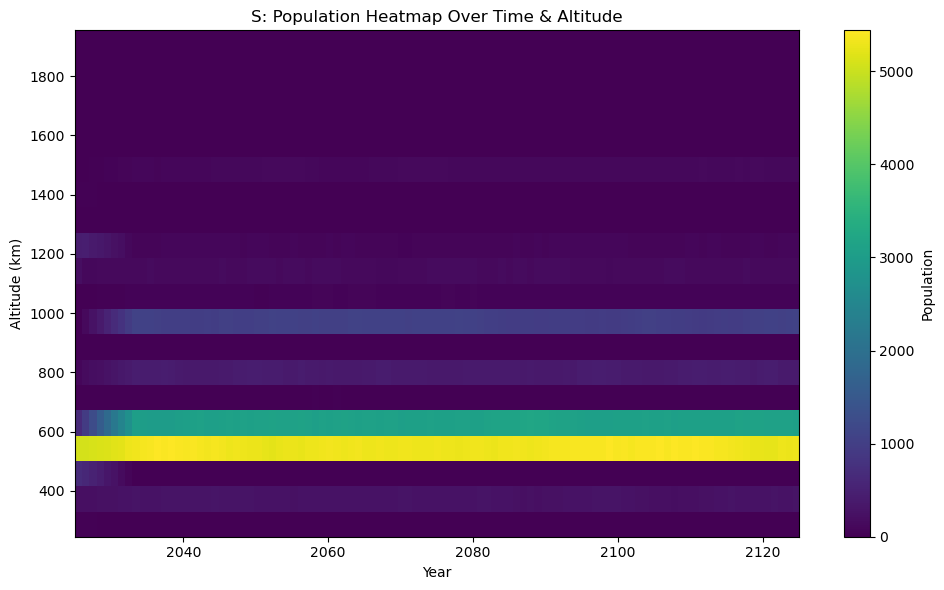

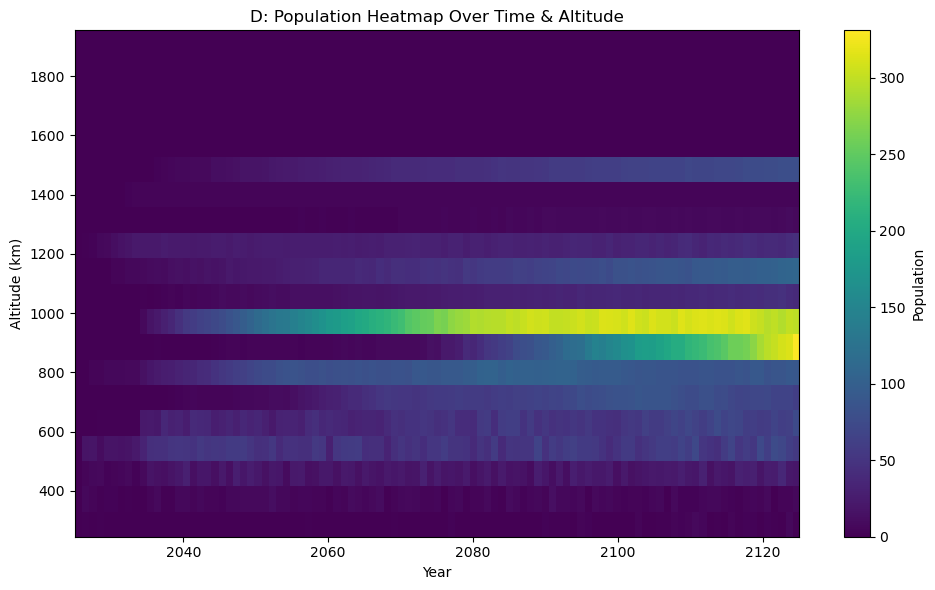

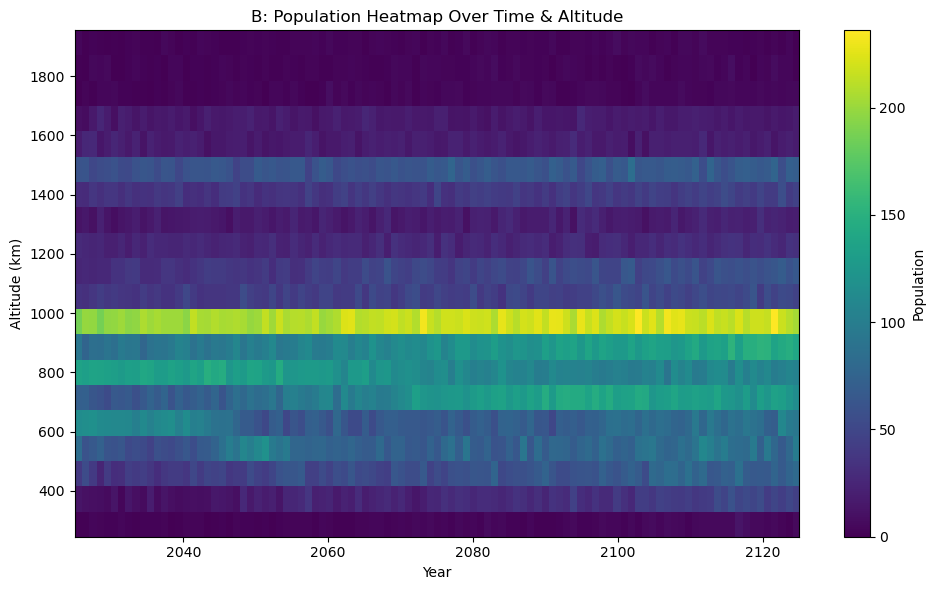

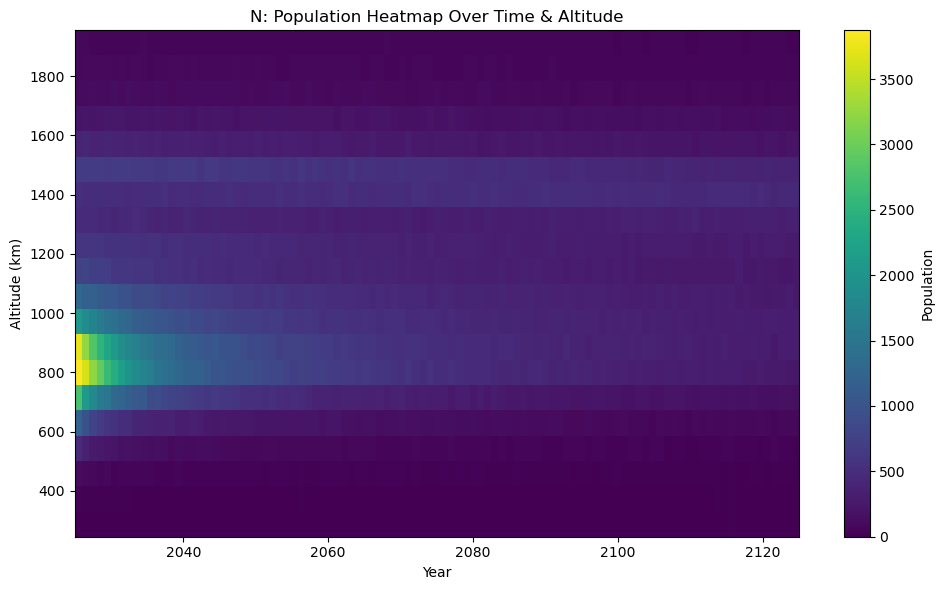

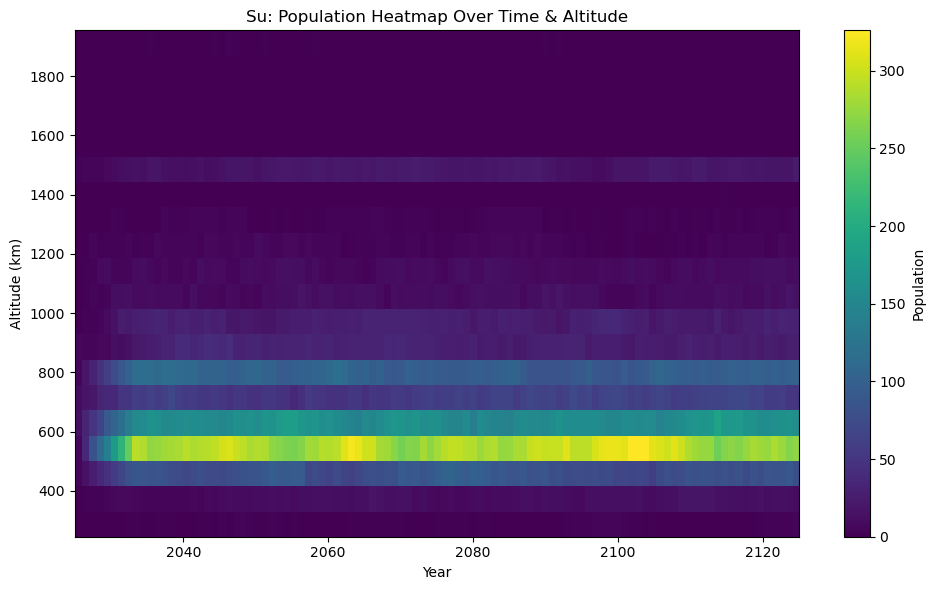

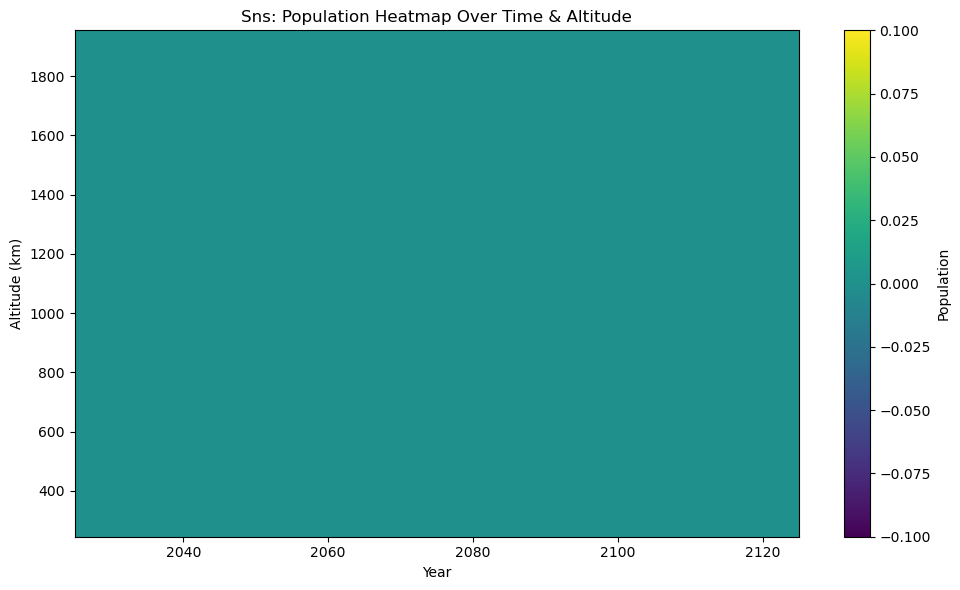

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Path to your altitude‐time data (make sure this points to your correct file)
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'

# --- Load the data ---
df = pd.read_csv(mc_pop_time_alt_path)

# --- For each species, pivot into (altitude × year) and plot ---
for species in df["Species"].unique():
    sp_df = df[df["Species"] == species]
    
    # Create a pivot table: rows=Altitude, cols=Year, values=Population
    pivot = sp_df.pivot(index="Altitude", columns="Year", values="Population")
    
    # Extract sorted axes
    altitudes = pivot.index.values
    years     = pivot.columns.values
    data      = pivot.values  # shape (n_altitude_bins, n_years)
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    im = plt.imshow(
        data,
        aspect='auto',
        origin='lower',
        extent=[years.min(), years.max(), altitudes.min(), altitudes.max()],
        cmap='viridis'
    )
    plt.title(f"{species}: Population Heatmap Over Time & Altitude")
    plt.xlabel("Year")
    plt.ylabel("Altitude (km)")
    plt.colorbar(im, label="Population")
    plt.tight_layout()
    plt.show()

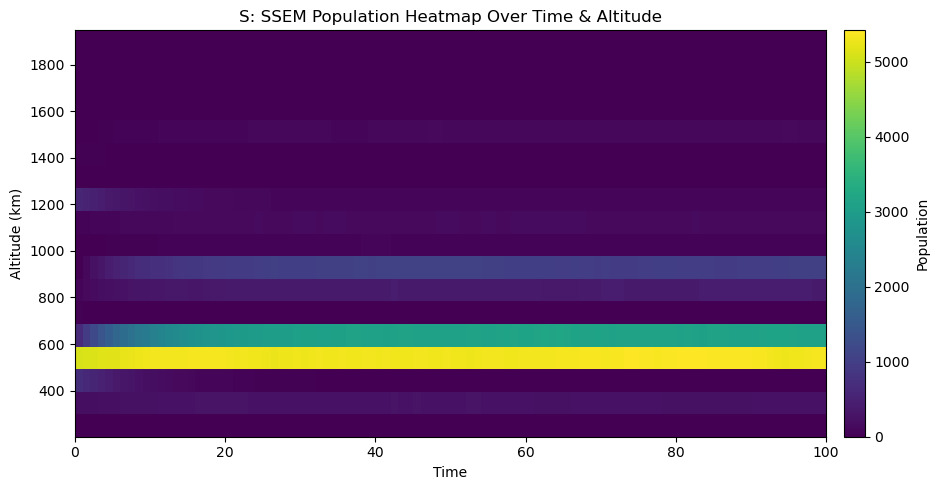

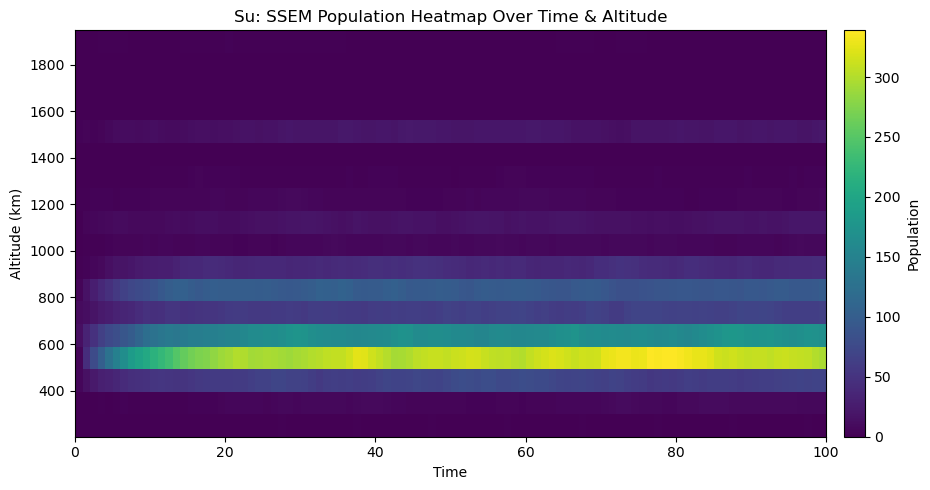

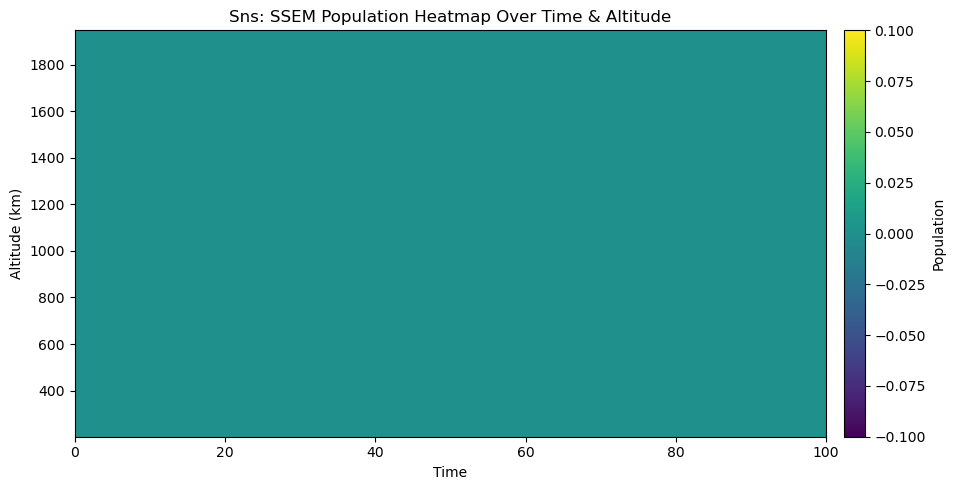

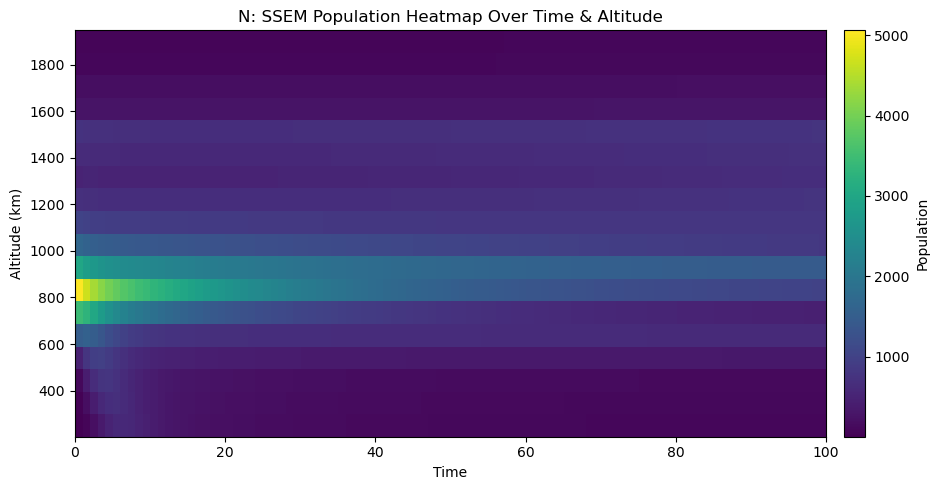

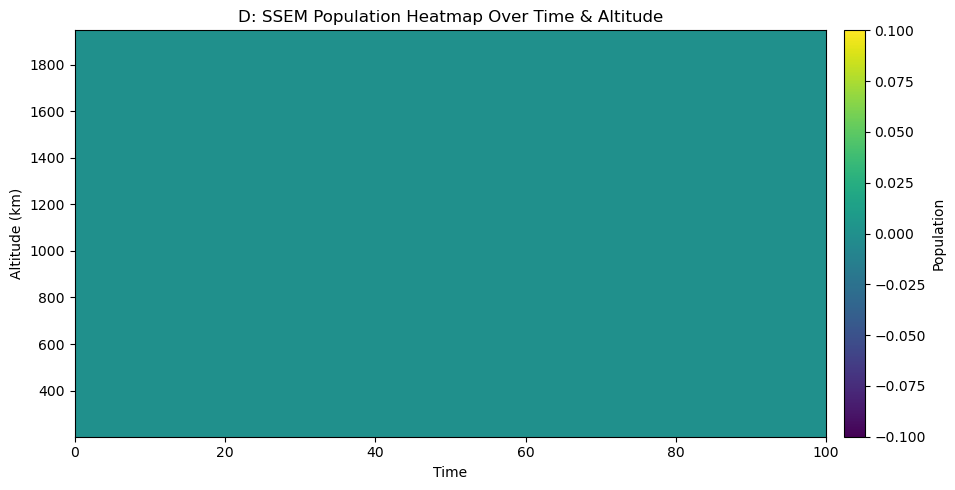

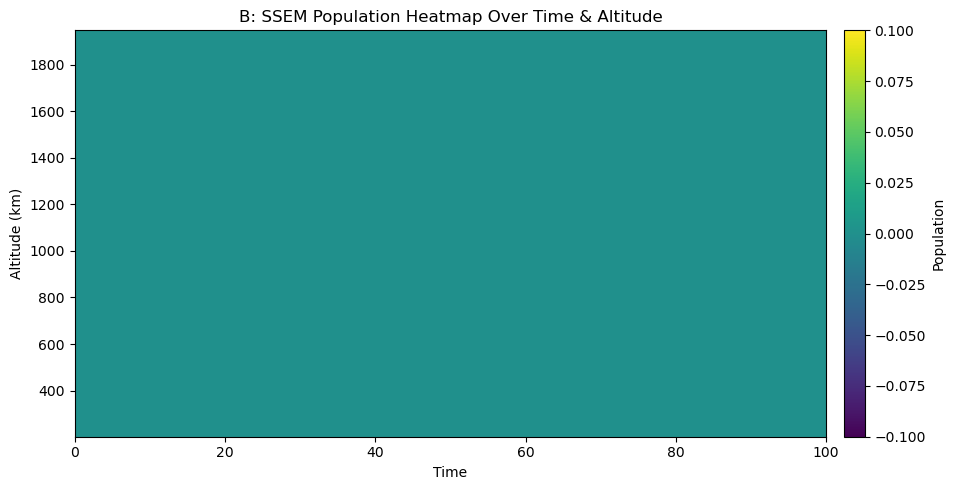

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions & data (SSEM) ---
n_sma_bins    = scenario_properties.n_shells
n_ecc_bins    = len(scenario_properties.eccentricity_bins) - 1
n_species     = scenario_properties.species_length
n_time        = scenario_properties.output.y.shape[1]
times         = scenario_properties.output.t
altitudes     = scenario_properties.HMid            # Altitude midpoints (km)
species_names = scenario_properties.species_names

# --- Define your “main‐species” groupings ---
large_fragments = ['N_10kg', 'N_148kg', 'N_260kg', 'N_472kg', 'N_750kg', 'N_1250kg']
group_indices = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N':   [i for i, sp in enumerate(species_names)
            if sp.startswith('N') and sp not in large_fragments],
    'D':   [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp == 'B']
}

# --- Preallocate storage: one alt×time matrix per group ---
group_n_eff_time = {
    grp: np.zeros((len(altitudes), n_time))
    for grp in group_indices
}

# --- Fill in each group's matrix over time ---
for t in range(n_time):
    # reshape the population vector at time t
    y_t      = scenario_properties.output.y[:, t]
    x_matrix = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))
    
    # project to altitude shells: shape (n_alt_shells, n_species)
    alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)
    
    # sum across species for each group
    for grp, idxs in group_indices.items():
        # sum the columns corresponding to this group's species
        group_n_eff_time[grp][:, t] = alt_proj[:, idxs].sum(axis=1)

# --- Plot heatmap per group ---
for grp, data in group_n_eff_time.items():
    plt.figure(figsize=(10, 5))
    im = plt.imshow(
        data,
        aspect='auto',
        origin='lower',
        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
        cmap='viridis'
    )
    plt.title(f"{grp}: SSEM Population Heatmap Over Time & Altitude")
    plt.xlabel("Time")
    plt.ylabel("Altitude (km)")
    cbar = plt.colorbar(im, pad=0.02)
    cbar.set_label("Population")
    plt.tight_layout()
    plt.show()

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_49789/675151533.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


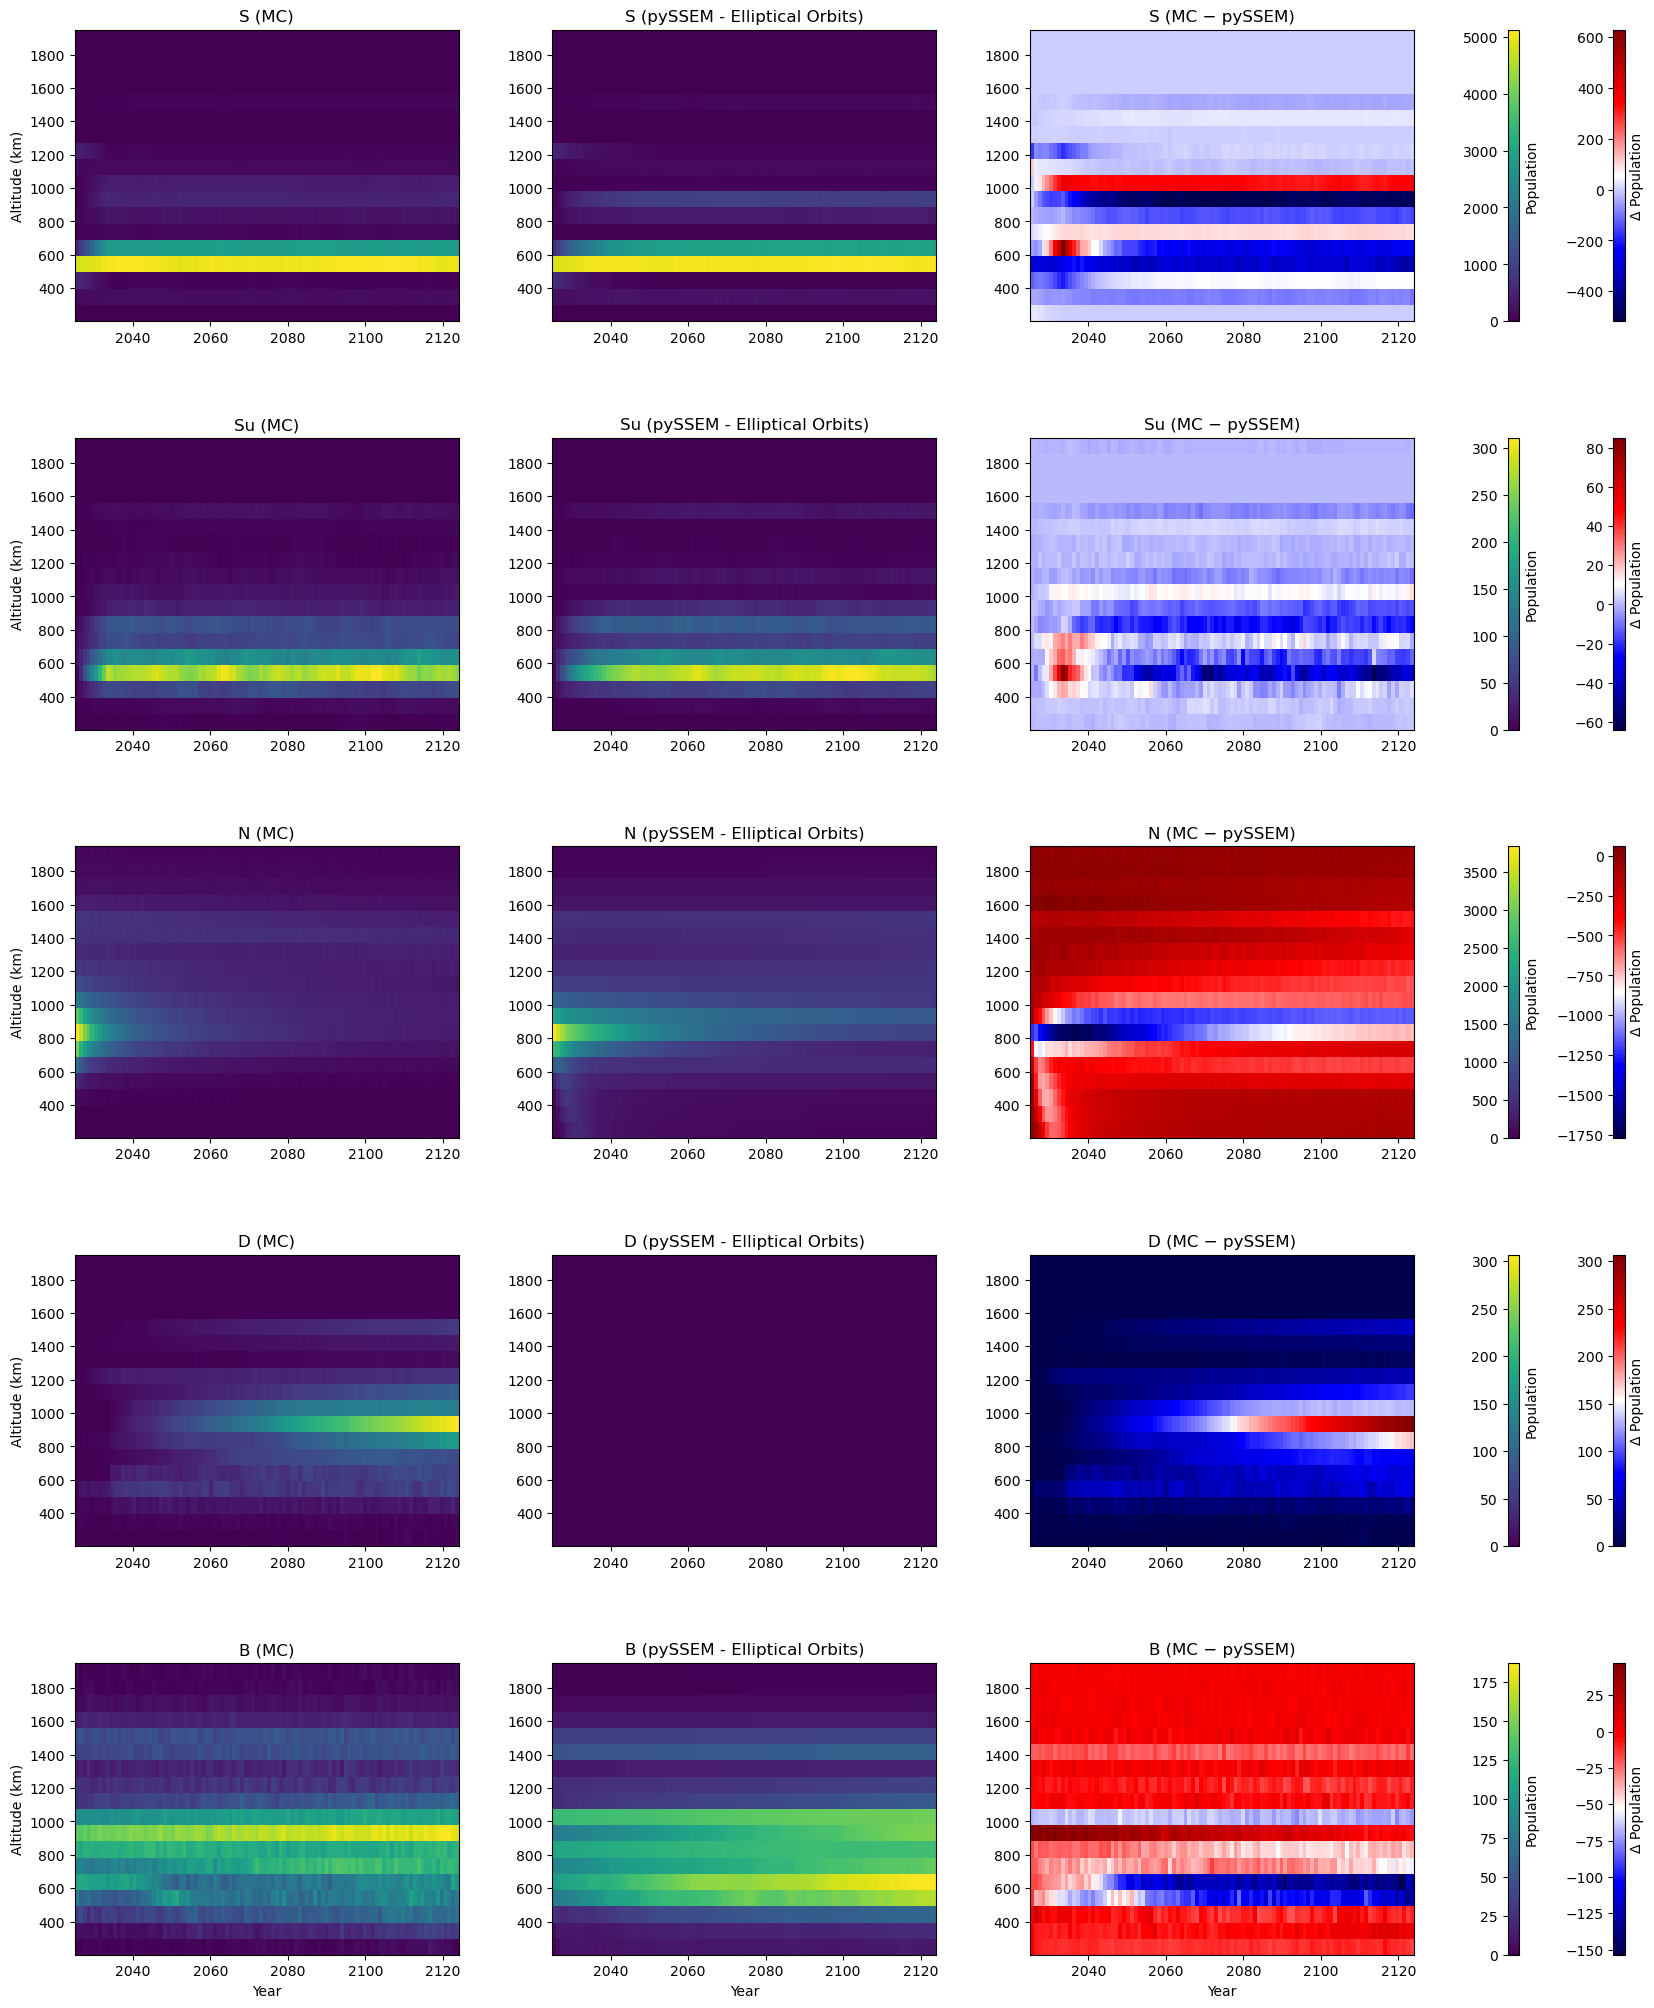

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# — Load MC data —
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'
mc_df = pd.read_csv(mc_pop_time_alt_path)

# — SSEM metadata —
n_sma_bins    = scenario_properties.n_shells
n_ecc_bins    = len(scenario_properties.eccentricity_bins) - 1
n_species     = scenario_properties.species_length
n_time        = scenario_properties.output.y.shape[1]
# Build the common year axis: MC runs 2025–2125 (101 years), SSEM has 100 timesteps,
# so we drop the MC final year (2125) and align on 2025–2124.
base_year     = int(mc_df['Year'].min())           # 2025
years_common  = base_year + np.arange(n_time)      # array([2025, …, 2124])
altitudes     = scenario_properties.HMid           # altitude midpoints (km)
species_names = scenario_properties.species_names

# — Define main‐species groups —
large_fragments = ['N_10kg','N_148kg','N_260kg','N_472kg','N_750kg','N_1250kg']
group_indices   = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    # 'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N':   [i for i, sp in enumerate(species_names)
            if sp.startswith('N') and sp not in large_fragments],
    'D':   [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp.startswith('B')]
}
groups = list(group_indices.keys())

# — Precompute SSEM group heatmaps (altitude × time) —
ssem_group_hm = {g: np.zeros((len(altitudes), n_time)) for g in groups}
for t in range(n_time):
    y_t      = scenario_properties.output.y[:, t]
    x_mat    = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))
    alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(x_mat)
    for grp, idxs in group_indices.items():
        ssem_group_hm[grp][:, t] = alt_proj[:, idxs].sum(axis=1)

# — Build figure: rows=groups, cols=[MC, SSEM, Diff] + two small colorbars —
fig = plt.figure(figsize=(20, 5 * len(groups)))
gs  = fig.add_gridspec(len(groups), 5,
                       width_ratios=[1,1,1,0.03,0.03],
                       wspace=0.4, hspace=0.4)

for i, grp in enumerate(groups):
    mc_sub = mc_df[mc_df['Species'] == grp]
    if mc_sub.empty:
        continue

    # — MC raw pivot & reindex to [2025..2124] × altitudes —
    # mc_pivot = mc_sub.pivot(index='Altitude', columns='Year', values='Population')
    # mc_pivot = mc_pivot.reindex(index=altitudes, columns=years_common, fill_value=0)
    # mc_hm    = mc_pivot.values  # shape (n_alt, 100)
    # — MC raw pivot (no altitude reindex yet) —
    mc_pivot = mc_sub.pivot(index='Altitude', columns='Year', values='Population').fillna(0.0)
    mc_pivot = mc_pivot.reindex(columns=years_common, fill_value=0).sort_index(axis=0)  # years aligned

    # # Helper: resample a (alt × time) matrix to a target altitude grid
    def _resample_alt(mat, src_alts, tgt_alts, kind="nearest"):
        src_alts = np.asarray(src_alts, float)
        tgt_alts = np.asarray(tgt_alts, float)
        mat = np.asarray(mat, float)
        if kind == "nearest":
            # nearest-neighbor selection of rows
            idx = np.searchsorted(src_alts, tgt_alts)
            idx = np.clip(idx, 0, len(src_alts) - 1)
            idxm = np.maximum(idx - 1, 0)
            use_prev = (idx > 0) & (np.abs(src_alts[idx] - tgt_alts) > np.abs(src_alts[idxm] - tgt_alts))
            idx[use_prev] = idxm[use_prev]
            return mat[idx, :]
        elif kind == "linear":
            out = np.empty((len(tgt_alts), mat.shape[1]), dtype=float)
            for j in range(mat.shape[1]):
                out[:, j] = np.interp(tgt_alts, src_alts, mat[:, j])
            return out
        else:
            raise ValueError("kind must be 'nearest' or 'linear'")

    # Build MC matrix and resample to SSEM altitude grid
    mc_alts = mc_pivot.index.to_numpy(dtype=float)
    mc_mat  = mc_pivot.to_numpy(dtype=float)  # shape: (len(mc_alts), n_time)

    # Choose resampling mode: 'nearest' (piecewise-constant) or 'linear'
    mc_hm = _resample_alt(mc_mat, mc_alts, np.asarray(altitudes, float), kind="linear")  # -> (n_altitudes, n_time)

    # — SSEM & difference —
    ssem_hm = ssem_group_hm[grp]        # shape (n_alt, 100)
    diff_hm = mc_hm - ssem_hm

    # — Plot MC heatmap —
    ax0 = fig.add_subplot(gs[i,0])
    im0 = ax0.imshow(mc_hm,
                     origin='lower', aspect='auto',
                     extent=[years_common.min(), years_common.max(),
                             altitudes.min(),    altitudes.max()],
                     cmap='viridis')
    ax0.set_title(f"{grp} (MC)")
    if i == len(groups) - 1:
        ax0.set_xlabel("Year")
    ax0.set_ylabel("Altitude (km)")

    # — Plot SSEM heatmap —
    ax1 = fig.add_subplot(gs[i,1], sharey=ax0)
    im1 = ax1.imshow(ssem_hm,
                     origin='lower', aspect='auto',
                     extent=[years_common.min(), years_common.max(),
                             altitudes.min(),    altitudes.max()],
                     cmap='viridis')
    ax1.set_title(f"{grp} (pySSEM - Elliptical Orbits)")
    if i == len(groups) - 1:
        ax1.set_xlabel("Year")

    # — Plot Difference heatmap —
    ax2 = fig.add_subplot(gs[i,2], sharey=ax0)
    im2 = ax2.imshow(diff_hm,
                     origin='lower', aspect='auto',
                     extent=[years_common.min(), years_common.max(),
                             altitudes.min(),    altitudes.max()],
                     cmap='seismic')
    ax2.set_title(f"{grp} (MC − pySSEM)")
    if i == len(groups) - 1:
        ax2.set_xlabel("Year")

    # — Population colorbar —
    cax_pop = fig.add_subplot(gs[i,3])
    plt.colorbar(im0, cax=cax_pop).set_label("Population")
    cax_pop.yaxis.set_ticks_position('left')

    # — Difference colorbar —
    cax_diff = fig.add_subplot(gs[i,4])
    plt.colorbar(im2, cax=cax_diff).set_label("Δ Population")
    cax_diff.yaxis.set_ticks_position('left')

# plt.suptitle("MC vs SSEM vs Difference by Group (2025–2124)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_2179/3734506772.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


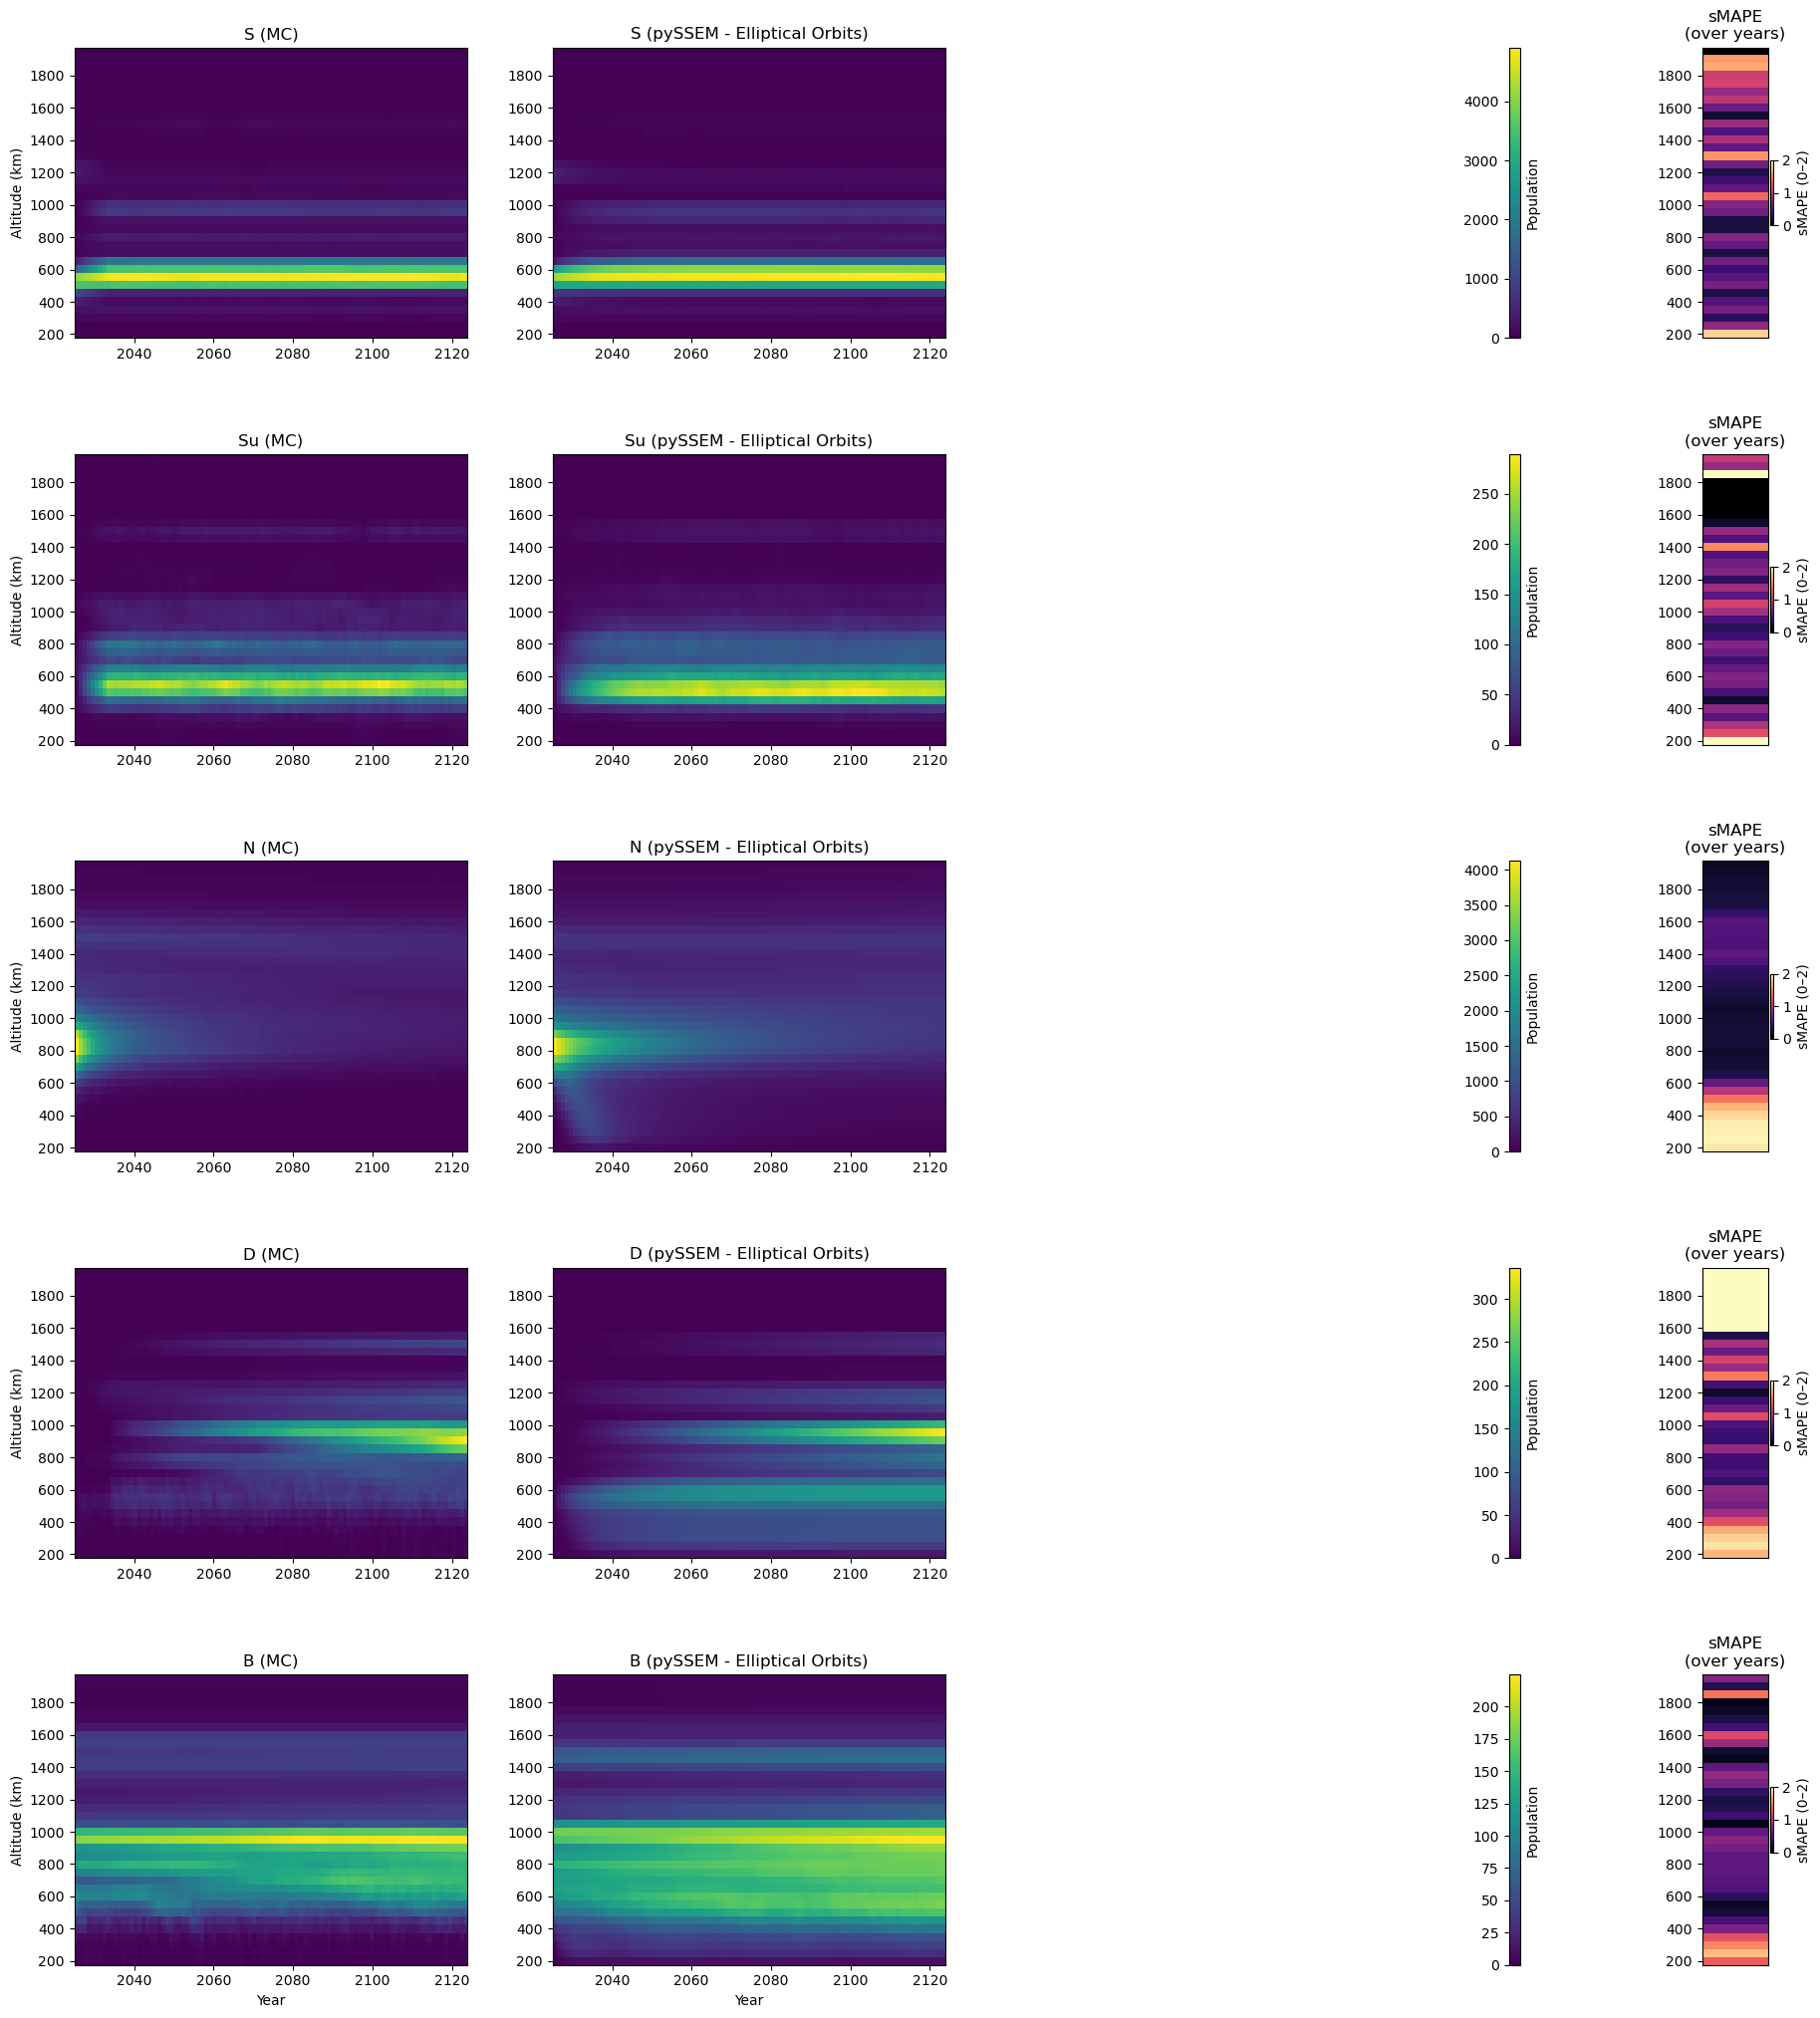

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_2179/3070349918.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


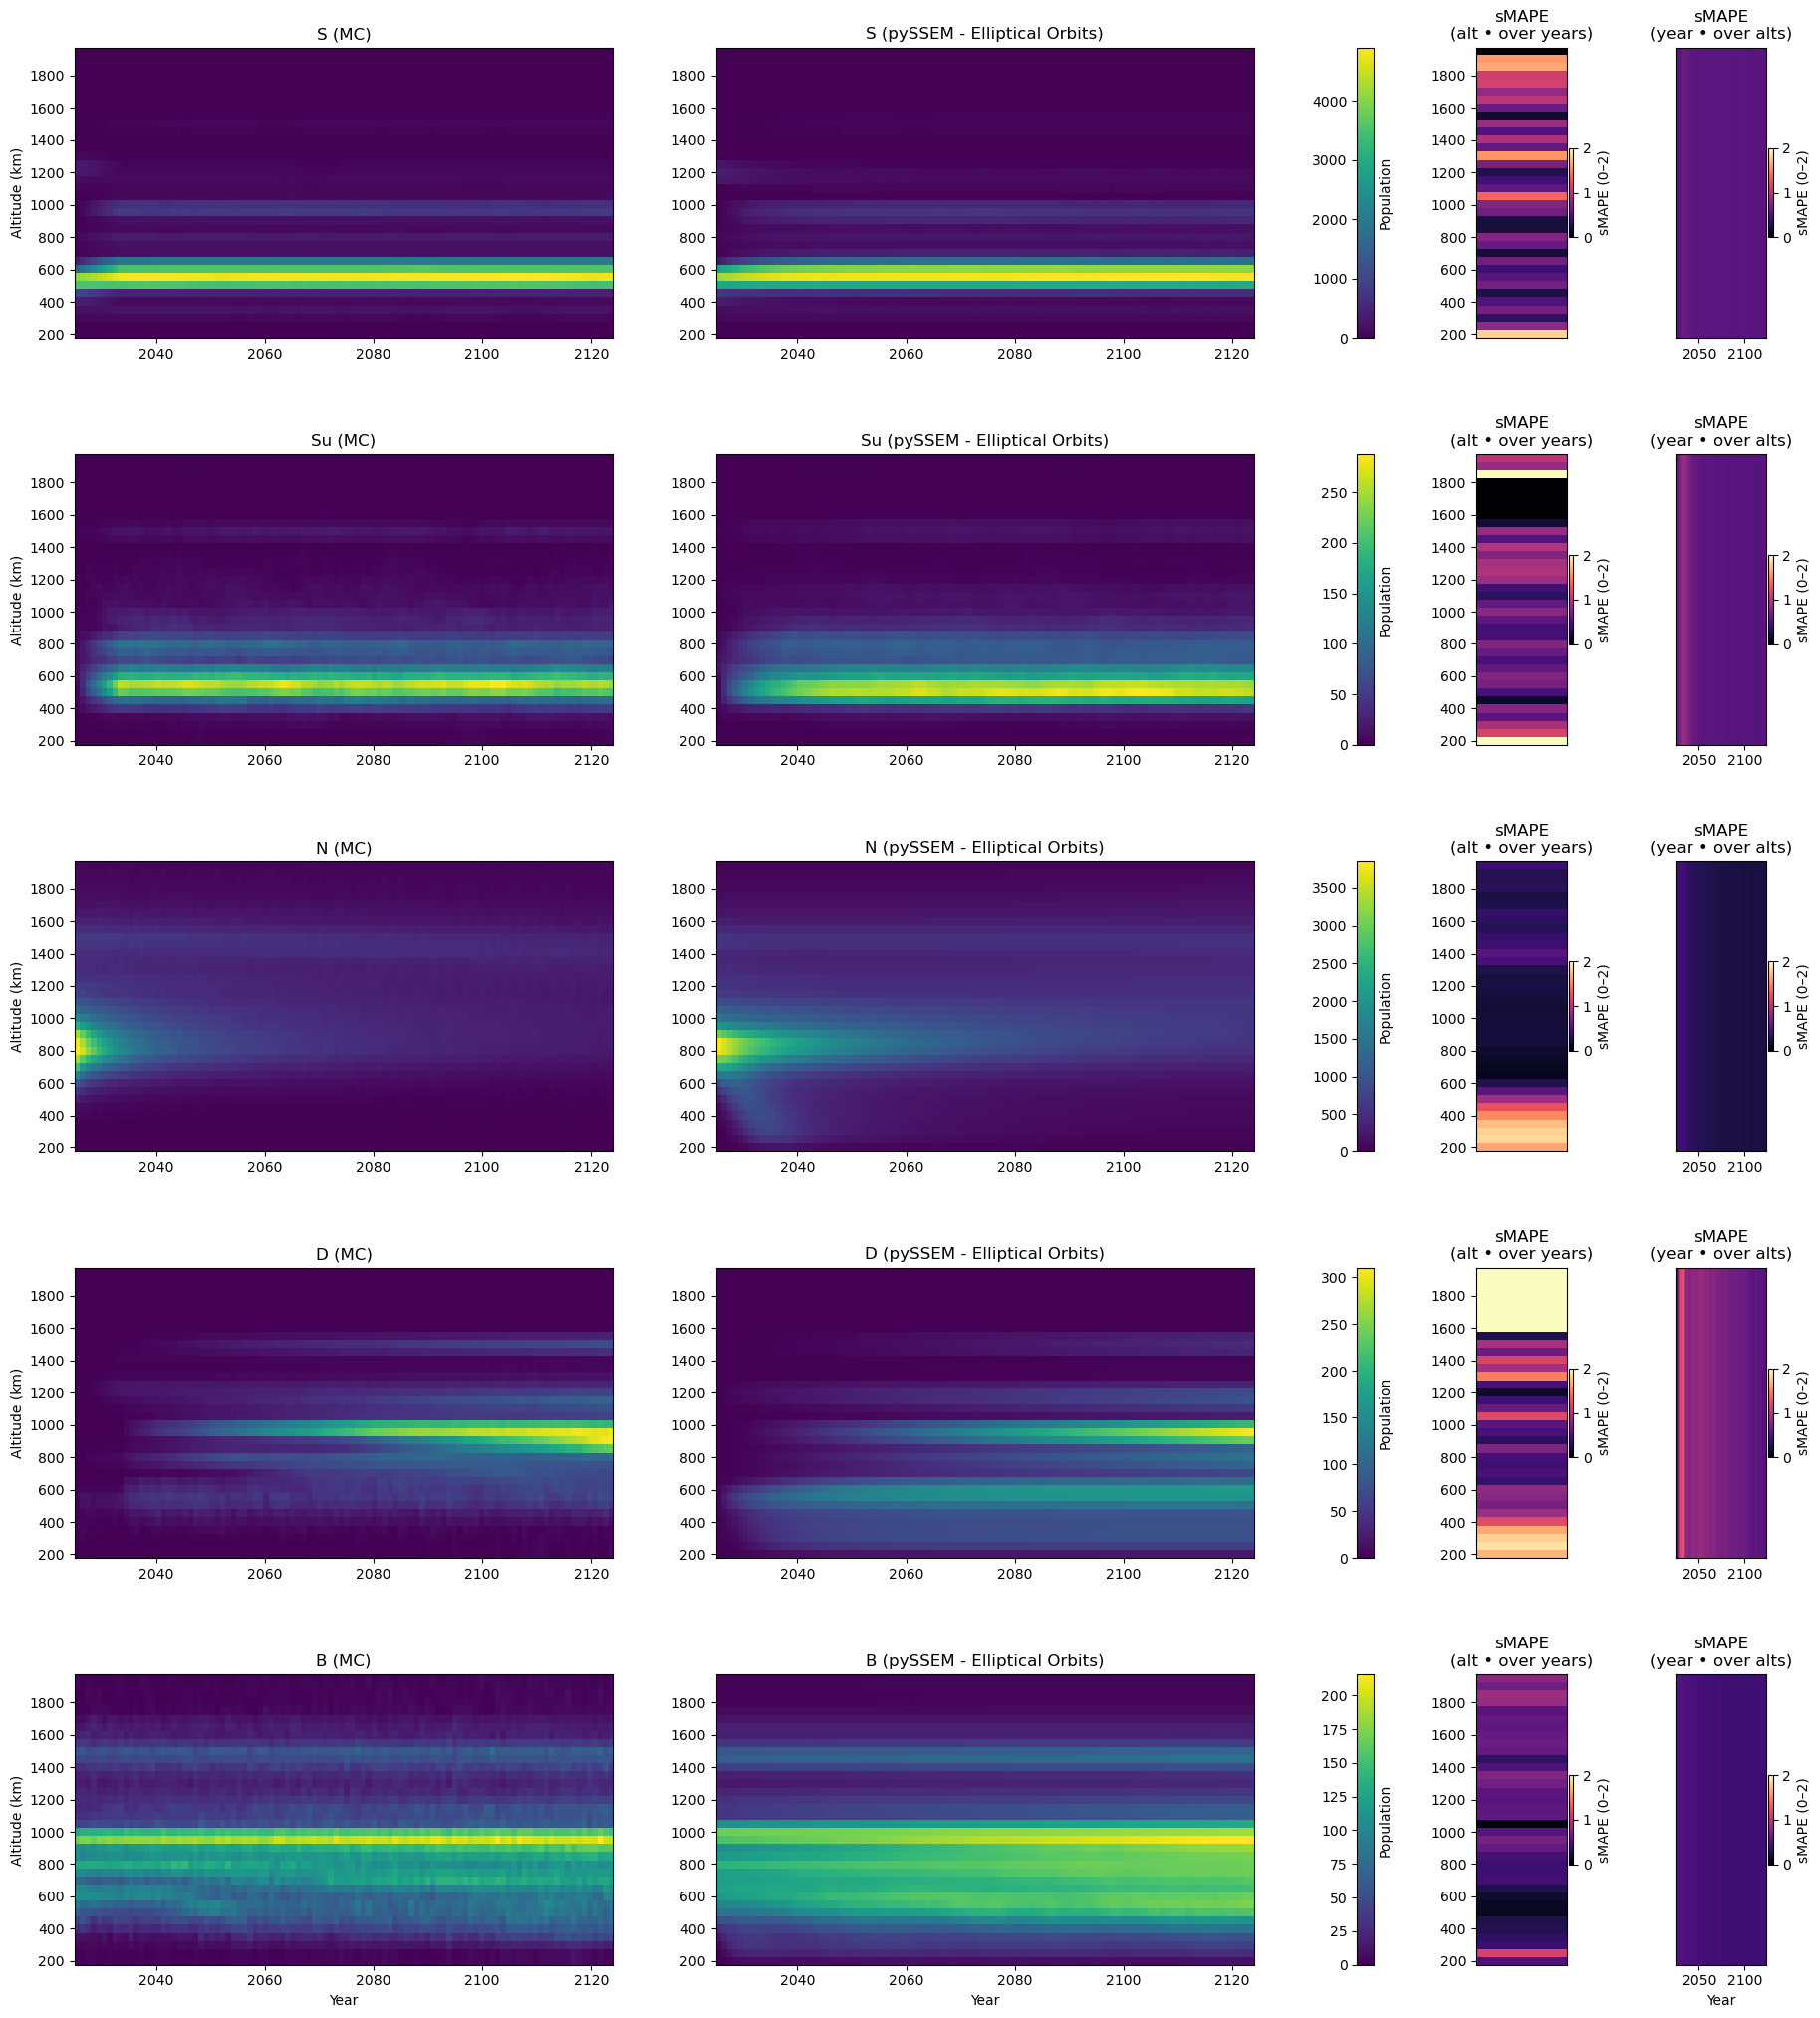

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# — Load MC data —
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'
mc_df = pd.read_csv(mc_pop_time_alt_path)

# — SSEM metadata —
n_sma_bins    = scenario_properties.n_shells
n_ecc_bins    = len(scenario_properties.eccentricity_bins) - 1
n_species     = scenario_properties.species_length
n_time        = scenario_properties.output.y.shape[1]
# Build the common year axis: MC runs 2025–2125 (101 years), SSEM has 100 timesteps,
# so we drop the MC final year (2125) and align on 2025–2124.
base_year     = int(mc_df['Year'].min())           # 2025
years_common  = base_year + np.arange(n_time)      # array([2025, …, 2124])
altitudes     = scenario_properties.HMid           # altitude midpoints (km)
species_names = scenario_properties.species_names

# — Define main‐species groups —
large_fragments = ['N_10kg','N_148kg','N_260kg','N_472kg','N_750kg','N_1250kg']
group_indices   = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    # 'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N':   [i for i, sp in enumerate(species_names)
            if sp.startswith('N') and sp not in large_fragments],
    'D':   [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp.startswith('B')]
}
groups = list(group_indices.keys())

# — Precompute SSEM group heatmaps (altitude × time) —
ssem_group_hm = {g: np.zeros((len(altitudes), n_time)) for g in groups}
for t in range(n_time):
    y_t      = scenario_properties.output.y[:, t]
    x_mat    = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))
    alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(x_mat)
    for grp, idxs in group_indices.items():
        ssem_group_hm[grp][:, t] = alt_proj[:, idxs].sum(axis=1)

# --- Helper: resample a (alt × time) matrix to a target altitude grid
def _resample_alt(mat, src_alts, tgt_alts, kind="nearest"):
    src_alts = np.asarray(src_alts, float)
    tgt_alts = np.asarray(tgt_alts, float)
    mat = np.asarray(mat, float)
    if kind == "nearest":
        idx = np.searchsorted(src_alts, tgt_alts)
        idx = np.clip(idx, 0, len(src_alts) - 1)
        idxm = np.maximum(idx - 1, 0)
        use_prev = (idx > 0) & (np.abs(src_alts[idx] - tgt_alts) > np.abs(src_alts[idxm] - tgt_alts))
        idx[use_prev] = idxm[use_prev]
        return mat[idx, :]
    elif kind == "linear":
        out = np.empty((len(tgt_alts), mat.shape[1]), dtype=float)
        for j in range(mat.shape[1]):
            out[:, j] = np.interp(tgt_alts, src_alts, mat[:, j])
        return out
    else:
        raise ValueError("kind must be 'nearest' or 'linear'")

# --- sMAPE helpers (magnitude-weighted, safe zeros) ---
def smape_over_time(A, F, eps=1e-12):
    """
    Per-altitude sMAPE aggregated over years (weighted by |A|+|F| each year).
    A, F: (n_alt, n_time) -> returns (n_alt,) in [0, 2].
    """
    num = 2.0 * np.sum(np.abs(A - F), axis=1)
    den = np.sum(np.abs(A) + np.abs(F), axis=1)
    out = np.divide(num, np.maximum(den, eps))
    out[(den <= eps)] = 0.0  # both zero across all years -> perfect match
    return out

def smape_per_year(A, F, eps=1e-12):
    """
    Per-year sMAPE aggregated over altitudes (weighted by |A|+|F| across alts).
    A, F: (n_alt, n_time) -> returns (n_time,) in [0, 2].
    """
    num = 2.0 * np.sum(np.abs(A - F), axis=0)
    den = np.sum(np.abs(A) + np.abs(F), axis=0)
    out = np.divide(num, np.maximum(den, eps))
    out[(den <= eps)] = 0.0  # both zero across all altitudes -> perfect match
    return out

# — Build figure: rows=groups, cols=[MC, SSEM, cbar_pop, sMAPE_alt, sMAPE_year] —
fig = plt.figure(figsize=(22, 5 * len(groups)))
gs  = fig.add_gridspec(len(groups), 5,
                       width_ratios=[1, 1, 0.03, 0.18, 0.18],
                       wspace=0.4, hspace=0.4)

for i, grp in enumerate(groups):
    mc_sub = mc_df[mc_df['Species'] == grp]
    if mc_sub.empty:
        continue

    # MC raw pivot & align years
    mc_pivot = mc_sub.pivot(index='Altitude', columns='Year', values='Population').fillna(0.0)
    mc_pivot = mc_pivot.reindex(columns=years_common, fill_value=0).sort_index(axis=0)

    # Build MC matrix and resample to SSEM altitude grid
    mc_alts = mc_pivot.index.to_numpy(dtype=float)
    mc_mat  = mc_pivot.to_numpy(dtype=float)  # (len(mc_alts), n_time)
    mc_hm   = _resample_alt(mc_mat, mc_alts, np.asarray(altitudes, float), kind="linear")  # (n_alt, n_time)

    # — SSEM —
    ssem_hm = ssem_group_hm[grp]  # (n_alt, n_time)

    # — Plot MC heatmap —
    ax0 = fig.add_subplot(gs[i,0])
    im0 = ax0.imshow(mc_hm,
                     origin='lower', aspect='auto',
                     extent=[years_common.min(), years_common.max(),
                             altitudes.min(),    altitudes.max()],
                     cmap='viridis')
    ax0.set_title(f"{grp} (MC)")
    if i == len(groups) - 1:
        ax0.set_xlabel("Year")
    ax0.set_ylabel("Altitude (km)")

    # — Plot SSEM heatmap —
    ax1 = fig.add_subplot(gs[i,1], sharey=ax0)
    im1 = ax1.imshow(ssem_hm,
                     origin='lower', aspect='auto',
                     extent=[years_common.min(), years_common.max(),
                             altitudes.min(),    altitudes.max()],
                     cmap='viridis')
    ax1.set_title(f"{grp} (pySSEM - Elliptical Orbits)")
    if i == len(groups) - 1:
        ax1.set_xlabel("Year")

    # — Population colorbar —
    cax_pop = fig.add_subplot(gs[i,2])
    plt.colorbar(im0, cax=cax_pop).set_label("Population")
    cax_pop.yaxis.set_ticks_position('left')

    # — sMAPE per altitude over years (right column #1) —
    smape_alt = smape_over_time(mc_hm, ssem_hm)     # (n_alt,)
    smape_col = smape_alt[:, None]                  # (n_alt, 1)
    ax_sa = fig.add_subplot(gs[i,3], sharey=ax0)
    im_sa = ax_sa.imshow(smape_col,
                         origin='lower', aspect='auto',
                         extent=[0, 1, altitudes.min(), altitudes.max()],
                         vmin=0.0, vmax=2.0, cmap='magma')   # sMAPE ∈ [0,2]
    ax_sa.set_title("sMAPE\n(alt • over years)")
    ax_sa.set_xticks([])  # decorative strip
    cb_sa = plt.colorbar(im_sa, ax=ax_sa, fraction=0.046, pad=0.02)
    cb_sa.set_label("sMAPE (0–2)")

    # — sMAPE per year over altitudes (right column #2) —
    smape_year = smape_per_year(mc_hm, ssem_hm)     # (n_time,)
    smape_row  = smape_year[None, :]                # (1, n_time)
    ax_sy = fig.add_subplot(gs[i,4])
    im_sy = ax_sy.imshow(smape_row,
                         origin='lower', aspect='auto',
                         extent=[years_common.min(), years_common.max(), 0, 1],
                         vmin=0.0, vmax=2.0, cmap='magma')
    ax_sy.set_title("sMAPE\n(year • over alts)")
    ax_sy.set_yticks([])  # decorative strip
    if i == len(groups) - 1:
        ax_sy.set_xlabel("Year")
    cb_sy = plt.colorbar(im_sy, ax=ax_sy, fraction=0.046, pad=0.02)
    cb_sy.set_label("sMAPE (0–2)")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

eps = 1e-12
A = np.asarray(mc_hm, float)   # shape (n_alt, n_time)
F = np.asarray(ssem_hm, float)

# 1) WAPE and weighted sMAPE
WAPE   = np.sum(np.abs(A-F)) / max(np.sum(A), eps)
sMAPE  = (2.0*np.sum(np.abs(A-F))) / max(np.sum(np.abs(A)+np.abs(F)), eps)

# 2) Weighted Jaccard (counts IoU)
mn = np.minimum(A, F).sum()
mx = np.maximum(A, F).sum()
Jw = mn / max(mx, eps)

# 3) Mass-quantile hotspot masks (e.g., top 80% of mass)
def mass_quantile_mask(X, q=0.8):
    flat = X.ravel()
    order = np.argsort(flat)[::-1]
    csum = np.cumsum(flat[order])
    k = np.searchsorted(csum, q*csum[-1]) + 1
    mask = np.zeros_like(flat, dtype=bool)
    mask[order[:k]] = True
    return mask.reshape(X.shape)

HA = mass_quantile_mask(A, q=0.8)
HF = mass_quantile_mask(F, q=0.8)  # or use HA-threshold for both if evaluating vs MC

tp = np.logical_and(HA, HF).sum()
fp = np.logical_and(~HA, HF).sum()
fn = np.logical_and(HA, ~HF).sum()
union = np.logical_or(HA, HF).sum()

IoU = tp / max(union, 1)
precision = tp / max(tp+fp, 1)
recall    = tp / max(tp+fn, 1)
F1        = 2*precision*recall / max(precision+recall, eps)

# 4) Ridge (altitude of peak) alignment per year
alt = np.asarray(altitudes, float)
peak_alt_A = alt[np.argmax(A, axis=0)]
peak_alt_F = alt[np.argmax(F, axis=0)]
ridge_alt_MAE  = np.mean(np.abs(peak_alt_A - peak_alt_F))
ridge_alt_RMSE = np.sqrt(np.mean((peak_alt_A - peak_alt_F)**2))

# 5) EMD along altitude per year (CDF/L1 on the grid)
def emd1d_on_grid(x, w1, w2, eps=1e-12):
    s1 = w1.sum(); s2 = w2.sum()
    if s1 < eps and s2 < eps: return 0.0
    if s1 < eps: w1 = np.zeros_like(w1); s1 = 1.0
    if s2 < eps: w2 = np.zeros_like(w2); s2 = 1.0
    c1 = np.cumsum(w1 / s1)
    c2 = np.cumsum(w2 / s2)
    # L1 distance between CDFs integrated over x
    return np.trapz(np.abs(c1 - c2), x)

emd_year = [emd1d_on_grid(alt, A[:,t], F[:,t]) for t in range(A.shape[1])]
emd_median = float(np.median(emd_year))

S ALT= 535.4166666666666 km  err%= 26.192467393513457   MC mass= 479426.49074074085
S ALT= 484.0277777777777 km  err%= 22.927205957172465   MC mass= 350338.6759259256
S ALT= 586.8055555555555 km  err%= 15.176708688774005   MC mass= 346300.71913580253
S ALT= 638.1944444444445 km  err%= 12.101300080918104   MC mass= 189383.7515432098
S ALT= 946.5277777777777 km  err%= 4.858811947825297   MC mass= 77123.63425925918
Su ALT= 535.4166666666666 km  err%= 21.266136180944727   MC mass= 24793.115740740745
Su ALT= 586.8055555555555 km  err%= 16.013601915701557   MC mass= 17791.094135802476
Su ALT= 484.0277777777777 km  err%= 13.109688400378824   MC mass= 20771.77932098764
Su ALT= 638.1944444444445 km  err%= 8.90127664443165   MC mass= 11752.080246913578
Su ALT= 792.3611111111111 km  err%= 8.152981371059633   MC mass= 9006.953703703706
N ALT= 1409.0277777777778 km  err%= 6.068682034550596   MC mass= 47711.0138888889
N ALT= 843.75 km  err%= 5.094256423231033   MC mass= 77186.27777777777
N ALT= 1460

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_2179/542685374.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


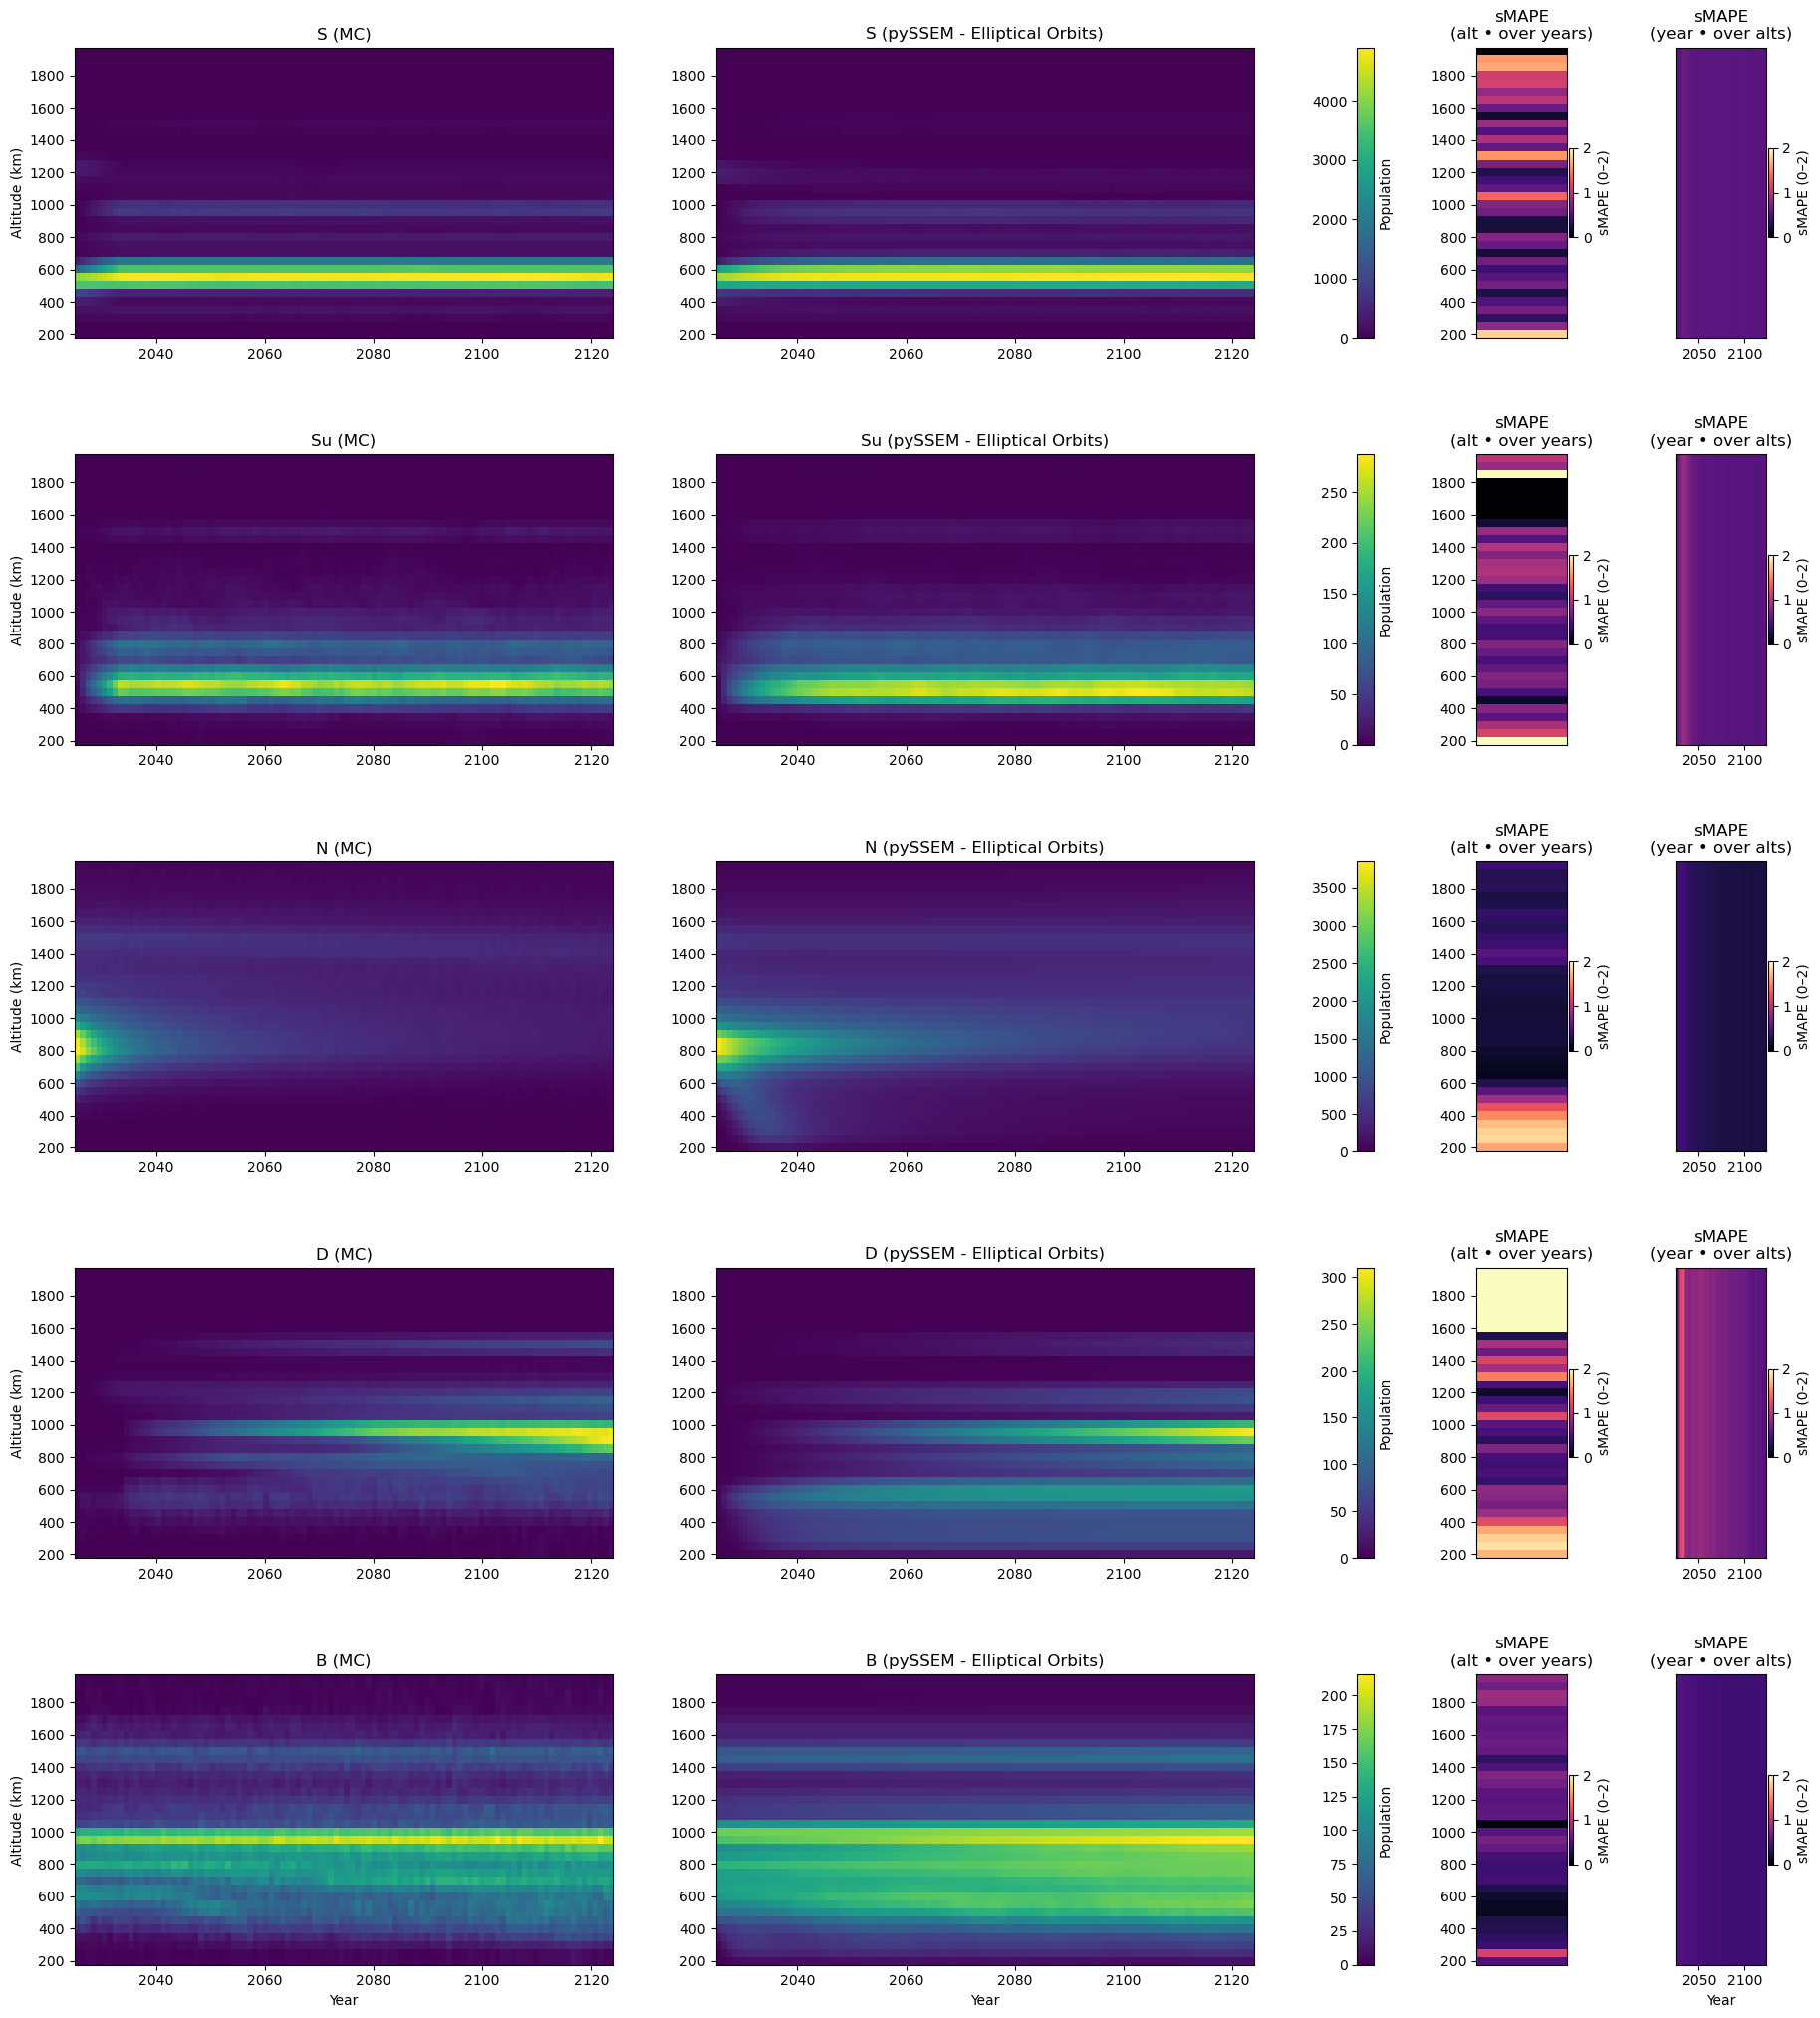


=== Summary metrics by group ===
       WAPE  sMAPE_global  Weighted_Jaccard  IoU_top80%  Precision  Recall    F1  Ridge_MAE_km  Ridge_RMSE_km  EMD_median_km
Group                                                                                                                       
B     0.364         0.437             0.641       0.892      0.952   0.935 0.943        13.361         26.203         53.332
D     0.674         0.668             0.499       0.471      0.594   0.695 0.641       153.139        250.175        199.985
N     0.304         0.310             0.731       0.716      0.790   0.885 0.835       275.444        367.996        100.593
S     0.438         0.556             0.565       0.864      0.878   0.981 0.927         0.000          0.000          6.376
Su    0.449         0.579             0.551       0.932      0.971   0.959 0.965        50.875         51.131         10.706


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# — Load MC data —
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'
mc_df = pd.read_csv(mc_pop_time_alt_path)

# — SSEM metadata —
n_sma_bins    = scenario_properties.n_shells
n_ecc_bins    = len(scenario_properties.eccentricity_bins) - 1
n_species     = scenario_properties.species_length
n_time        = scenario_properties.output.y.shape[1]
# MC runs 2025–2125 (101 years), SSEM has 100 timesteps → drop MC final year (2125).
base_year     = int(mc_df['Year'].min())           # 2025
years_common  = base_year + np.arange(n_time)      # array([2025, …, 2124])
altitudes     = np.asarray(scenario_properties.HMid, float)  # altitude midpoints (km)
species_names = scenario_properties.species_names

# — Species groups —
large_fragments = ['N_10kg','N_148kg','N_260kg','N_472kg','N_750kg','N_1250kg']
group_indices   = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    # 'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N':   [i for i, sp in enumerate(species_names)
            if sp.startswith('N') and sp not in large_fragments],
    'D':   [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp.startswith('B')]
}
groups = list(group_indices.keys())

# — Precompute SSEM group heatmaps (altitude × time) —
ssem_group_hm = {g: np.zeros((len(altitudes), n_time)) for g in groups}
for t in range(n_time):
    y_t      = scenario_properties.output.y[:, t]
    x_mat    = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))
    alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(x_mat)
    for grp, idxs in group_indices.items():
        ssem_group_hm[grp][:, t] = alt_proj[:, idxs].sum(axis=1)

# --- Resample helper (alt × time) to a target altitude grid
def _resample_alt(mat, src_alts, tgt_alts, kind="nearest"):
    src_alts = np.asarray(src_alts, float)
    tgt_alts = np.asarray(tgt_alts, float)
    mat = np.asarray(mat, float)
    if kind == "nearest":
        idx = np.searchsorted(src_alts, tgt_alts)
        idx = np.clip(idx, 0, len(src_alts) - 1)
        idxm = np.maximum(idx - 1, 0)
        use_prev = (idx > 0) & (np.abs(src_alts[idx] - tgt_alts) > np.abs(src_alts[idxm] - tgt_alts))
        idx[use_prev] = idxm[use_prev]
        return mat[idx, :]
    elif kind == "linear":
        out = np.empty((len(tgt_alts), mat.shape[1]), dtype=float)
        for j in range(mat.shape[1]):
            out[:, j] = np.interp(tgt_alts, src_alts, mat[:, j])
        return out
    else:
        raise ValueError("kind must be 'nearest' or 'linear'")

# --- Metrics helpers (robust to zeros) ---
eps = 1e-12
HOTSPOT_Q = 0.80  # top-80% mass hotspot by default

def wape(A, F, eps=eps):
    den = np.sum(A)
    return np.sum(np.abs(A - F)) / max(den, eps)

def smape_total(A, F, eps=eps):
    num = 2.0 * np.sum(np.abs(A - F))
    den = np.sum(np.abs(A) + np.abs(F))
    if den <= eps:
        return 0.0
    return num / den

def weighted_jaccard(A, F, eps=eps):
    mn = np.minimum(A, F).sum()
    mx = np.maximum(A, F).sum()
    if mx <= eps:
        return 1.0  # both empty → perfect overlap
    return mn / mx

def mass_quantile_mask(X, q=HOTSPOT_Q, eps=eps):
    flat = X.ravel()
    total = flat.sum()
    if total <= eps:
        return np.zeros_like(X, dtype=bool)
    order = np.argsort(flat)[::-1]
    csum = np.cumsum(flat[order])
    k = np.searchsorted(csum, q * total) + 1
    mask = np.zeros_like(flat, dtype=bool)
    mask[order[:k]] = True
    return mask.reshape(X.shape)

def hotspot_scores(A, F, q=HOTSPOT_Q):
    HA = mass_quantile_mask(A, q=q)
    HF = mass_quantile_mask(F, q=q)
    tp = np.logical_and(HA, HF).sum()
    fp = np.logical_and(~HA, HF).sum()
    fn = np.logical_and(HA, ~HF).sum()
    union = np.logical_or(HA, HF).sum()
    if union == 0:
        return 1.0, 1.0, 1.0, 1.0  # both empty → perfect
    precision = tp / max(tp + fp, 1)
    recall    = tp / max(tp + fn, 1)
    f1        = 2 * precision * recall / max(precision + recall, eps)
    iou       = tp / union
    return iou, precision, recall, f1

def ridge_alignment_km(alt, A, F):
    """Peak altitude difference per year."""
    if A.shape[0] != len(alt) or F.shape[0] != len(alt):
        raise ValueError("Altitude axis length mismatch.")
    peak_alt_A = alt[np.argmax(A, axis=0)]
    peak_alt_F = alt[np.argmax(F, axis=0)]
    d = peak_alt_A - peak_alt_F
    return float(np.mean(np.abs(d))), float(np.sqrt(np.mean(d**2)))

def emd1d_on_grid(x, w1, w2, eps=eps):
    """EMD between discrete 1D distributions on grid x (km)."""
    s1 = w1.sum(); s2 = w2.sum()
    if s1 < eps and s2 < eps: 
        return 0.0
    if s1 < eps:
        w1 = np.zeros_like(w1); s1 = 1.0
    if s2 < eps:
        w2 = np.zeros_like(w2); s2 = 1.0
    c1 = np.cumsum(w1 / s1)
    c2 = np.cumsum(w2 / s2)
    return float(np.trapz(np.abs(c1 - c2), x))

def emd_per_year_km(alt, A, F):
    return [emd1d_on_grid(alt, A[:, t], F[:, t]) for t in range(A.shape[1])]

# --- sMAPE strips already in your figure ---
def smape_over_time(A, F, eps=eps):
    num = 2.0 * np.sum(np.abs(A - F), axis=1)
    den = np.sum(np.abs(A) + np.abs(F), axis=1)
    out = np.divide(num, np.maximum(den, eps))
    out[(den <= eps)] = 0.0
    return out

def smape_per_year(A, F, eps=eps):
    num = 2.0 * np.sum(np.abs(A - F), axis=0)
    den = np.sum(np.abs(A) + np.abs(F), axis=0)
    out = np.divide(num, np.maximum(den, eps))
    out[(den <= eps)] = 0.0
    return out

# — Build figure: rows=groups, cols=[MC, SSEM, cbar_pop, sMAPE_alt, sMAPE_year] —
fig = plt.figure(figsize=(22, 5 * len(groups)))
gs  = fig.add_gridspec(len(groups), 5,
                       width_ratios=[1, 1, 0.03, 0.18, 0.18],
                       wspace=0.4, hspace=0.4)

metrics_rows = []            # summary per group
per_year_records = []        # long-form per-year metrics
per_alt_records  = []        # long-form per-altitude sMAPE

for i, grp in enumerate(groups):
    mc_sub = mc_df[mc_df['Species'] == grp]
    if mc_sub.empty:
        continue

    # MC pivot & align years
    mc_pivot = mc_sub.pivot(index='Altitude', columns='Year', values='Population').fillna(0.0)
    mc_pivot = mc_pivot.reindex(columns=years_common, fill_value=0).sort_index(axis=0)

    # Resample MC to SSEM altitude grid
    mc_alts = mc_pivot.index.to_numpy(dtype=float)
    mc_mat  = mc_pivot.to_numpy(dtype=float)                     # (len(mc_alts), n_time)
    mc_hm   = _resample_alt(mc_mat, mc_alts, altitudes, kind="linear")  # (n_alt, n_time)

    # SSEM
    ssem_hm = ssem_group_hm[grp]  # (n_alt, n_time)

    # — Plot MC —
    ax0 = fig.add_subplot(gs[i,0])
    im0 = ax0.imshow(mc_hm, origin='lower', aspect='auto',
                     extent=[years_common.min(), years_common.max(),
                             altitudes.min(),    altitudes.max()],
                     cmap='viridis')
    ax0.set_title(f"{grp} (MC)")
    if i == len(groups) - 1:
        ax0.set_xlabel("Year")
    ax0.set_ylabel("Altitude (km)")

    # — Plot SSEM —
    ax1 = fig.add_subplot(gs[i,1], sharey=ax0)
    im1 = ax1.imshow(ssem_hm, origin='lower', aspect='auto',
                     extent=[years_common.min(), years_common.max(),
                             altitudes.min(),    altitudes.max()],
                     cmap='viridis')
    ax1.set_title(f"{grp} (pySSEM - Elliptical Orbits)")
    if i == len(groups) - 1:
        ax1.set_xlabel("Year")

    # — Population colorbar (shared with MC panel) —
    cax_pop = fig.add_subplot(gs[i,2])
    plt.colorbar(im0, cax=cax_pop).set_label("Population")
    cax_pop.yaxis.set_ticks_position('left')

    # — sMAPE per altitude over years (strip) —
    smape_alt = smape_over_time(mc_hm, ssem_hm)     # (n_alt,)
    ax_sa = fig.add_subplot(gs[i,3], sharey=ax0)
    im_sa = ax_sa.imshow(smape_alt[:, None], origin='lower', aspect='auto',
                         extent=[0, 1, altitudes.min(), altitudes.max()],
                         vmin=0.0, vmax=2.0, cmap='magma')
    ax_sa.set_title("sMAPE\n(alt • over years)")
    ax_sa.set_xticks([])
    cb_sa = plt.colorbar(im_sa, ax=ax_sa, fraction=0.046, pad=0.02)
    cb_sa.set_label("sMAPE (0–2)")

    # — sMAPE per year over altitudes (strip) —
    smape_year = smape_per_year(mc_hm, ssem_hm)     # (n_time,)
    ax_sy = fig.add_subplot(gs[i,4])
    im_sy = ax_sy.imshow(smape_year[None, :], origin='lower', aspect='auto',
                         extent=[years_common.min(), years_common.max(), 0, 1],
                         vmin=0.0, vmax=2.0, cmap='magma')
    ax_sy.set_title("sMAPE\n(year • over alts)")
    ax_sy.set_yticks([])
    if i == len(groups) - 1:
        ax_sy.set_xlabel("Year")
    cb_sy = plt.colorbar(im_sy, ax=ax_sy, fraction=0.046, pad=0.02)
    cb_sy.set_label("sMAPE (0–2)")

    # ——— Metrics (hotspot-aware & alignment) ———
    WAPE            = wape(mc_hm, ssem_hm)                # 0–∞
    sMAPE_global    = smape_total(mc_hm, ssem_hm)         # 0–2
    Jw              = weighted_jaccard(mc_hm, ssem_hm)    # 0–1
    IoU, P, R, F1   = hotspot_scores(mc_hm, ssem_hm, q=HOTSPOT_Q)
    ridge_MAE_km, ridge_RMSE_km = ridge_alignment_km(altitudes, mc_hm, ssem_hm)
    emd_year_km     = emd_per_year_km(altitudes, mc_hm, ssem_hm)
    emd_median_km   = float(np.median(emd_year_km))

    metrics_rows.append({
        "Group": grp,
        "WAPE": WAPE,
        "sMAPE_global": sMAPE_global,
        "Weighted_Jaccard": Jw,
        f"IoU_top{int(HOTSPOT_Q*100)}%": IoU,
        "Precision": P,
        "Recall": R,
        "F1": F1,
        "Ridge_MAE_km": ridge_MAE_km,
        "Ridge_RMSE_km": ridge_RMSE_km,
        "EMD_median_km": emd_median_km
    })

    # After you have mc_hm, ssem_hm for a group:
    abs_err_by_alt = np.sum(np.abs(mc_hm - ssem_hm), axis=1)       # shape (n_alt,)
    mass_by_alt    = np.sum(mc_hm, axis=1)
    contrib = abs_err_by_alt / max(np.sum(np.abs(mc_hm - ssem_hm)), 1e-12)
    top = np.argsort(contrib)[::-1][:5]  # top 5 altitude bins driving error
    for k in top:
        print(grp, "ALT=", float(altitudes[k]), "km  err%=", float(100*contrib[k]), "  MC mass=", float(mass_by_alt[k]))

    # long-form per-year records (optional downstream analysis)
    for yr, smy, e in zip(years_common, smape_year, emd_year_km):
        per_year_records.append({"Group": grp, "Year": int(yr),
                                 "sMAPE_year": float(smy), "EMD_km": float(e)})

    # long-form per-alt sMAPE (optional)
    for alt_km, s_alt in zip(altitudes, smape_alt):
        per_alt_records.append({"Group": grp, "Altitude_km": float(alt_km),
                                "sMAPE_alt": float(s_alt)})

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# === Compact metrics table ===
metrics_df = pd.DataFrame(metrics_rows).set_index("Group").sort_index()
print("\n=== Summary metrics by group ===")
print(metrics_df.to_string(float_format=lambda x: f"{x:.3f}"))

# Optionally keep per-year / per-alt metrics for later analysis:
per_year_df = pd.DataFrame(per_year_records)    # columns: Group, Year, sMAPE_year, EMD_km
per_alt_df  = pd.DataFrame(per_alt_records)     # columns: Group, Altitude_km, sMAPE_alt
# Example saves (uncomment):
# metrics_df.to_csv("metrics_summary_by_group.csv")
# per_year_df.to_csv("metrics_per_year.csv", index=False)
# per_alt_df.to_csv("metrics_per_altitude.csv", index=False)

# Launch Functions

S: 131854 total launches
Su: 10067 total launches
N_0.03225kg: 0 total launches
N_1.88299kg: 0 total launches
N_4kg: 0 total launches
N_6kg: 0 total launches
N_148kg: 0 total launches
N_260kg: 0 total launches
B_1011kg: 1269 total launches
B_2023kg: 1083 total launches
144273


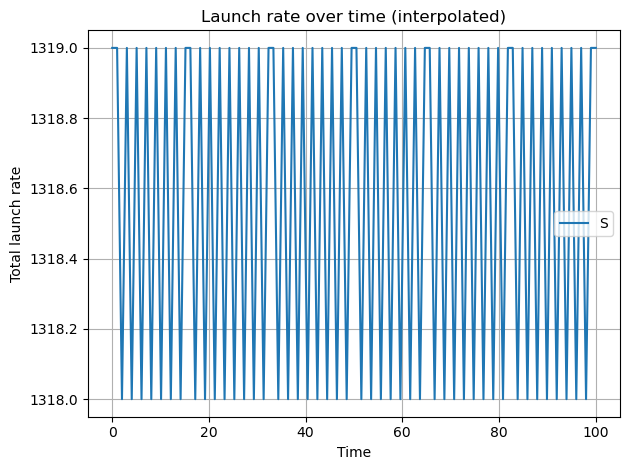

In [12]:
from scipy.interpolate import interp1d

launch_rate_functions = np.full(
    (scenario_properties.n_sma_bins, n_species, scenario_properties.n_ecc_bins), 
    None, 
    dtype=object
)


if not scenario_properties.baseline:
    for sma in range(scenario_properties.n_sma_bins):
        for species in range(n_species):
            for ecc in range(scenario_properties.n_ecc_bins):
                rate_array = scenario_properties.full_lambda_flattened[sma, species, ecc]

                try:
                    # Default: no launch
                    launch_rate_functions[sma, species, ecc] = None

                    if rate_array is None:
                        continue

                    # Case 1: Clean array directly
                    if isinstance(rate_array, np.ndarray):
                        flattened_array = rate_array.astype(float)

                    # Case 2: Mixed list of array + zeros
                    elif isinstance(rate_array, list):
                        array_found = next((np.asarray(r).astype(float) for r in rate_array if isinstance(r, np.ndarray)), None)
                        if array_found is None:
                            continue
                        flattened_array = array_found

                    # Case 3: Scalar or unexpected input — skip
                    else:
                        continue

                    # Clean
                    flattened_array[np.isnan(flattened_array)] = 0
                    flattened_array[np.isinf(flattened_array)] = 0

                    # Validate
                    if flattened_array.shape[0] != len(scenario_properties.scen_times):
                        continue
                    if np.all(flattened_array == 0):
                        continue

                    # Interpolate
                    interp_func = interp1d(
                        scenario_properties.scen_times,
                        flattened_array,
                        kind='previous',  # or 'linear' if you're okay with smoothing
                        bounds_error=False,
                        fill_value=0
                    )
                    launch_rate_functions[sma, species, ecc] = interp_func

                except Exception as e:
                    raise ValueError(f"Failed processing rate_array at [sma={sma}, species={species}, ecc={ecc}]:\n{rate_array}\n\n{e}")
                
# Get dimensions
n_sma_bins, n_species, n_ecc_bins = scenario_properties.x0.shape
scen_times = scenario_properties.scen_times
dt = np.diff(scen_times, prepend=scen_times[0])  # Time steps (e.g., in years)
species_names = scenario_properties.species_names

# Initialize total launches tracker per species
total_launches_per_species = np.zeros(n_species)

# Loop through all bins and accumulate launches
for sma in range(n_sma_bins):
    for species in range(n_species):
        for ecc in range(n_ecc_bins):
            func = launch_rate_functions[sma, species, ecc]
            if func is not None:
                try:
                    launch_rates = func(scen_times)  # Evaluate at all times
                    total = np.sum(launch_rates * dt)  # Integrate over time
                    total_launches_per_species[species] += total
                except Exception as e:
                    raise RuntimeError(
                        f"Failed evaluating launch_func at [sma={sma}, species={species}, ecc={ecc}]: {e}"
                    )

# Print totals
total_all = 0
for i, total in enumerate(total_launches_per_species):
    total_all += int(round(total))
    print(f"{species_names[i]}: {int(round(total))} total launches")

print(total_all)

import matplotlib.pyplot as plt

for species in [0]:  # index for S as an example
    flat_launch = np.zeros_like(scenario_properties.scen_times)

    for sma in range(n_sma_bins):
        for ecc in range(n_ecc_bins):
            func = launch_rate_functions[sma, species, ecc]
            if func is not None:
                flat_launch += func(scenario_properties.scen_times)

    plt.plot(scenario_properties.scen_times, flat_launch, label=species_names[species])

plt.xlabel("Time")
plt.ylabel("Total launch rate")
plt.title("Launch rate over time (interpolated)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

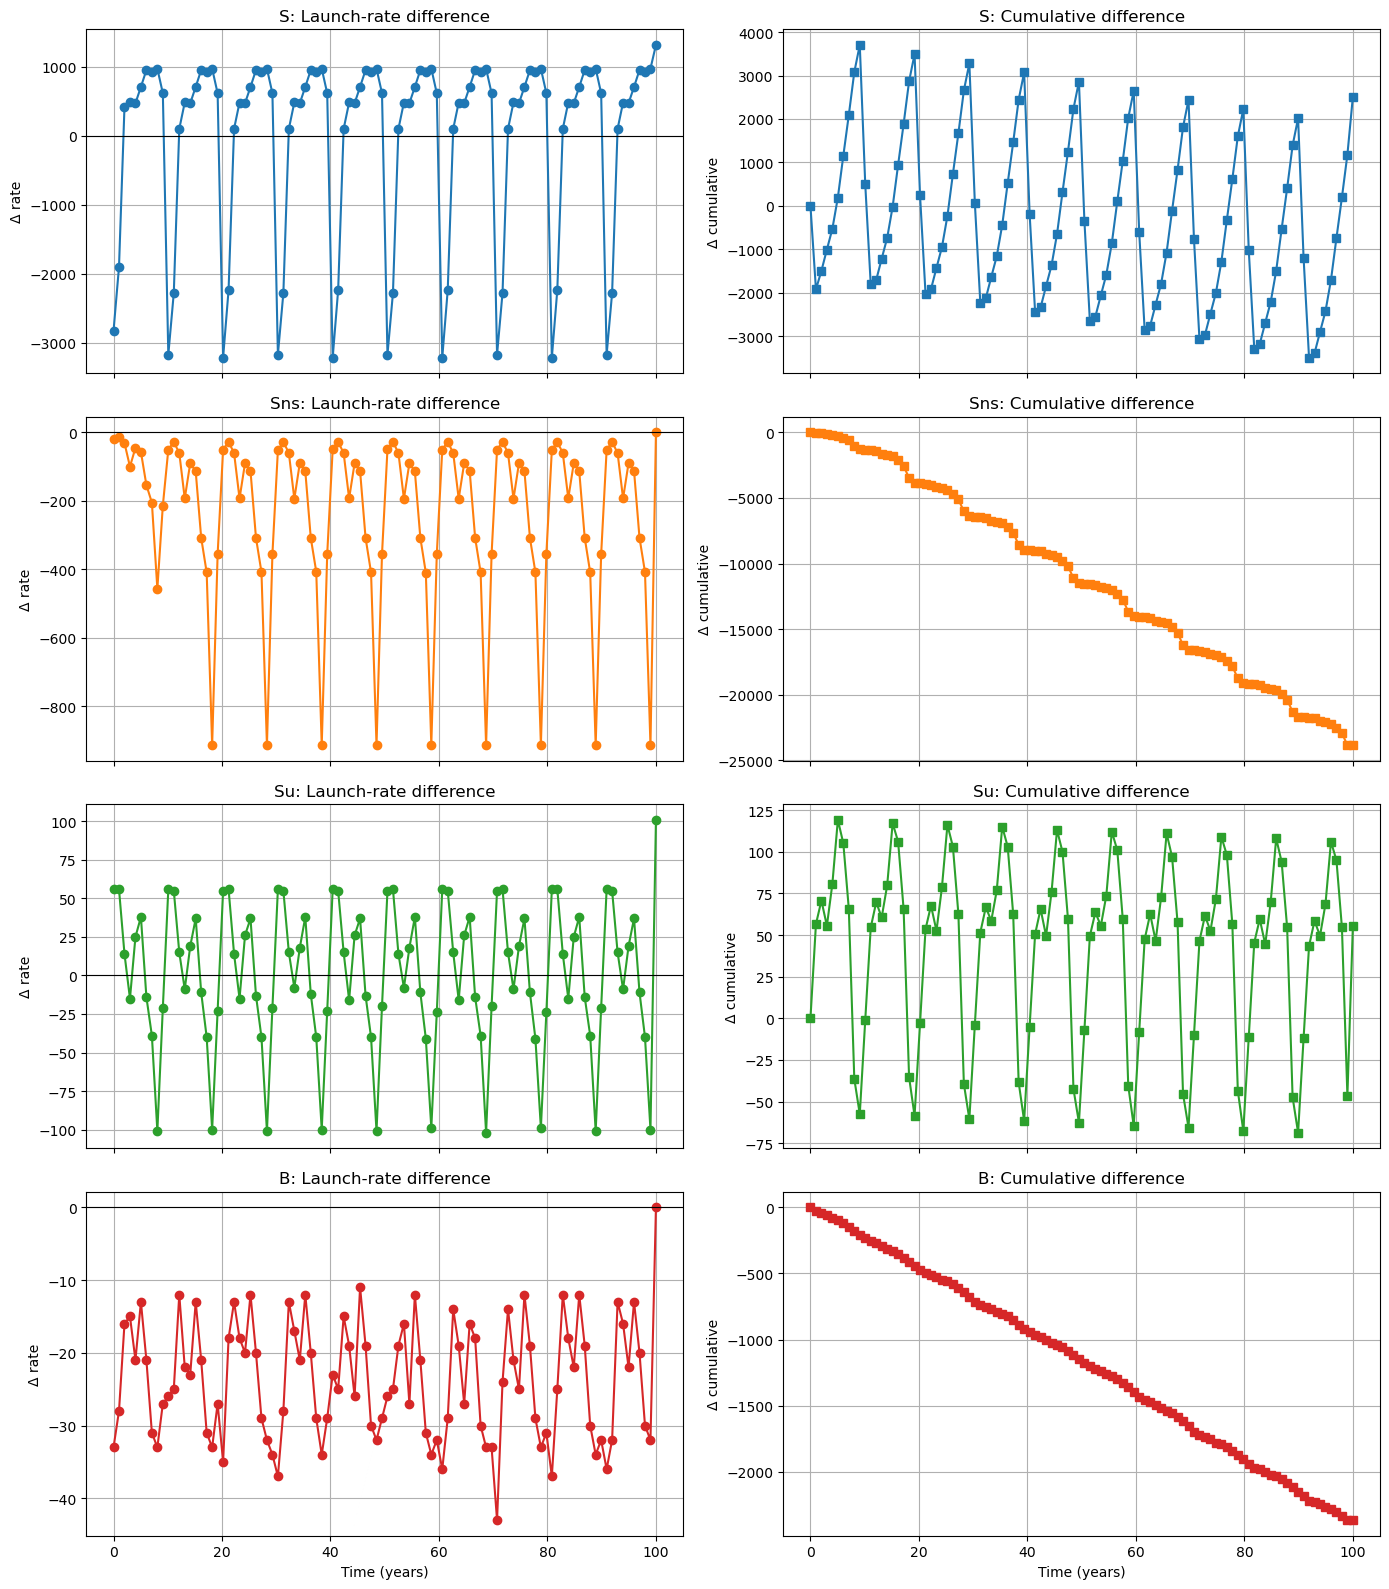

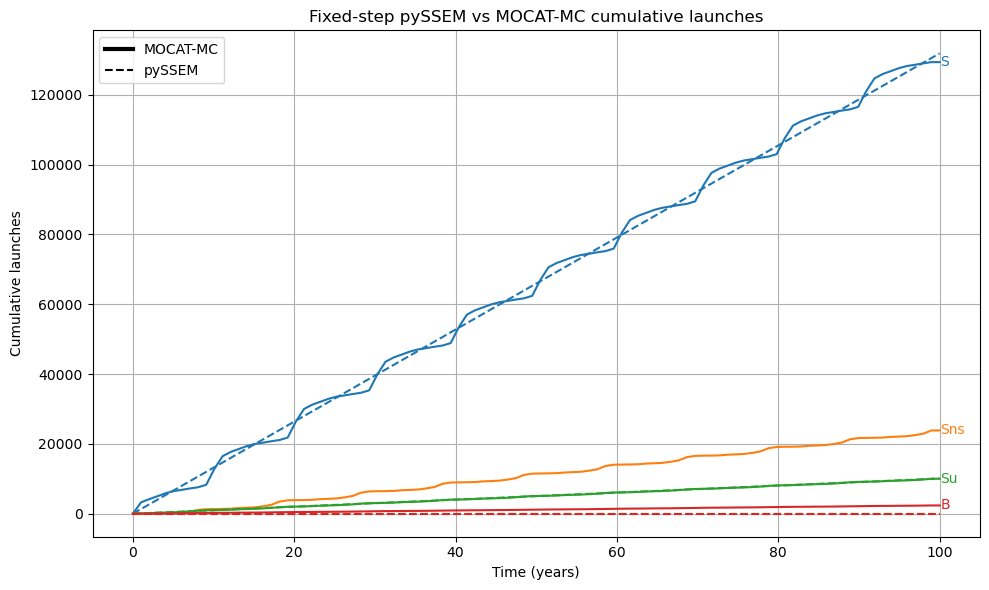

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- Parameters and data ---
scen_times = scenario_properties.scen_times  # numeric years since start
dt = np.diff(scen_times, prepend=scen_times[0])
n_sma, n_species, n_ecc = scenario_properties.x0.shape
species_names = scenario_properties.species_names
target_species = ["S", "Sns", "Su", "B"]

# --- Build MOCAT-MC (SEP2) interpolation functions using numeric years ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_pivot = mc_df.pivot(index='Year', columns='Species', values='Launch_Count')
years_unique = mc_pivot.index.values  # 0,1,2,... up to max year
mc_interp = {
    sp: interp1d(years_unique,
                 mc_pivot[sp].fillna(0).values,
                 kind='previous',
                 bounds_error=False,
                 fill_value=0)
    for sp in target_species
}

# Evaluate MC launch-rate at scen_times (numeric years)
rates_mc = {sp: mc_interp[sp](scen_times) for sp in target_species}

# --- Compute pySSEM fixed-step launch-rate time series ---
rates_pyss = {sp: np.zeros_like(scen_times) for sp in target_species}
for sma in range(n_sma):
    for i_sp, sp in enumerate(species_names):
        if sp in target_species:
            for ecc in range(n_ecc):
                func = launch_rate_functions[sma, i_sp, ecc]
                if func is not None:
                    rates_pyss[sp] += func(scen_times)

# --- Integrate to get cumulative launches ---
cum_pyss = {sp: np.cumsum(rates_pyss[sp] * dt) for sp in target_species}
cum_mc   = {sp: np.cumsum(rates_mc[sp]   * dt) for sp in target_species}

# --- Compute rate and cumulative differences ---
diff_rate = {sp: rates_pyss[sp] - rates_mc[sp] for sp in target_species}
cum_diff  = {sp: cum_pyss[sp] - cum_mc[sp]   for sp in target_species}

# --- 4×2 grid: rate difference (left) and cumulative difference (right) ---
colors = ['C0', 'C1', 'C2', 'C3']
fig, axes = plt.subplots(4, 2, figsize=(14, 16), sharex=True)
for idx, sp in enumerate(target_species):
    c = colors[idx]
    ax_rate = axes[idx, 0]
    ax_cum  = axes[idx, 1]

    ax_rate.plot(scen_times, diff_rate[sp], marker='o', color=c)
    ax_rate.axhline(0, color='black', linewidth=0.8)
    ax_rate.set_title(f"{sp}: Launch‐rate difference")
    ax_rate.set_ylabel("Δ rate")
    ax_rate.grid(True)

    ax_cum.plot(scen_times, cum_diff[sp], marker='s', color=c)
    ax_cum.set_title(f"{sp}: Cumulative difference")
    ax_cum.set_ylabel("Δ cumulative")
    ax_cum.grid(True)

for ax in axes[-1, :]:
    ax.set_xlabel("Time (years)")

plt.tight_layout()
plt.show()

# --- Combined cumulative launches plot with styling ---
plt.figure(figsize=(10, 6))
py_color = 'blue'
mc_color = 'red'
for idx, sp in enumerate(target_species):
    c = colors[idx]
    plt.plot(scen_times, cum_mc[sp], linestyle='-', color=c)
    plt.plot(scen_times, cum_pyss[sp], linestyle='--', color=c)

# Annotate species names at final point
x_off = scen_times[-1] + (scen_times[-1] - scen_times[-2]) * 0.1
for idx, sp in enumerate(target_species):
    y = cum_mc[sp][-1]
    plt.text(x_off, y, sp, va='center', color=colors[idx])

from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], color='black', lw=3, label='MOCAT-MC'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--', label='pySSEM')
]
plt.legend(handles=handles, loc='upper left')

plt.xlabel("Time (years)")
plt.ylabel("Cumulative launches")
plt.title("Fixed‐step pySSEM vs MOCAT-MC cumulative launches")
plt.grid(True)
plt.tight_layout()
plt.show()

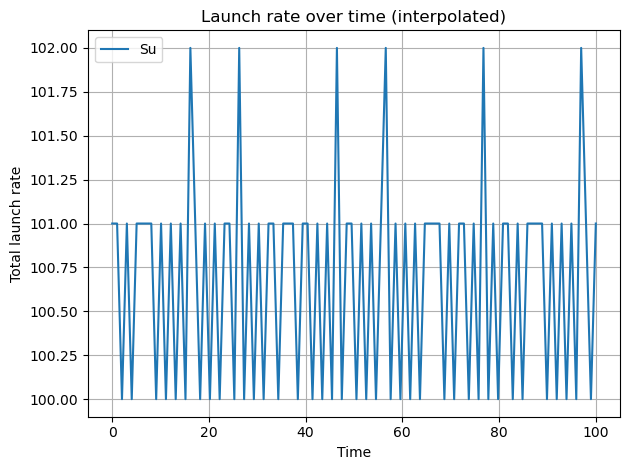

In [14]:
import matplotlib.pyplot as plt

for species in [1]:  # index for S as an example
    flat_launch = np.zeros_like(scenario_properties.scen_times)

    for sma in range(n_sma_bins):
        for ecc in range(n_ecc_bins):
            func = launch_rate_functions[sma, species, ecc]
            if func is not None:
                flat_launch += func(scenario_properties.scen_times)

    plt.plot(scenario_properties.scen_times, flat_launch, label=species_names[species])

plt.xlabel("Time")
plt.ylabel("Total launch rate")
plt.title("Launch rate over time (interpolated)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

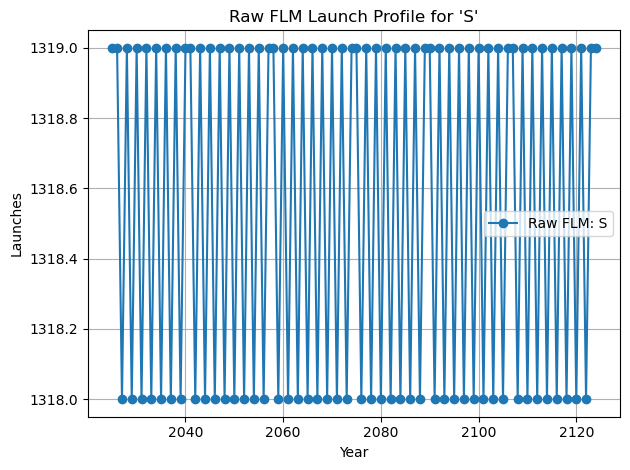

In [15]:
import pandas as pd

# Convert datetime to float years relative to start of scenario
reference_date = scenario_properties.scen_times[0]  # should already be a float year
S_launch = scenario_properties.FLM_steps.groupby('epoch_start_date')['S'].sum()

# Convert datetime to pandas datetime
datetime_index = pd.to_datetime(S_launch.index)
# Convert to float years (e.g., 2025.0, 2025.5)
float_years = datetime_index.year + (datetime_index.dayofyear - 1) / 365.25

# Now assign index
S_launch.index = float_years

# Plot
import matplotlib.pyplot as plt
plt.plot(S_launch.index, S_launch.values, label='Raw FLM: S', marker='o')
plt.xlabel("Year")
plt.ylabel("Launches")
plt.title("Raw FLM Launch Profile for 'S'")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_906/2379676068.py:25: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ssem_yearly = ssem_epoch.resample('Y').sum()


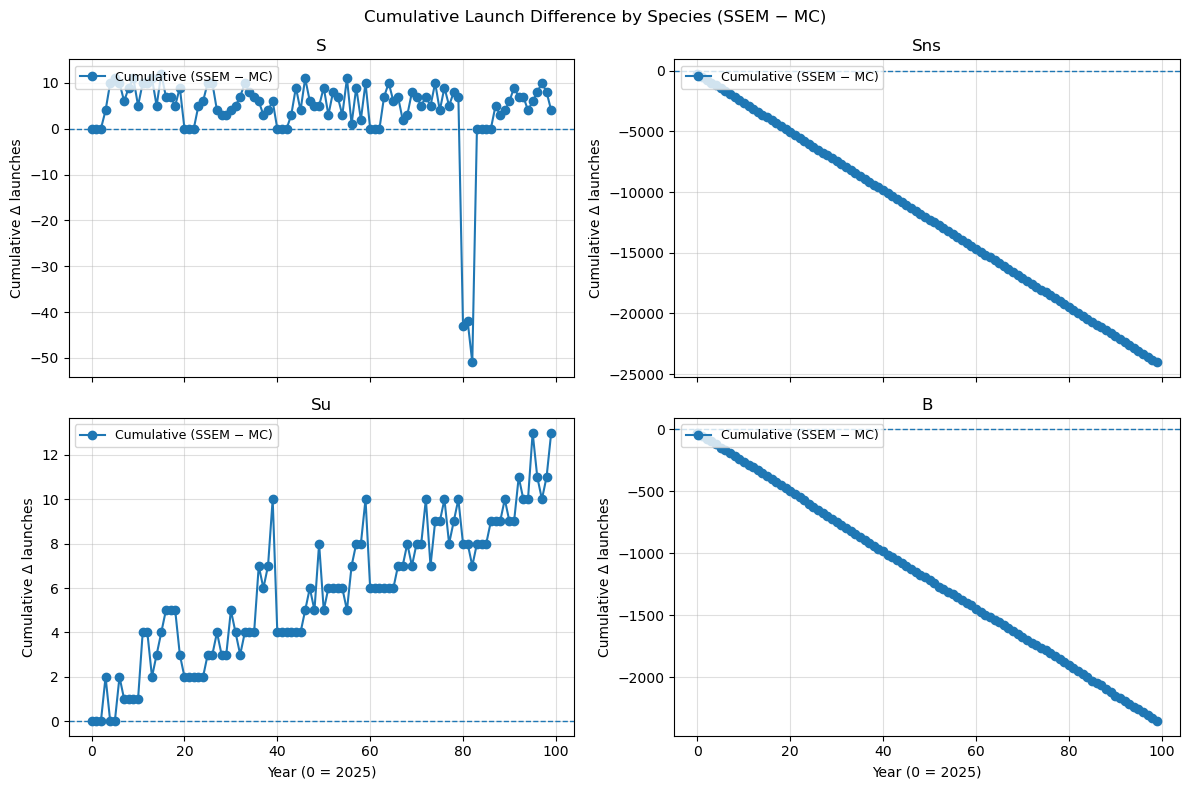

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# === Inputs ===
mc_csv = '/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts.csv'
target_species = ["S", "Sns", "Su", "B"]

# === 1) MOCAT-MC: Year x Species ===
mc = pd.read_csv(mc_csv)
mc_wide = (
    mc.pivot_table(index='Year', columns='Species', values='Launch_Count', aggfunc='sum')
      .reindex(columns=target_species)
      .fillna(0)
      .sort_index()
)

# === 2) MOCAT-SSEM: sum over bins, then calendar-years -> 0-based year index ===
flm = scenario_properties.FLM_steps.copy()
for sp in target_species:
    if sp not in flm.columns:
        flm[sp] = 0  # ensure all species exist

flm['epoch_start_date'] = pd.to_datetime(flm['epoch_start_date'])
ssem_epoch = flm.groupby('epoch_start_date')[target_species].sum()
ssem_yearly = ssem_epoch.resample('Y').sum()

base_year = int(ssem_yearly.index.min().year)  # typically 2025
ssem_yearly['Year'] = ssem_yearly.index.year - base_year
ssem_wide = ssem_yearly.set_index('Year').sort_index()[target_species]

# If MC "Year=0" corresponds to a different calendar base, shift here:
# mc_wide.index = mc_wide.index + (base_year - 2025)

# === 3) Align on common 0-based years ===
common_years = pd.Index(sorted(mc_wide.index.intersection(ssem_wide.index)))
mc_c   = mc_wide.loc[common_years]
ssem_c = ssem_wide.loc[common_years]

# === 4) Cumulative difference (SSEM − MC) ===
diff = (ssem_c[target_species] - mc_c[target_species]).astype(float)
cumdiff = diff.cumsum()

# === 5) Plot ===
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
for ax, sp in zip(axes.flat, target_species):
    ax.plot(common_years, cumdiff[sp], marker='o', lw=1.5, label='Cumulative (SSEM − MC)')
    ax.axhline(0, ls='--', lw=1)
    ax.set_title(sp)
    ax.set_ylabel('Cumulative Δ launches')
    ax.grid(True, alpha=0.4)
    ax.legend(loc='upper left', fontsize=9)

axes[-1,0].set_xlabel(f'Year (0 = {base_year})')
axes[-1,1].set_xlabel(f'Year (0 = {base_year})')
fig.suptitle('Cumulative Launch Difference by Species (SSEM − MC)', y=0.98)
plt.tight_layout()
plt.show()

In [17]:
import matplotlib.pyplot as plt

# List of species to plot
target_species = ["S", "Sns", "Su", "B"]

# Group and sum over all alt_bin and ecc_bin
grouped = scenario_properties.FLM_steps.groupby("epoch_start_date")[target_species].sum()

# Plotting
plt.figure(figsize=(10, 6))
for species in target_species:
    plt.plot(grouped.index, grouped[species], label=species)

plt.xlabel("Date")
plt.ylabel("Launches per Epoch")
plt.title("Launches over Time (summed over alt_bin and ecc_bin)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: "Columns not found: 'B', 'Sns'"

# SMAPE

In [34]:
# === Composite scoring + wider-band grading (WAPE over ALL years) + EXTRA METRICS ===
import numpy as np
import pandas as pd

EPS = 1e-12

# --- sanity checks on required inputs ---
for name in ["metrics_totals_df", "mc_pop_time", "species_groups", "ssem_years", "group_totals"]:
    if name not in globals():
        raise NameError(f"Missing variable: {name}")

# -------- helpers for time-series alignment & extras --------
def _mc_series(mc_df_g, years_ref):
    s = mc_df_g.groupby("Year")["Population"].sum()
    s = s.reindex(years_ref, fill_value=0.0)
    return s.to_numpy(float)

def _align_series(mc_df_g, ssem_years, ssem_vals):
    years_ref = np.asarray(ssem_years, int)
    y_true = _mc_series(mc_df_g, years_ref)
    y_pred = np.asarray(ssem_vals, float)
    # Intersect years: y_pred must align to years_ref already; just truncate to common length
    n = min(len(y_true), len(y_pred))
    return years_ref[:n], y_true[:n], y_pred[:n]

def _group_scale_median_dy(mc_pop_time, group, years_ref):
    mc_g = mc_pop_time[mc_pop_time["Species"] == group]
    if mc_g.empty:
        return 1.0
    y_true = _mc_series(mc_g, years_ref)
    dy = np.diff(y_true)
    scale = np.median(np.abs(dy)) if dy.size else 0.0
    if not np.isfinite(scale) or scale < EPS:
        scale = max(np.median(np.abs(y_true)), 1.0)
    return float(scale)

def linear_calibration(y_true, y_pred):
    y = np.asarray(y_true, float); x = np.asarray(y_pred, float)
    X = np.c_[x, np.ones_like(x)]
    sol, *_ = np.linalg.lstsq(X, y, rcond=None)
    alpha, beta = float(sol[0]), float(sol[1])
    y_cal = alpha * x + beta
    sRMSE = float(np.sqrt(np.mean((y_cal - y)**2)))
    return alpha, beta, sRMSE

def year_of_peak(years, y):
    i = int(np.argmax(y))
    return int(years[i])

def time_to_half_from_peak(years, y):
    i = int(np.argmax(y)); y_peak = y[i]
    if y_peak <= 0: return np.nan
    half = 0.5 * y_peak
    idx = np.where(y[i:] <= half)[0]
    if idx.size == 0: return np.nan
    return float(years[i + idx[0]] - years[i])

def nse(y_true, y_pred):
    y = np.asarray(y_true, float); f = np.asarray(y_pred, float)
    denom = np.sum((y - y.mean())**2)
    if denom <= EPS: return np.nan
    return float(1.0 - np.sum((f - y)**2) / denom)

def theils_u2(y_true, y_pred):
    y = np.asarray(y_true, float); f = np.asarray(y_pred, float)
    num = np.sqrt(np.mean((f - y)**2))
    den = np.sqrt(np.mean((y[1:] - y[:-1])**2)) if len(y) > 1 else np.nan
    if not np.isfinite(den) or den <= EPS: return np.nan
    return float(num / den)

# Optional altitude concentration (HHI)
def hhi_concentration(v):
    v = np.asarray(v, float); s = v.sum()
    if s <= EPS: return 0.0
    p = v / s
    return float(np.sum(p**2))

def _build_mc_alt_heatmap(mc_alt_df, group, years_ref, altitudes=None):
    sub = mc_alt_df[mc_alt_df["Species"] == group]
    if sub.empty: 
        return None, None, None
    piv = sub.pivot(index="Altitude", columns="Year", values="Population").fillna(0.0)
    piv = piv.reindex(columns=years_ref, fill_value=0.0).sort_index(axis=0)
    mc_alts = piv.index.to_numpy(float)
    mc_mat  = piv.to_numpy(float)  # shape: (n_alt, n_time aligned)
    return mc_mat, mc_alts, years_ref

# -------- composite & grading (your original) --------
years_ref = np.asarray(ssem_years, int)
dtw_scales = {g: _group_scale_median_dy(mc_pop_time, g, years_ref) for g in species_groups}

df = metrics_totals_df.reset_index().copy()  # columns: Scenario, Group, metrics...

# normalized DTW
df["DTW_norm"] = [
    row.DTW / max(dtw_scales.get(row.Group, 1.0), EPS)
    for row in df.itertuples(index=False)
]

# global WAPE over all aligned years
df["WAPE_all"] = df["WAPE"].astype(float)

# clamp r to [-1,1]
df["r_clamped"] = df["r"].fillna(0.0).clip(-1, 1)

# composite score (lower is better)
df["Score_group"] = (
    0.40 * df["WAPE_all"] +
    0.30 * np.abs(df["Final_rel_err"].astype(float)) +
    0.20 * (1.0 - df["r_clamped"]) +
    0.10 * df["DTW_norm"]
)

# --- scenario-level score (MC mass-share weights) ---
mc_totals = mc_pop_time.groupby("Species")["Population"].sum().reindex(species_groups).fillna(0.0)
if mc_totals.sum() > 0:
    w = (mc_totals / mc_totals.sum()).to_dict()
else:
    w = {g: 1.0/len(species_groups) for g in species_groups}

def _weighted_score(sub):
    return float(np.sum([w.get(g, 0.0) * s for g, s in zip(sub["Group"], sub["Score_group"])]))

scenario_scores = (
    df.groupby("Scenario")
      .apply(lambda sub: pd.Series({"Score_scenario": _weighted_score(sub)}))
      .reset_index()
)

print("\n=== Per-group composite score (lower is better) ===")
print(df[["Scenario","Group","Score_group","WAPE_all","Final_rel_err","r","DTW","DTW_norm"]]
      .sort_values(["Scenario","Score_group"])
      .to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\n=== Scenario-level score (MC mass-share weighted; lower is better) ===")
print(scenario_scores.sort_values("Score_scenario")
      .to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# --- wider-band grading (same bands, now labeling WAPE_all) ---
def _bucket(x, cuts):
    for upper, label in cuts:
        if x < upper:
            return label
    return cuts[-1][1]

score_cuts_wide = [(0.60,"Good"), (1.40,"Moderate"), (2.60,"Poor"), (float("inf"),"Mischaracterized")]
wape_cuts_wide  = [(0.15,"Good"), (0.35,"Moderate"), (0.65,"Poor"), (float("inf"),"Mischaracterized")]
final_cuts_wide = wape_cuts_wide
dtw_cuts_wide   = [(3,"Good"), (7,"Moderate"), (12,"Poor"), (float("inf"),"Mischaracterized")]

def _grade_r(r):
    if r >= 0.90: return "Good"
    if r >= 0.80: return "Moderate"
    if r >= 0.65: return "Poor"
    return "Mischaracterized"

df_cat = df.copy()
df_cat["Grade"]        = df_cat["Score_group"].apply(lambda v: _bucket(float(v), score_cuts_wide))
df_cat["Grade_WAPE"]   = df_cat["WAPE_all"].apply(lambda v: _bucket(float(v), wape_cuts_wide))
df_cat["Grade_Final"]  = df_cat["Final_rel_err"].abs().apply(lambda v: _bucket(float(v), final_cuts_wide))
df_cat["Grade_r"]      = df_cat["r"].fillna(0.0).apply(_grade_r)
df_cat["Grade_DTWn"]   = df_cat["DTW_norm"].apply(lambda v: _bucket(float(v), dtw_cuts_wide))

def _why(row):
    issues = []
    if row["Grade_WAPE"]  in ("Poor","Mischaracterized"): issues.append("magnitude (all years)")
    if row["Grade_Final"] in ("Poor","Mischaracterized"): issues.append("endpoint")
    if row["Grade_r"]     in ("Poor","Mischaracterized"): issues.append("shape")
    if row["Grade_DTWn"]  in ("Poor","Mischaracterized"): issues.append("timing")
    return ", ".join(issues) if issues else "well-matched"

df_cat["Why"] = df_cat.apply(_why, axis=1)

print("\n=== Per-group score with wider-band grades ===")
print(df_cat[["Scenario","Group","Score_group","Grade",
              "WAPE_all","Final_rel_err","r","DTW_norm","Why"]]
      .sort_values(["Scenario","Score_group"])
      .to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# --------- EXTRA METRICS (time-series based) ----------
# We assume this cell is run for a single scenario at a time (group_totals corresponds to that scenario).
scenario_name = df["Scenario"].iloc[0] if len(df) else "Scenario"

extra_rows = []
for g in species_groups:
    if g not in group_totals:  # need SSEM series for this group
        continue
    mc_df_g = mc_pop_time[mc_pop_time["Species"] == g]
    if mc_df_g.empty:
        continue

    years, y_true, y_pred = _align_series(mc_df_g, ssem_years, group_totals[g])

    # Scale/bias decomposition
    alpha, beta, srmse  = linear_calibration(y_true, y_pred)

    # Event timing
    peak_mc   = year_of_peak(years, y_true)
    peak_ssem = year_of_peak(years, y_pred)
    d_peak    = int(peak_ssem - peak_mc)
    t_half_mc = time_to_half_from_peak(years, y_true)
    t_half_ss = time_to_half_from_peak(years, y_pred)

    # Skill scores
    nse_val   = nse(y_true, y_pred)
    u2_val    = theils_u2(y_true, y_pred)

    row = {
        "Scenario": scenario_name, "Group": g,
        "alpha_scale": alpha, "beta_offset": beta, "sRMSE": srmse,
        "PeakYear_MC": peak_mc, "PeakYear_SSEM": peak_ssem, "DeltaPeakYear": d_peak,
        "T_half_MC": t_half_mc, "T_half_SSEM": t_half_ss,
        "NSE": nse_val, "Theils_U2": u2_val
    }

    # Optional altitude concentration metrics (HHI) if inputs available:
    hhi_mc_med = hhi_ssem_med = np.nan
    try:
        mc_alt_df = None
        if "mc_pop_time_alt" in globals():
            mc_alt_df = mc_pop_time_alt
        elif "mc_pop_time_alt_path" in globals():
            try:
                mc_alt_df = pd.read_csv(mc_pop_time_alt_path)
            except Exception:
                mc_alt_df = None

        if ("ssem_group_hm" in globals()) and (mc_alt_df is not None) and (g in ssem_group_hm):
            mc_mat, mc_alts, _ = _build_mc_alt_heatmap(mc_alt_df, g, np.asarray(ssem_years, int))
            ssem_mat = ssem_group_hm[g] if isinstance(ssem_group_hm[g], np.ndarray) else np.asarray(ssem_group_hm[g], float)
            if (mc_mat is not None) and (ssem_mat is not None) and mc_mat.shape[1] == ssem_mat.shape[1]:
                hhi_mc   = [hhi_concentration(mc_mat[:, t])   for t in range(mc_mat.shape[1])]
                hhi_ssem = [hhi_concentration(ssem_mat[:, t]) for t in range(ssem_mat.shape[1])]
                hhi_mc_med   = float(np.median(hhi_mc)) if len(hhi_mc) else np.nan
                hhi_ssem_med = float(np.median(hhi_ssem)) if len(hhi_ssem) else np.nan
    except Exception:
        pass

    row.update({
        "HHI_MC_med": hhi_mc_med,
        "HHI_SSEM_med": hhi_ssem_med,
        "HHI_delta": (hhi_ssem_med - hhi_mc_med) if (np.isfinite(hhi_mc_med) and np.isfinite(hhi_ssem_med)) else np.nan
    })
    extra_rows.append(row)

extras_df = pd.DataFrame(extra_rows)

# Merge extras into df (by Scenario, Group)
df_ext = df.merge(extras_df, on=["Scenario","Group"], how="left")

print("\n=== Added extras (scale/timing/skill & HHI if available) ===")
cols_show = ["Scenario","Group","alpha_scale","beta_offset","sRMSE",
             "PeakYear_MC","PeakYear_SSEM","DeltaPeakYear",
             "T_half_MC","T_half_SSEM","NSE","Theils_U2",
             "HHI_MC_med","HHI_SSEM_med","HHI_delta"]
print(df_ext[cols_show].sort_values(["Scenario","Group"])
      .to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Optional saves:
df_ext.to_csv("composite_scores_with_extras.csv", index=False)
df_cat.to_csv("composite_scores_with_grades_wape_all.csv", index=False)
scenario_scores.to_csv("scenario_scores_wape_all.csv", index=False)


=== Per-group composite score (lower is better) ===
    Scenario Group  Score_group  WAPE_all  Final_rel_err      r      DTW  DTW_norm
SSEM_current    Su       0.1705    0.0408         0.0102 0.9148   5.3635    1.3409
SSEM_current     S       0.4956    0.0119        -0.0006 0.9167  18.9594    4.7399
SSEM_current     B       0.8657    0.1586         0.1802 0.9706  37.1165    7.4233
SSEM_current     D       1.3409    0.7677         0.5366 0.9909  95.8056    8.7096
SSEM_current     N       2.3862    0.6536         1.0107 0.9582 997.2467   18.1318

=== Scenario-level score (MC mass-share weighted; lower is better) ===
    Scenario  Score_scenario
SSEM_current          1.1587

=== Per-group score with wider-band grades ===
    Scenario Group  Score_group    Grade  WAPE_all  Final_rel_err     r  DTW_norm                                     Why
SSEM_current    Su        0.170     Good     0.041          0.010 0.915     1.341                            well-matched
SSEM_current     S        0

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_2179/4042163158.py:126: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda sub: pd.Series({"Score_scenario": _weighted_score(sub)}))
